THE SCHEDULING PROBLEM

In [1]:
import numpy as np
from qiskit.quantum_info import SparsePauliOp
from itertools import product
import networkx as nx
import matplotlib.pyplot as plt


# Define identity and Z matrices as Pauli strings
Z = 'Z'
I = 'I'

# Function to generate SparsePauliOp
def kronecker_product(operators, coeff, N):
    # Construct the Pauli string by joining the operators
    pauli_string = ''.join(operators)

    # Create the SparsePauliOp with the given coefficient
    return SparsePauliOp.from_list([(pauli_string, coeff)], num_qubits=N)

/home/uni_x/.local/lib/python3.10/site-packages/numpy/_core/getlimits.py:551: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


In [2]:
#Object oriented problem statement:
class scheduling_problem():
    def __init__(self, M, J, E, run_times):
        self.M = M
        self.J = J
        self.E = E
        self.run_times = run_times
        self.T = np.sum(run_times)
    
    #Needs to define hamiltonian
    def get_hamiltonian():
        pass

######

class seperate_index_scheduling_problem(scheduling_problem):
    def __init__(self, M, J, E, run_times):
        super().__init__(M,J,E,run_times)

        #Setup: add dummy index
        self.J = self.J + 1 #Adding the dummy node
        self.T = self.T + 1 #Adding time for dummy job
        #The last j is the dummy job
        self.run_times = self.run_times + [0]
        self.E += [(i, self.J-1) for i in range(self.J-1)] #Adding edges from the jobs to the dummy
        self.num_qubits = self.M * self.J * self.T
        self.term = SparsePauliOp.from_list([], num_qubits=self.num_qubits)

    #Function to access the qubit from its m,j,t index
    #@params
    # @@@ m - machine index
    # @@@ j - job index
    # @@@ t - time index
    def get_indicator_index(self, m, j, t):
        return m + self.M * j + self.M * self.J * t

    #Adds the QUBO term: x_(m,j,t) * x_(m',j',t') -> (1-a)*(1-b)-> -a-b+ab
    def binary_condition(self, m,j,t, m_tag, j_tag, t_tag, penalty_coeff):
        #Negative Linear terms
        operators = [I] * self.num_qubits
        operators[self.get_indicator_index(m,j,t)] = Z
        self.term += kronecker_product(operators, -1 * penalty_coeff, self.num_qubits)

        operators = [I] * self.num_qubits
        operators[self.get_indicator_index(m_tag,j_tag,t_tag)] = Z
        self.term += kronecker_product(operators, -1 * penalty_coeff, self.num_qubits)
        
        #Positive Square terms
        operators = [I] * self.num_qubits
        operators[self.get_indicator_index(m,j,t)] = Z
        operators[self.get_indicator_index(m_tag,j_tag,t_tag)] = Z
        self.term += kronecker_product(operators, penalty_coeff, self.num_qubits)

    #####
    def H_no_parallel_execution(self, penalty_coeff):
        #Loop through all combinations that need Z:
        for m in range(self.M):
            for j in range(self.J):
                for j_tag in range(j+1, self.J): #Pairs
                    for t in range(self.T):
                        for t_tag in range(t, min(t + self.run_times[j], self.T)): #Note - it is not run_times[j] - 1, since range doesn't include the edge 
                            self.binary_condition(m,j,t, m, j_tag, t_tag, penalty_coeff)

    def H_dependency(self, penalty_coeff):
        for (j,j_tag) in self.E:
            for m in range(self.M):
                for m_tag in range(self.M):
                    for t in range(self.T):
                        for t_tag in range(0, min(t + self.run_times[j], self.T)): #Note - run_times[j] - 1 
                            self.binary_condition(m,j,t, m_tag, j_tag, t_tag, penalty_coeff)

    def H_force_run(self, penalty_coeff): #Force every job to run once.
        ###

        for j in range(self.J):
            for m in range(self.M):
                for t in range(self.T):
                    operators = [I] * self.num_qubits
                    operators[self.get_indicator_index(m,j,t)] = Z
                    self.term += kronecker_product(operators, (1 - self.M * self.T / 2) * penalty_coeff, self.num_qubits)

            for m in range(self.M):
                for m_tag in range(self.M):
                    for t in range(self.T):
                        for t_tag in range(t, self.T): #need to multiply the coeff
                            if(t == t_tag and m == m_tag): #Only in this case we can skip
                                continue
                            operators = [I] * self.num_qubits
                            operators[self.get_indicator_index(m,j,t)] = Z
                            operators[self.get_indicator_index(m_tag,j,t_tag)] = Z
                            self.term += kronecker_product(operators, 0.5 * penalty_coeff, self.num_qubits)

    def H_finish_time(self):
        #Loop through all combinations that need Z:
        j_dummy = self.J - 1

        #Score for adding the dummy job on any machine
        for t in range(self.T):
            for m in range(self.M):
                    operators = [I] * self.num_qubits
                    operators[self.get_indicator_index(m,j_dummy,t)] = Z
                    self.term += kronecker_product(operators, (-1) * t, self.num_qubits)

        
    def get_hamiltonian(self, penalty_coeff):
        self.term = SparsePauliOp.from_list([], num_qubits=self.num_qubits)
        #All conditions
        self.H_no_parallel_execution(penalty_coeff)
        self.H_dependency(penalty_coeff)
        self.H_force_run(penalty_coeff)
        self.H_finish_time()

        return self.term
    
    def print_solution(self, binary_solution):
        print("Quantum State (computational basis):", '|' + binary_solution + '>')
        print("===Solution===")
        for t in range(self.T):
            for j in range(self.J):
                for m in range(self.M):
                    if(binary_solution[self.get_indicator_index(m,j,t)] == '1'):
                        print(f"t={t}: Job #{j if j != self.J-1 else 'dummy'} -> Machine #{m}")
        print("===end===")

    def print_problem(self):
        print("===Problem===")
        print(f"Run {self.J - 1}(+1 dummy) jobs on {self.M} machines.")
        print(f"Job Lengths: {self.run_times}")
        print(f"Dependency Graph {self.E}")
        print("===")

In [3]:
class seperate_index_full_values_scheduling_problem(scheduling_problem):
    #Represents the full hamiltonian without constants dropped out
    def __init__(self, M, J, E, run_times):
        super().__init__(M,J,E,run_times)

        #Setup: add dummy index
        self.J = self.J + 1 #Adding the dummy node
        self.T = self.T + 1 #Adding time for dummy job
        #The last j is the dummy job
        self.run_times = self.run_times + [0]
        self.E += [(i, self.J-1) for i in range(self.J-1)] #Adding edges from the jobs to the dummy
        self.num_qubits = self.M * self.J * self.T

    #Function to access the qubit from its m,j,t index
    def get_indicator_index(self, m, j, t):
        return m + self.M * j + self.M * self.J * t

    #Adds the QUBO term: x_(m,j,t) * x_(m',j',t') -> 0.25(1-a)*(1-b)-> 0.25(1-a-b+ab)
    def binary_condition(self, m,j,t, m_tag, j_tag, t_tag, penalty_coeff):
        term = SparsePauliOp.from_list([], num_qubits=self.num_qubits)
        #Identity term
        operators = [I] * self.num_qubits
        term += kronecker_product(operators, 0.25 * penalty_coeff, self.num_qubits)

        #Negative Linear terms
        operators = [I] * self.num_qubits
        operators[self.get_indicator_index(m,j,t)] = Z
        term += kronecker_product(operators, -0.25 * penalty_coeff, self.num_qubits)

        operators = [I] * self.num_qubits
        operators[self.get_indicator_index(m_tag,j_tag,t_tag)] = Z
        term += kronecker_product(operators, -0.25 * penalty_coeff, self.num_qubits)
        
        #Positive Square terms
        operators = [I] * self.num_qubits
        operators[self.get_indicator_index(m,j,t)] = Z
        operators[self.get_indicator_index(m_tag,j_tag,t_tag)] = Z
        term += kronecker_product(operators, 0.25*penalty_coeff, self.num_qubits)

        return term

    #####
    def H_no_parallel_execution(self, penalty_coeff):
        term = SparsePauliOp.from_list([], num_qubits=self.num_qubits)
        
        for m in range(self.M):
            for j in range(self.J):
                for j_tag in range(j+1, self.J): #Pairs
                    for t in range(self.T):
                        for t_tag in range(t, min(t + self.run_times[j], self.T)): #Note - from t'=t because maybe the job finished way earlier
                            term += self.binary_condition(m,j,t, m, j_tag, t_tag, penalty_coeff)
                            #print(f"(m,j,t)={(m,j,t)},(m',j',t')={(m,j_tag,t_tag)}")
        return term

    def H_dependency(self, penalty_coeff):
        term = SparsePauliOp.from_list([], num_qubits=self.num_qubits)
        
        for (j,j_tag) in self.E:
            for m in range(self.M):
                for m_tag in range(self.M):
                    for t in range(self.T):
                        for t_tag in range(0, min(t + self.run_times[j], self.T)): #Note - from t'=0 because it cannot happen before j
                            #print(f"#dep: {(m,j,t)} & {(m_tag, j_tag, t_tag)}")
                            term += self.binary_condition(m,j,t, m_tag, j_tag, t_tag, penalty_coeff)
        return term

    def H_force_run(self, penalty_coeff): #Force every job to run once.
        term = SparsePauliOp.from_list([], num_qubits=self.num_qubits)
        
        for j in range(self.J):
            operators = [I] * self.num_qubits
            term += kronecker_product(operators, (1 - self.M * self.T / 2)*(1 - self.M * self.T / 2) * penalty_coeff, self.num_qubits)

            for m in range(self.M):
                for t in range(self.T):
                    operators = [I] * self.num_qubits
                    operators[self.get_indicator_index(m,j,t)] = Z
                    term += kronecker_product(operators, (1 - self.M * self.T / 2) * penalty_coeff, self.num_qubits)

            for m in range(self.M):
                for m_tag in range(self.M):
                    for t in range(self.T):
                        for t_tag in range(self.T):
                            operators = [I] * self.num_qubits
                            operators[self.get_indicator_index(m,j,t)] = Z
                            operators[self.get_indicator_index(m_tag,j,t_tag)] = Z
                            if(m == m_tag and t == t_tag):
                                operators[self.get_indicator_index(m_tag,j,t_tag)] = I

                            term += kronecker_product(operators, 0.25 * penalty_coeff, self.num_qubits)
                            #print(f"(m,j,t)={(m,j,t)},(m',j',t')={(m_tag,j,t_tag)}")
        return term

    def H_finish_time(self):
        term = SparsePauliOp.from_list([], num_qubits=self.num_qubits)
        j_dummy = self.J - 1

        #Score for adding the dummy job on any machine
        for t in range(self.T):
            for m in range(self.M):
                    operators = [I] * self.num_qubits
                    term += kronecker_product(operators, (0.5) * t, self.num_qubits)
                    
                    operators = [I] * self.num_qubits
                    operators[self.get_indicator_index(m,j_dummy,t)] = Z
                    term += kronecker_product(operators, (-0.5) * t, self.num_qubits)
        return term

        
    def get_hamiltonian(self, penalty_coeff):
        return self.H_no_parallel_execution(penalty_coeff) + self.H_dependency(penalty_coeff) + self.H_force_run(penalty_coeff) + self.H_finish_time()
    
    def print_solution(self, binary_solution):
        print("Quantum State (computational basis):", '|' + binary_solution + '>')
        print("===Solution===")
        for t in range(self.T):
            for j in range(self.J):
                for m in range(self.M):
                    if(binary_solution[self.get_indicator_index(m,j,t)] == '1'):
                        print(f"t={t}: Job #{j if j != self.J-1 else 'dummy'} -> Machine #{m}")
        print("===end===")

    def print_problem(self):
        print("===Problem===")
        print(f"Run {self.J - 1}(+1 dummy) jobs on {self.M} machines.")
        print(f"Job Lengths: {self.run_times}")
        print(f"Dependency Graph {self.E}")
        print("===")

In [4]:
class xy_method_base_scheduling_problem(scheduling_problem):
    def __init__(self, M, J, E, run_times):
        super().__init__(M,J,E,run_times)

        #Setup: add dummy index
        self.J = self.J + 1 #Adding the dummy node
        self.T = self.T + 1 #Adding time for dummy job
        #The last j is the dummy job
        self.run_times = self.run_times + [0]
        self.E += [(i, self.J-1) for i in range(self.J-1)] #Adding edges from the jobs to the dummy
        self.num_qubits = self.M * self.J + self.T * self.J

        self.term = SparsePauliOp.from_list([], num_qubits=self.num_qubits)

    #X_(m,j) and Y_(t,j) are two binary vectors appended together
    def X_get_indicator_index(self, m, j, t):
        return m + self.M * j
    
    def Y_get_indicator_index(self, m, j, t):
        return self.M * self.J + j + self.J * t #Y occurs after all of X

    #Adds the QUBO term: x_(m,j,t) * x_(m',j',t')
    #Note that x_(m,j,t) = X_(m,j) * Y_(t,j) so the expansion is different
    #-> (1-a)(1-b)(1-c)(1-d)-> -a-b-c-d+ab+bc+cd+ad+ac+bd-abc-bcd-cda-dba+abcd
    #a=X_m,j; b=Y_m,j; c=X_m',j'; d=Y_m',j'
    def binary_condition(self, m,j,t, m_tag, j_tag, t_tag, penalty_coeff):
        a = self.X_get_indicator_index(m,j,t)
        b = self.Y_get_indicator_index(m,j,t)
        c = self.X_get_indicator_index(m_tag,j_tag,t_tag)
        d = self.Y_get_indicator_index(m_tag,j_tag,t_tag)
        
        #Negative Linear terms
        operators = [I] * self.num_qubits
        operators[a] = Z
        self.term += kronecker_product(operators, -1 * penalty_coeff, self.num_qubits)

        operators = [I] * self.num_qubits
        operators[b] = Z
        self.term += kronecker_product(operators, -1 * penalty_coeff, self.num_qubits)
        
        operators = [I] * self.num_qubits
        operators[c] = Z
        self.term += kronecker_product(operators, -1 * penalty_coeff, self.num_qubits)

        operators = [I] * self.num_qubits
        operators[d] = Z
        self.term += kronecker_product(operators, -1 * penalty_coeff, self.num_qubits)

        #Positive Square terms
        operators = [I] * self.num_qubits
        operators[a] = Z
        operators[b] = Z
        self.term += kronecker_product(operators, penalty_coeff, self.num_qubits)

        operators = [I] * self.num_qubits
        operators[b] = Z
        operators[c] = Z
        self.term += kronecker_product(operators, penalty_coeff, self.num_qubits)

        operators = [I] * self.num_qubits
        operators[c] = Z
        operators[d] = Z
        self.term += kronecker_product(operators, penalty_coeff, self.num_qubits)

        operators = [I] * self.num_qubits
        operators[a] = Z
        operators[d] = Z
        self.term += kronecker_product(operators, penalty_coeff, self.num_qubits)

        operators = [I] * self.num_qubits
        operators[a] = Z
        operators[c] = Z
        self.term += kronecker_product(operators, penalty_coeff, self.num_qubits)

        operators = [I] * self.num_qubits
        operators[b] = Z
        operators[d] = Z
        self.term += kronecker_product(operators, penalty_coeff, self.num_qubits)

        #Negative cubic terms:
        operators = [I] * self.num_qubits
        operators[a] = Z
        operators[b] = Z
        operators[c] = Z
        self.term += kronecker_product(operators, -1 * penalty_coeff, self.num_qubits)

        operators = [I] * self.num_qubits
        operators[a] = Z
        operators[b] = Z
        operators[d] = Z
        self.term += kronecker_product(operators, -1 * penalty_coeff, self.num_qubits)

        operators = [I] * self.num_qubits
        operators[a] = Z
        operators[c] = Z
        operators[d] = Z
        self.term += kronecker_product(operators, -1 * penalty_coeff, self.num_qubits)

        operators = [I] * self.num_qubits
        operators[b] = Z
        operators[c] = Z
        operators[d] = Z
        self.term += kronecker_product(operators, -1 * penalty_coeff, self.num_qubits)

        #Positive quartic term:
        operators = [I] * self.num_qubits
        operators[a] = Z
        operators[b] = Z
        operators[c] = Z
        operators[d] = Z
        self.term += kronecker_product(operators, penalty_coeff, self.num_qubits)

    #####
    def H_no_parallel_execution(self, penalty_coeff):
        for m in range(self.M):
            for j in range(self.J):
                for j_tag in range(j+1, self.J): #Pairs
                    for t in range(self.T):
                        for t_tag in range(t, min(t + self.run_times[j], self.T)):
                            self.binary_condition(m,j,t, m, j_tag, t_tag, penalty_coeff)

    def H_dependency(self, penalty_coeff):
        for (j,j_tag) in self.E:
            for m in range(self.M):
                for m_tag in range(self.M):
                    for t in range(self.T):
                        for t_tag in range(0, min(t + self.run_times[j], self.T)):
                            self.binary_condition(m,j,t, m_tag, j_tag, t_tag, penalty_coeff)

    def H_force_run(self, penalty_coeff): #Force every job to run once.
        #if there is a bug, it is most of the time here :)
        for j in range(self.J):
            for m in range(self.M):
                for t in range(self.T):
                    operators = [I] * self.num_qubits
                    operators[self.X_get_indicator_index(m,j,t)] = Z
                    self.term += kronecker_product(operators, 0.5*(1 - self.M * self.T / 4) * penalty_coeff, self.num_qubits)
                    
                    operators = [I] * self.num_qubits
                    operators[self.Y_get_indicator_index(m,j,t)] = Z
                    self.term += kronecker_product(operators, 0.5*(1 - self.M * self.T / 4) * penalty_coeff, self.num_qubits)
                    
                    operators = [I] * self.num_qubits
                    operators[self.X_get_indicator_index(m,j,t)] = Z
                    operators[self.Y_get_indicator_index(m,j,t)] = Z
                    self.term += kronecker_product(operators, -1 * 0.5*(1 - self.M * self.T / 4) * penalty_coeff, self.num_qubits)

            #Quadratic terms:
            for m in range(self.M):
                for m_tag in range(self.M):
                    for t in range(self.T):
                        for t_tag in range(self.T):
                            if(m == m_tag and t == t_tag):
                                continue
                            #Quadratic terms: (x+y-xy)^2 -> xy' + x'y + xx' + yy'
                            operators = [I] * self.num_qubits
                            operators[self.X_get_indicator_index(m,j,t)] = Z
                            operators[self.Y_get_indicator_index(m_tag,j,t_tag)] = Z
                            self.term += kronecker_product(operators, 1/16 * penalty_coeff, self.num_qubits)

                            operators = [I] * self.num_qubits
                            operators[self.Y_get_indicator_index(m,j,t)] = Z
                            operators[self.X_get_indicator_index(m_tag,j,t_tag)] = Z
                            self.term += kronecker_product(operators, 1/16 * penalty_coeff, self.num_qubits)

                            operators = [I] * self.num_qubits
                            operators[self.X_get_indicator_index(m,j,t)] = Z
                            operators[self.X_get_indicator_index(m_tag,j,t_tag)] = Z
                            self.term += kronecker_product(operators, 1/16 * penalty_coeff, self.num_qubits)

                            operators = [I] * self.num_qubits
                            operators[self.Y_get_indicator_index(m,j,t)] = Z
                            operators[self.Y_get_indicator_index(m_tag,j,t_tag)] = Z
                            self.term += kronecker_product(operators, 1/16 * penalty_coeff, self.num_qubits)

                            #Cubic terms: -> -2x^2y-2xy^2
                            operators = [I] * self.num_qubits
                            operators[self.X_get_indicator_index(m,j,t)] = Z
                            operators[self.Y_get_indicator_index(m,j,t)] = Z
                            operators[self.X_get_indicator_index(m_tag,j,t_tag)] = Z
                            self.term += kronecker_product(operators, -1/16 * penalty_coeff, self.num_qubits)

                            operators = [I] * self.num_qubits
                            operators[self.X_get_indicator_index(m,j,t)] = Z
                            operators[self.Y_get_indicator_index(m,j,t)] = Z
                            operators[self.Y_get_indicator_index(m_tag,j,t_tag)] = Z
                            self.term += kronecker_product(operators, -1/16 * penalty_coeff, self.num_qubits)

                            #Quartic term xyx'y':
                            operators = [I] * self.num_qubits
                            operators[self.X_get_indicator_index(m,j,t)] = Z
                            operators[self.Y_get_indicator_index(m,j,t)] = Z
                            operators[self.X_get_indicator_index(m_tag,j,t_tag)] = Z
                            operators[self.Y_get_indicator_index(m_tag,j,t_tag)] = Z
                            self.term += kronecker_product(operators, 1/16 * penalty_coeff, self.num_qubits)

    def H_finish_time(self):
        #Loop through all combinations that need Z:
        j_dummy = self.J - 1

        #Score for adding the dummy job on any machine
        for t in range(self.T):
            for m in range(self.M):
                    #Term: X_m,j,t -> (1-a)(1-b) -> -a-b+ab, a=X_m,j ; b=Y_t,j
                    operators = [I] * self.num_qubits
                    operators[self.X_get_indicator_index(m,j_dummy,t)] = Z
                    self.term += kronecker_product(operators, (-1) * t, self.num_qubits)

                    operators = [I] * self.num_qubits
                    operators[self.Y_get_indicator_index(m,j_dummy,t)] = Z
                    self.term += kronecker_product(operators, (-1) * t, self.num_qubits)

                    operators = [I] * self.num_qubits
                    operators[self.X_get_indicator_index(m,j_dummy,t)] = Z
                    operators[self.Y_get_indicator_index(m,j_dummy,t)] = Z
                    self.term += kronecker_product(operators, t, self.num_qubits)

        
    def get_hamiltonian(self, penalty_coeff):
        self.term = SparsePauliOp.from_list([], num_qubits=self.num_qubits)
        #All conditions
        self.H_no_parallel_execution(penalty_coeff)
        self.H_dependency(penalty_coeff)
        self.H_force_run(penalty_coeff)
        self.H_finish_time()

        return self.term
    
    def print_solution(self, binary_solution):
        print("Quantum State (computational basis):", '|' + binary_solution + '>')
        
        print(f"M={self.M}, J={self.J}, T={self.T}")
        print(f"X={binary_solution[ : self.M*self.J]}, Y={binary_solution[self.M*self.J : ]}")

        print("===Solution===")
        for t in range(self.T):
            for j in range(self.J):
                for m in range(self.M):
                    if(binary_solution[self.X_get_indicator_index(m,j,t)] == '1' and binary_solution[self.Y_get_indicator_index(m,j,t)] == '1'):
                        print(f"t={t}: Job #{j if j != self.J-1 else 'dummy'} -> Machine #{m}")
        print("===end===")

    def print_problem(self):
        print("===Problem===")
        print(f"Run {self.J - 1}(+1 dummy) jobs on {self.M} machines.")
        print(f"Job Lengths: {self.run_times}")
        print(f"Dependency Graph {self.E}")
        print("===")

In [5]:
class xy_method_scheduling_problem(xy_method_base_scheduling_problem):
    def __init__(self, M, J, E, run_times):
        super().__init__(M,J,E,run_times)
    
    def H_force_run(self, penalty_coeff): #Force every job to run once.
        #New idea - seperately enforce the condition on X and on Y
        
        #For X #Only looks for machines
        for j in range(self.J):
            for m in range(self.M):
                operators = [I] * self.num_qubits
                operators[self.X_get_indicator_index(m,j,0)] = Z
                self.term += kronecker_product(operators, (1 - self.M / 2) * penalty_coeff, self.num_qubits)

            for m in range(self.M):
                for m_tag in range(m+1, self.M): #need to multiply the coeff
                        operators = [I] * self.num_qubits
                        operators[self.X_get_indicator_index(m,j,None)] = Z
                        operators[self.X_get_indicator_index(m_tag,j,None)] = Z
                        self.term += kronecker_product(operators, 0.5 * penalty_coeff, self.num_qubits)
        
        #For Y
        for j in range(self.J):
            for t in range(self.T):
                operators = [I] * self.num_qubits
                operators[self.Y_get_indicator_index(None,j,t)] = Z
                self.term += kronecker_product(operators, (1 - self.T / 2) * penalty_coeff, self.num_qubits)

            for t in range(self.T):
                for t_tag in range(t+1, self.T): #need to multiply the coeff
                    operators = [I] * self.num_qubits
                    operators[self.Y_get_indicator_index(None,j,t)] = Z
                    operators[self.Y_get_indicator_index(None,j,t_tag)] = Z
                    self.term += kronecker_product(operators, 0.5 * penalty_coeff, self.num_qubits)

In [6]:
# Define a sample problem
#Note, the last job is the dummy job
#M = 2
#J = 3
#E = [(0, 2), (1,2)]
#run_times = np.array([1,2,1])

#### TEST 0 - 4 qubits PASSED
M = 2
J = 1
E = []
run_times = np.array([1])
####

#### TEST 1 - 9 qubits PASSED
# M = 2
# J = 3
# E = [] #[(0,1)]
# run_times = np.array([1,0,1])
####

#### TEST 2 - 18 qubits PASSED
#M = 2
#J = 2
#E = [(1,0), (2,1)]
#run_times = np.array([1,1,0])
####

#seperate_index_full_values_scheduling_problem vs seperate_index_scheduling_problem vs xy_method_scheduling_problem
task = seperate_index_full_values_scheduling_problem(M, J, E, run_times)

#print(task.X_get_indicator_index(0,1,1))
#print(task.Y_get_indicator_index(0,0,0))

penalty_coeff = 100

print(f"Solver: {type(task)}")
print(f"Used {task.num_qubits} qubits")
H_total_JSP = task.get_hamiltonian(penalty_coeff)

Solver: <class '__main__.seperate_index_full_values_scheduling_problem'>
Used 8 qubits


In [10]:
import numpy as np

def kronker_vector_to_binary(vector):
    # Find the index of the non-zero element
    index = np.argmax(vector)
    
    # Convert the index to binary representation
    n = int(np.log2(len(vector)))  # Calculate the number of qubits
    binary_representation = format(index, f'0{n}b')  # Format index as binary with leading zeros
    
    # Create the quantum state string
    quantum_state = ''.join(binary_representation)
    
    return quantum_state

import itertools
def generate_binary_vectors(n):
    for vector in itertools.product([0, 1], repeat=n): #of Z eigenvalues
        yield np.array(vector)

def generate_one_hot_vectors(n):
    for i in range(n):
        vector = [0] * n  # Create a vector of zeros
        vector[i] = 1     # Set the i-th position to 1
        yield np.array(vector).reshape((n, 1)) # Yield the one-hot vector

def binary_to_kronker(binary_string):
    n = len(binary_string)
    # Convert binary string to decimal
    decimal_index = int(binary_string, 2)
    # Create a one-hot encoded vector of size 2^n
    one_hot_vector = [0] * (2 ** n)
    one_hot_vector[decimal_index] = 1
    return np.array(one_hot_vector).reshape((2 ** n, 1))

def get_eigenvalue_sparse(eigenvector, H_sparse):
    #Instead of  #eigenvector.T @ H_matrix @ eigenvector
    return H_sparse.reshape((-1)).dot(eigenvector ** 2) #np.sum((eigenvector**2) * H) #Elementwise

# Function to get the matrix representation of a single Pauli operator
def get_pauli_matrix(pauli):
    if pauli == 'I':
        return np.array([1,1])  # Identity matrix
    elif pauli == 'Z':
        return np.array([1,-1])  # Pauli Z matrix
    else:
        raise ValueError(f"Unknown Pauli operator: {pauli}")

def get_diagonal_kronker(sparse_pauli_op):
    # Get the Pauli strings and their coefficients
    pauli_strings = sparse_pauli_op.paulis
    coefficients = sparse_pauli_op.coeffs

    # Initialize the aggregate vector as the identity operator
    aggregate_vector = np.array((2**len(sparse_pauli_op.paulis[0]))*[0],dtype=np.complex128)  # Identity matrix for the initial Kronecker product
    
    # Calculate the aggregate Kronecker products
    for coeff, pauli_string in zip(coefficients, pauli_strings):
        if coeff == 0:
            continue

        # Start with the identity matrix for this specific Pauli string
        pauli_product = np.array([1])  # Identity matrix for the initial Kronecker product

        # Iterate over each character in the Pauli string
        for pauli in pauli_string[::-1]: #For some reason the pauli string is in the reverse direction than what it should be
            # Get the matrix representation of the current Pauli operator
            pauli_matrix = get_pauli_matrix(str(pauli))
            
            # Perform the Kronecker product with the current Pauli matrix
            pauli_product = np.kron(pauli_product, pauli_matrix)
        #print(f"{coeff}*{pauli_string}->{pauli_product}")

        # Scale the resulting product by its coefficient
        scaled_pauli_product = coeff * pauli_product
        
        # Aggregate the result
        aggregate_vector += scaled_pauli_product
        #print(aggregate_vector)
        
    return np.array(aggregate_vector).reshape((-1,1))

def get_diagonal_raw(H):
    H_matrix = H.to_matrix()
    print(f"H_matrix shape: {H_matrix.shape}")
    diag = H_matrix.diagonal().reshape((H_matrix.shape[0],1))
    del H_matrix
    return diag

In [11]:
import time

init = time.time()

#Convert SparsePauliOp to a dense matrix
print(f"Extract diagonal kronker")
H_diag = get_diagonal_kronker(H_total_JSP)
print(f"Finish {round(time.time()-init,1)}s")
init = time.time()

#print(H_total_JSP)
#print(H_diag)

min_eigenvalue = float("inf")
min_eigenvector = None

# print("Bruteforce eigenvalues")
# for eigenvector in generate_one_hot_vectors(2**task.num_qubits):
#     new_eigenvalue = get_eigenvalue(eigenvector, H_diag)
#     #print(new_eigenvalue)
    
#     #Find minimal eigenvalue
#     if(new_eigenvalue < min_eigenvalue):
#         min_eigenvalue = new_eigenvalue
#         min_eigenvector = eigenvector

print(f"Find mininum eigenvalue (numpy min)")
min_eigenvalue = np.min(H_diag)
min_eigenvector = binary_to_kronker(format(np.argmin(H_diag), f'0{task.num_qubits}b'))

print(f"Finish {round(time.time()-init,1)}s")
init = time.time()

#min_eigenvector = binary_to_kronker("010100001")

binary_solution = kronker_vector_to_binary(min_eigenvector)

print("Minimum Eigenvalue:", min_eigenvalue.real)
task.print_problem()
task.print_solution(binary_solution)

#For testing on the full hamiltonian version:
#print(f"<H_dependency>={min_eigenvector.T @ task.H_dependency(penalty_coeff).to_matrix() @ min_eigenvector}")
#get_expectation_value(state, op)  ###np.round(state.expectation_value(H_total_JSP).real, 10) (from: hamiltonians) state:Statevector

Extract diagonal kronker
Finish 0.2s
Find mininum eigenvalue (numpy min)
Finish 0.0s
Minimum Eigenvalue: 1.0
===Problem===
Run 1(+1 dummy) jobs on 2 machines.
Job Lengths: [1]
Dependency Graph [(0, 1)]
===
Quantum State (computational basis): |01000001>
===Solution===
t=0: Job #0 -> Machine #1
t=1: Job #dummy -> Machine #1
===end===


In [13]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
import numpy as np
from hamiltonians import get_expectation_value

def initialize_circuit_from_string(state_string):
    # Create a quantum circuit with the appropriate number of qubits
    n = len(state_string)
    qc = QuantumCircuit(n)

    # Initialize the state vector
    state_vector = np.array([1])  # Start with the identity state |0⟩

    for char in state_string:
        if char == '0':
            state_vector = np.kron(state_vector, np.array([1, 0]))  # |0⟩
        elif char == '1':
            state_vector = np.kron(state_vector, np.array([0, 1]))  # |1⟩
        elif char == '+':
            state_vector = np.kron(state_vector, np.array([1/np.sqrt(2), 1/np.sqrt(2)]))  # |+⟩
        elif char == '-':
            state_vector = np.kron(state_vector, np.array([1/np.sqrt(2), -1/np.sqrt(2)]))  # |-⟩
        else:
            raise ValueError(f"Invalid character '{char}' in state string. Use 0, 1, +, or -.")

    # Initialize the quantum circuit with the state vector
    qc.initialize(state_vector, range(n))

    return qc

def initialize_state_from_string(state_string):
    return Statevector.from_instruction(initialize_circuit_from_string(state_string))


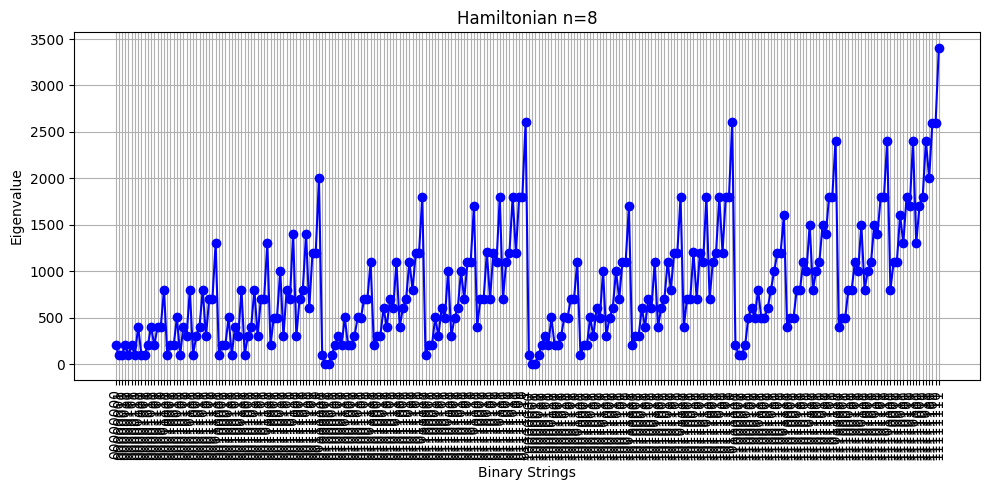

In [10]:
import numpy as np
import matplotlib.pyplot as plt

def foo(binary_string):
    # Example function: count the number of '1's in the binary string
    return get_expectation_value(initialize_state_from_string(binary_string), H_total_JSP)

def generate_binary_strings(n):
    total_strings = 2 ** n
    binary_strings = []
    
    for i in range(total_strings):
        binary_string = format(i, '0' + str(n) + 'b')
        binary_strings.append(binary_string)
    
    return binary_strings

def create_heatmap(n):
    binary_strings = generate_binary_strings(n)
    values = np.zeros((2**n, 1))  # Create an array to hold the function values

    for i, binary_string in enumerate(binary_strings):
        values[i] = foo(binary_string)

    # Reshape values for heatmap (1D to 2D)
    heatmap_data = values.reshape((2**n, 1))

    # Plotting the heatmap
    plt.figure(figsize=(10, 5))
    plt.imshow(heatmap_data, cmap='hot', interpolation='nearest', aspect='auto')
    plt.colorbar(label='Function Value')
    plt.title(f'Heatmap of the eigenvalues n={n}')
    plt.xticks([])  # Hide x ticks
    plt.yticks(range(2**n), binary_strings)  # Show binary strings on y-axis
    plt.xlabel('Binary Strings')
    plt.ylabel('Function Values')
    plt.show()

def create_2d_graph(n):
    binary_strings = generate_binary_strings(n)
    values = np.zeros(2 ** n)  # Create an array to hold the function values

    for i, binary_string in enumerate(binary_strings):
        values[i] = foo(binary_string)

    # Create x values (indices of binary strings)
    x_values = np.arange(len(binary_strings))

    # Plotting the 2D graph
    plt.figure(figsize=(10, 5))
    plt.plot(x_values, values, marker='o', linestyle='-', color='b')
    plt.xticks(x_values, binary_strings, rotation=90)  # Show binary strings on x-axis
    plt.xlabel('Binary Strings')
    plt.ylabel('Eigenvalue')
    plt.title(f'Hamiltonian n={n}')
    plt.grid()
    plt.tight_layout()  # Adjust layout to make room for x-axis labels
    ax = plt.gca()
    #ax.set_ylim([-1000, 0])
    plt.show()

# Example usage
create_2d_graph(task.num_qubits)


In [12]:
# from qiskit_algorithms import NumPyMinimumEigensolver
# def get_exact_ground(hamiltonian):
#     # Instantiate the NumPy classical solver

#     eigensolver = NumPyMinimumEigensolver()

#     # Compute the result using the eigensolver on the Hamiltonian
#     result = eigensolver.compute_minimum_eigenvalue(operator=hamiltonian)

#     # Extract the eigenvalue and eigenstate
#     eigenvalue = result.eigenvalue

#     return eigenvalue

# print(get_exact_ground(H_total_JSP))

**MUB Solver**

attempting all MUB states over the operator JSP Problem
Energy Landscape:


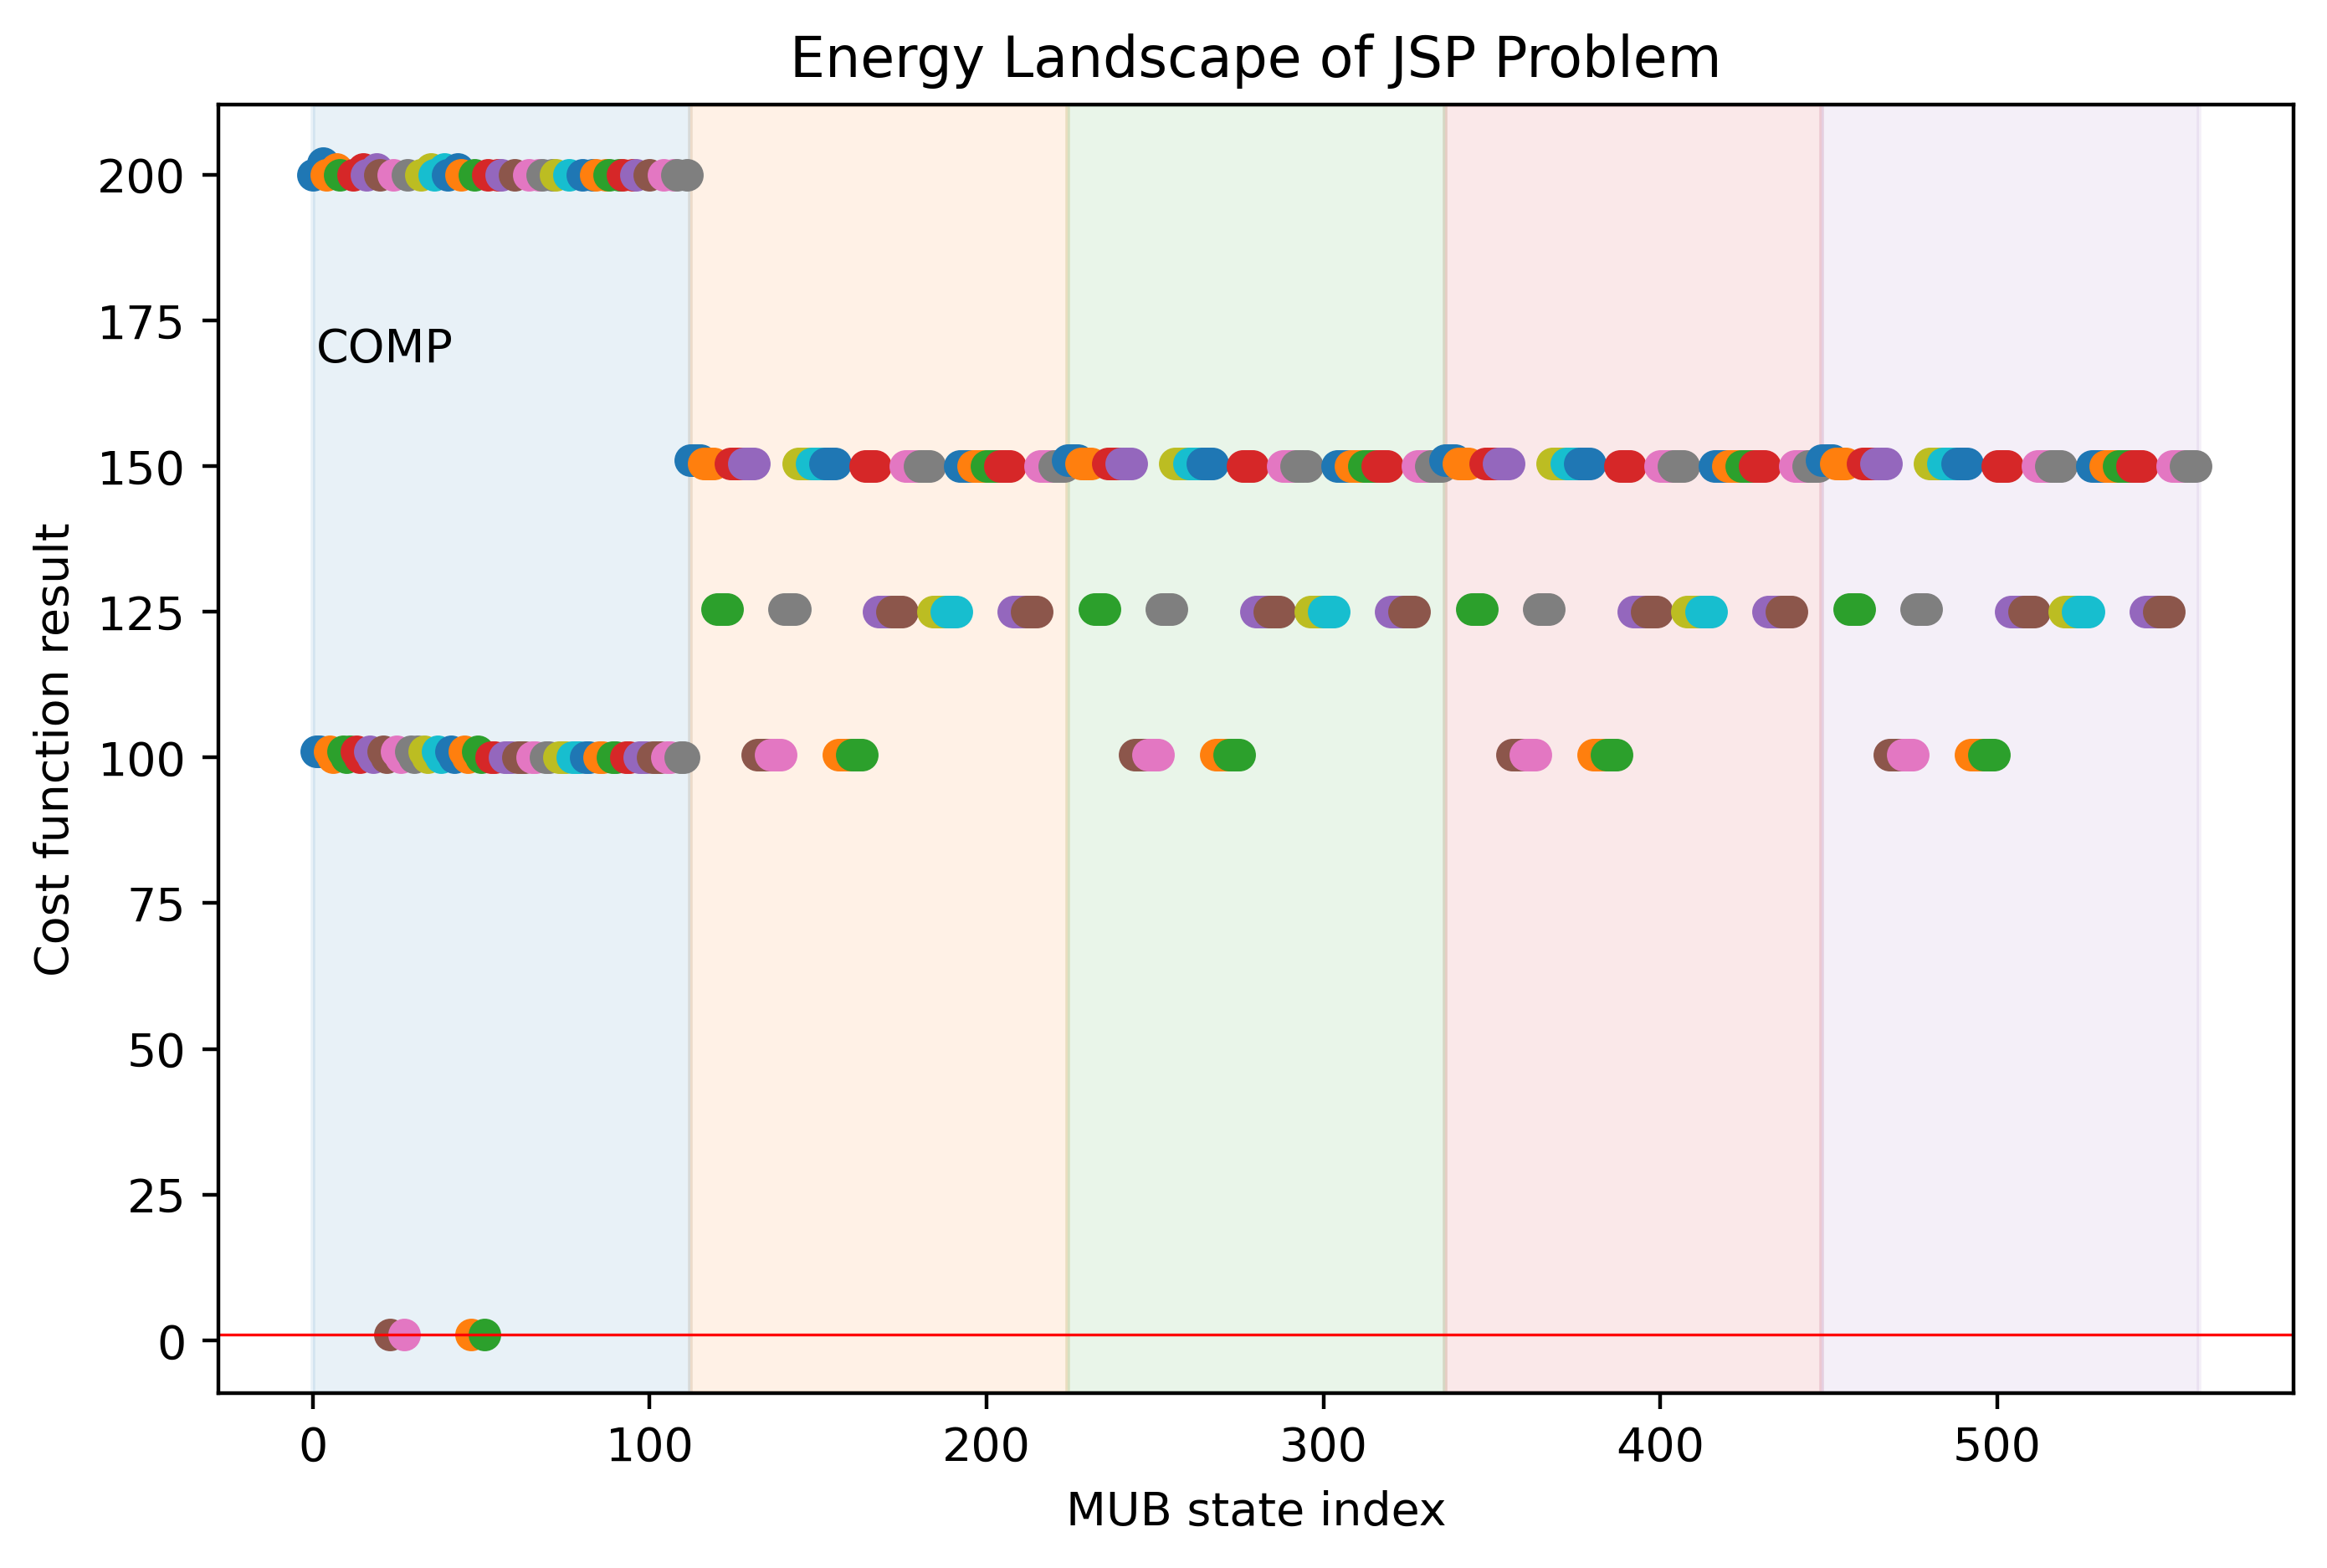

Energy Histogram:


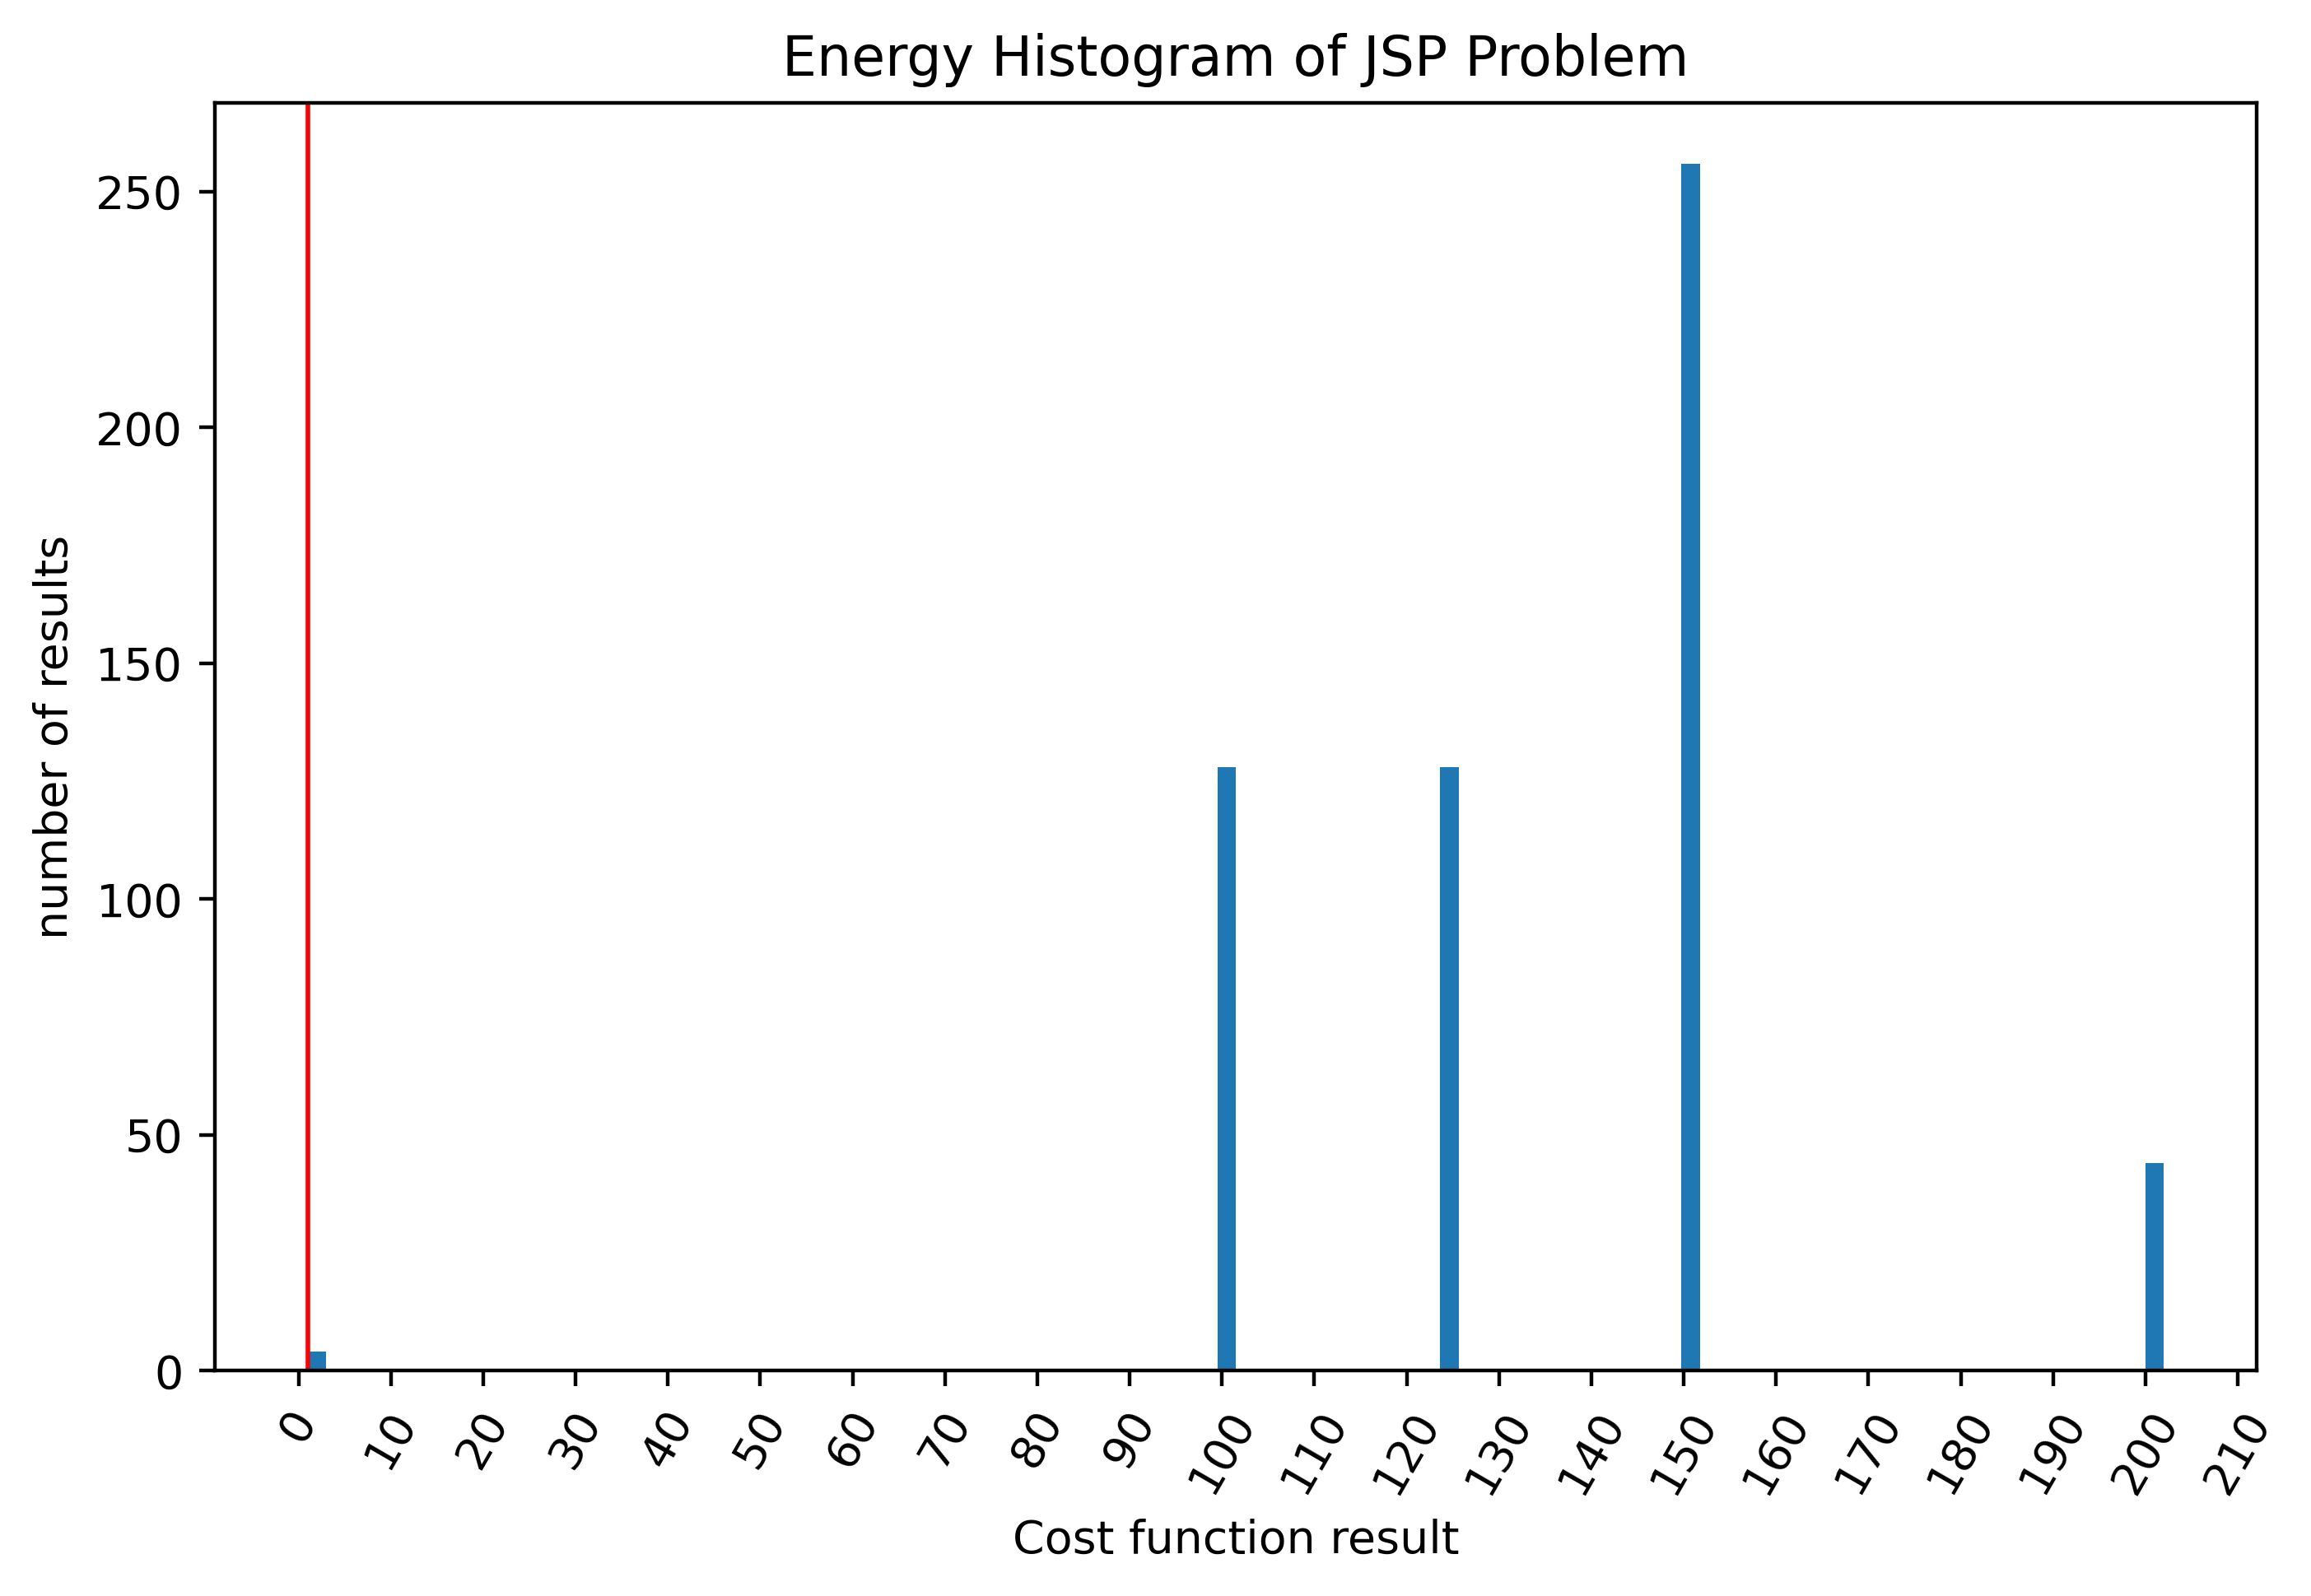

In [12]:
from experiment_utils import *

#####

landscape = run_and_record_landscape(H_total_JSP, 2, "JSP Problem")

**Ordinary VQE Experiment**

In [19]:
# '''
# Local minimum / Barren plateu parameters:
# [ 3.13187972  3.12485043 -1.44129882  4.00258695  1.8533889  -3.12973059
#  -1.08003222  1.32447117 -3.06463937 -1.37484716  3.00077516  2.21082978
#  -0.48120423 -0.65864836 -1.87660719  2.90869065 -0.01450286  0.0056704
#  -1.24626281 -1.18387608  0.84658704  0.143061    1.08438938  3.01307439
#  -2.92390669 -1.35869707  2.22695821 -1.74882826 -1.24884991  1.04685626
#   4.12047077 -0.1012765   3.14070326  0.01168365 -0.26387405 -2.08641117
#  -2.02884714 -0.67421794 -3.14378263 -0.04925929  1.80073301  3.12473985
#  -0.54310333  3.04640342 -1.34794034 -1.14862973 -0.00511756  0.30066454
#   0.011112    3.15367366  1.08694752 -1.66558516 -0.18201067 -0.91444362
#   1.57954499 -1.57272221 -0.98917923 -1.18253121 -3.31701255 -1.3658075
#   0.35165013  1.23242994 -0.80157646 -2.42548444]
# '''
# ### INITIAL THETA [1.0]*ansatz.num_parameters GETS STUCK, INITIAL THETA [0.0]*ansatz.num_parameters CONVERGES

ITERATION 0 - seed = 42
No Ansatz Given, assuming EfficientSU2
NUMBER OF QUBITS 8 8
Ground state energy: 100.43992439229655
Optimal parameters: [ 3.1456893  -0.02252359  3.1585282   2.35118778 -3.14580497  3.44931288
  1.64278245  3.29042524 -3.20484783  1.19685596 -0.53235424  3.51769124
  1.17395228  2.35499699 -1.24211861 -2.4142743   0.01394817 -3.17137321
  1.77789394  2.43191789  2.37619432 -0.00705835  4.7359008   2.42406626
  1.2605342  -0.9512338  -0.0211974  -3.18978699 -0.03596656  1.29620479
  0.65395564  2.9408496   0.01303896  0.04367802 -1.45728561 -1.53701884
 -2.41232386  0.52685126 -1.45704006  1.7467741  -0.27861913  1.87958584
  3.24797478 -0.65743706  1.46855386  1.29018942 -1.60260165 -1.26123381
  3.09787167  0.00699693 -2.19200717 -3.33385228  2.18442154  0.44675676
  1.54339136  1.44267377  1.01655645  0.96645308 -2.13102111 -1.63796476
  0.5495058  -0.66383805  0.99851612  0.67194803]


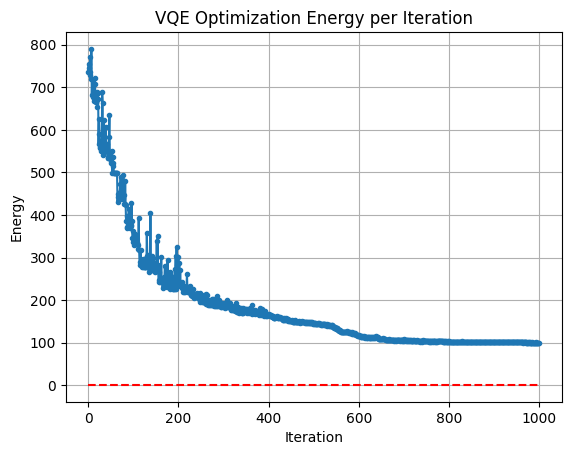

ITERATION 1 - seed = 43
No Ansatz Given, assuming EfficientSU2
NUMBER OF QUBITS 8 8
Ground state energy: 151.62284643614217
Optimal parameters: [ 1.57160128e+00 -1.57733433e+00 -3.13861523e+00  3.14205954e+00
  1.66014964e+00 -1.21478149e+00  1.57936026e+00 -6.07423665e-02
 -2.88329373e-03 -3.50174218e-03  3.19481772e+00  3.48938198e+00
 -9.56161379e-01 -1.07572198e+00  2.04141826e-01 -2.71379299e+00
 -1.57239287e+00  3.19533871e+00  1.57142613e+00  3.50412824e-03
  1.38853778e+00  4.55122408e+00  1.79344840e-01  3.18633998e+00
  3.55133031e+00 -3.63784803e+00 -1.72013409e+00  2.65085123e+00
 -1.26529395e+00 -1.20736073e+00 -1.56636796e+00  1.77997346e+00
 -3.13529847e+00  2.83508055e-03 -4.42193529e-03 -3.14640638e+00
 -1.22716400e+00  3.72437463e-01 -1.46051625e+00 -1.15328407e-01
 -2.66319081e-01 -2.48070544e+00  9.17187759e-01 -2.63024514e+00
  2.18904796e+00 -2.57085318e+00  8.93147459e-01  1.97070163e+00
 -1.49872755e+00 -3.13276015e+00 -1.10566102e-02  2.04993994e-03
  1.5948705

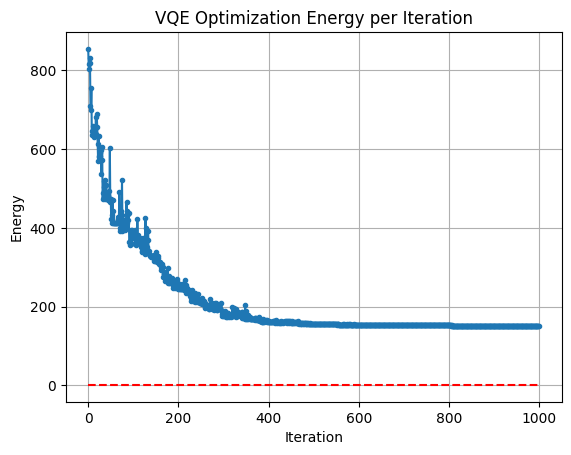

ITERATION 2 - seed = 44
No Ansatz Given, assuming EfficientSU2
NUMBER OF QUBITS 8 8
Ground state energy: 100.54193456356482
Optimal parameters: [-3.14309774 -2.75669267 -0.14313004  4.6409293  -1.57359812  3.05870935
 -1.57901969  0.01696419  2.1459979   1.60211374  3.1381184   0.10159499
  3.10103835  3.38216154  1.4019473  -3.44199529  1.42258524  3.15611973
 -0.05611767 -1.6092175  -1.87034515  1.66149084 -3.12218692 -0.01011297
 -0.15624574 -2.15533951  3.55564898 -0.4507099   1.60562122  2.06147129
 -1.61406036 -2.93314874  2.81007193 -0.26324924  0.02607101 -1.55410423
  3.17061017  0.33802805 -0.06762389 -1.5573058   2.97767886 -0.00733823
  1.2487679   2.11938746 -1.09934126  3.54552986  3.1838676   0.04290075
  1.64526188 -0.42071168  1.50726506  0.05549047 -0.36080982  2.79331454
  0.58259838  1.40827457  3.05141558 -1.35284946 -1.50144    -1.59761427
 -0.87619111  1.27986173 -1.28086774  1.91830942]


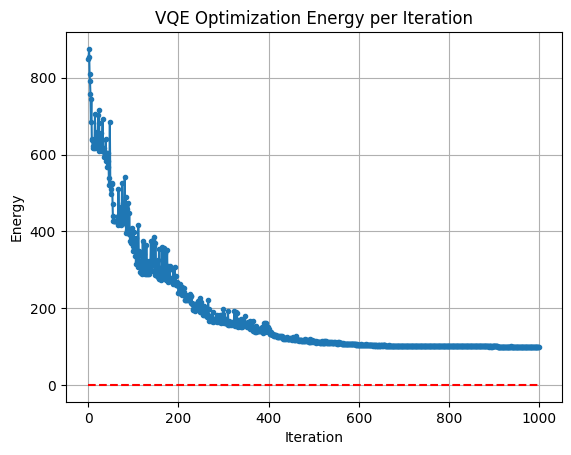

ITERATION 3 - seed = 45
No Ansatz Given, assuming EfficientSU2
NUMBER OF QUBITS 8 8
Ground state energy: 41.45881366877372
Optimal parameters: [ 1.70181191  0.01559266  1.63829718  1.62036694  0.0326533   3.30203937
  1.82680559  0.21150423 -0.14022394  1.20418738  3.11779072  3.14486988
  2.83223419  1.3129277   3.22753003 -0.4213034   3.33587341  3.4300117
  1.53351117 -3.20015528 -1.55467312 -1.75315281  2.22506761 -2.53353018
  1.13495534  0.85895212 -0.60571387 -1.63010562 -2.15549461 -2.99122556
  1.46974031 -1.51104664  1.55348882  1.49728421  0.06430768  3.21744733
  0.02812891 -3.12760007  0.03711502 -0.57117419 -1.75538465  3.29106397
 -0.00659853  0.75408942 -2.30300674 -3.14039365  3.07027892  1.63975525
  0.92021379  1.65734367 -1.56904173  1.30663445 -0.04171161  1.51073821
 -1.35966363 -0.39545399  1.37728419  1.46979904  0.1101862  -2.86627495
 -0.32377473  2.83144937 -2.32973499  2.06874014]


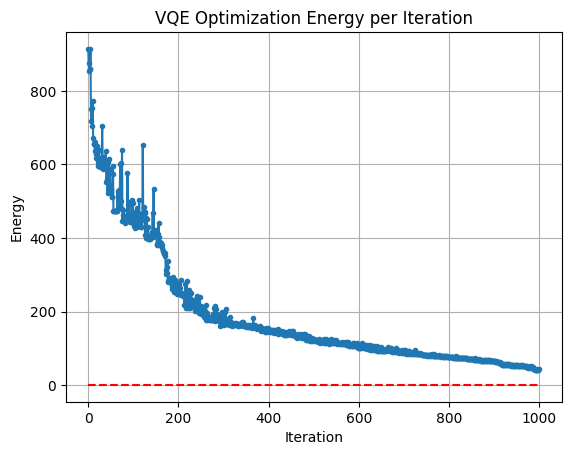

ITERATION 4 - seed = 46
No Ansatz Given, assuming EfficientSU2
NUMBER OF QUBITS 8 8
Ground state energy: 36.87209622203704
Optimal parameters: [ 3.13459426e+00 -3.06361470e+00  4.03487341e-02  1.72159359e+00
  4.43106149e+00 -1.60415314e+00  2.75411481e-01  1.97739665e+00
 -1.08207039e+00  3.55822467e+00  3.45491809e+00 -8.09862400e-04
  4.29117541e+00 -3.08623954e+00  2.11332206e+00  1.74662462e+00
 -3.19126039e+00 -1.12724717e+00 -4.22798579e-02 -2.25205086e-01
 -2.48903962e+00  3.38687134e+00 -9.10177426e-01 -2.03993999e+00
  9.04997759e-01  9.09100695e-01 -4.89801782e-01  3.40230574e-02
 -3.23250391e+00  1.59553918e+00  1.47196857e+00  1.94099153e+00
 -2.18040718e-03  3.20155975e+00 -7.28102204e-02  1.40917802e+00
 -3.01314653e+00 -1.76711282e+00 -3.06066446e+00  1.08092843e-01
  1.74777778e+00 -2.40527215e+00  2.14536347e-01 -1.84708869e+00
  1.20600070e+00  3.24074419e+00  4.07518930e-01  2.30686029e-01
 -1.30298803e-01 -1.12252982e+00  2.25108338e-02 -1.89644483e+00
 -3.25510266

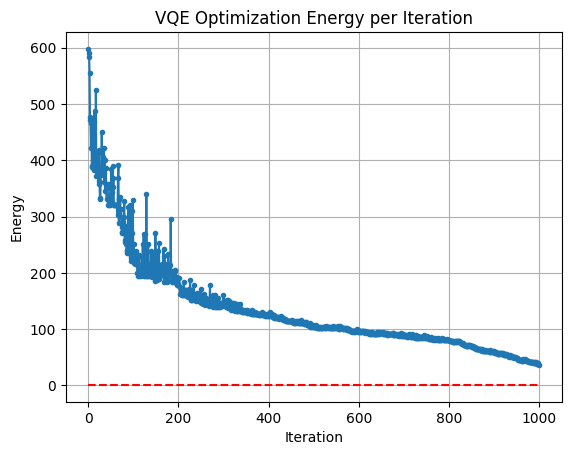

ITERATION 5 - seed = 47
No Ansatz Given, assuming EfficientSU2
NUMBER OF QUBITS 8 8
Ground state energy: 104.71711436895765
Optimal parameters: [-3.53076019e-02  3.14402033e+00 -1.00248698e+00 -1.35485106e+00
  3.12804394e+00  4.60701061e-03 -8.04130361e-01  4.64737392e+00
  1.11971976e+00 -1.01081029e+00  2.21562627e-01  2.14527823e+00
  1.07752341e+00  1.75301120e+00  9.58296235e-01 -9.95203167e-03
 -9.35353657e-02  3.18052045e+00  2.24297529e+00 -1.87564360e+00
  5.44360222e-01 -3.08685390e+00  9.33033014e-01 -2.93861471e+00
  3.48333091e+00  1.53235273e+00  2.14975171e+00  2.71447194e+00
  2.25407510e+00  6.55535142e-01  1.22289972e+00 -1.56867650e+00
  2.76092262e-02  3.15467290e+00  3.87221204e+00  2.03971602e+00
  2.61424271e-01  3.29682203e-01  1.44848538e+00  3.42894649e+00
  1.96278904e+00  3.29334030e+00 -2.95028249e+00  5.23053926e-01
 -1.63359241e+00 -1.67994159e+00 -3.31929579e+00  1.71515918e+00
  7.46872019e-03 -3.05489636e+00  4.62418783e+00  1.32448298e+00
  1.2100206

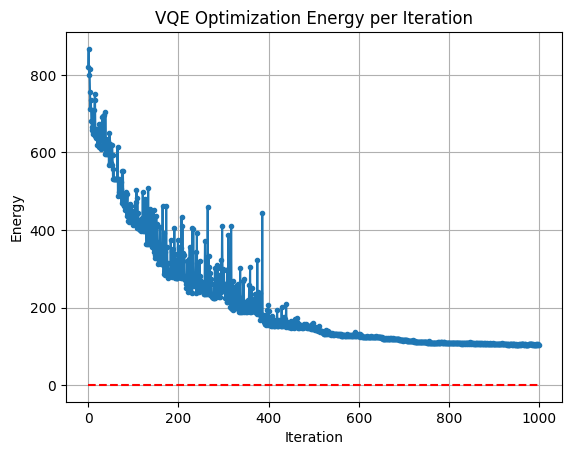

ITERATION 6 - seed = 48
No Ansatz Given, assuming EfficientSU2
NUMBER OF QUBITS 8 8
Ground state energy: 101.1586284076935
Optimal parameters: [-5.36846976e-01 -4.14665552e-03 -1.69207561e-03  1.36866127e+00
  9.00247937e-01  1.55016045e+00  1.58800549e+00  2.07188251e+00
  1.90221389e+00 -1.71347314e+00 -1.52205151e+00 -2.90373997e+00
  1.19867752e+00 -2.62591386e-02 -1.56051483e+00  6.12437375e-02
  1.39463215e+00  2.53289286e+00  1.57806806e+00 -2.87575626e-01
 -3.14195563e+00  1.56255868e+00  1.57139677e+00  6.60650287e-03
 -5.52220336e-01  1.71204324e+00  3.14744676e+00 -2.20174565e+00
 -1.74922016e+00 -1.32146825e+00  2.91437470e+00 -3.13036686e+00
  7.36901927e-01 -1.09284908e+00  1.56451809e+00  1.57446771e+00
  2.51803064e+00 -7.68827945e-01 -1.57428727e+00  5.82606538e-02
  4.13511938e-01 -5.74223865e-01 -3.02644568e+00  4.89932157e-01
 -2.72600036e+00  3.13002682e+00 -3.16911706e+00  4.98678905e-01
  1.56320605e+00 -2.82734996e+00 -1.38317377e+00  3.17440167e+00
  9.81689753

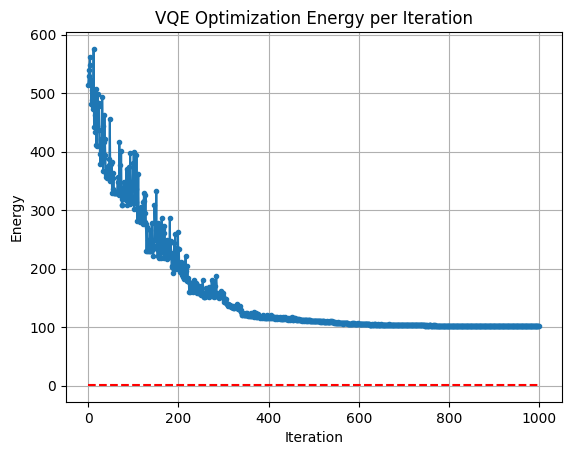

ITERATION 7 - seed = 49
No Ansatz Given, assuming EfficientSU2
NUMBER OF QUBITS 8 8
Ground state energy: 101.30850630044398
Optimal parameters: [-4.19755447e-04  1.54437740e+00  7.77448650e-04  2.42405141e-01
 -5.76970618e-03 -3.13466400e+00  2.10948925e+00  3.79690762e+00
 -1.35312042e+00 -3.02699034e+00  3.45008891e+00  9.81947471e-01
  1.94815804e-02  2.58927309e+00  2.82893478e+00 -1.27118554e-01
 -3.13977297e+00 -2.72370307e+00  2.03807936e+00 -3.07055469e+00
  1.59360409e+00  9.46357721e-03 -1.35660048e+00 -2.84796875e+00
  1.50038071e+00  2.64702647e-01  2.42294693e+00  2.05416484e+00
  1.95702029e+00 -1.35163994e+00 -2.85642087e+00  4.33439078e-01
 -3.15178049e+00 -3.74260665e-01  1.46298261e+00 -1.49453428e-01
  3.05273720e+00  1.82112516e-02  1.40457906e+00 -7.48590508e-01
  1.22489425e+00 -9.18424786e-01 -5.93838048e-01  3.25063708e+00
 -1.88117484e+00  7.25617193e-02 -5.89061796e-02  2.92356463e+00
 -4.13428241e-02 -1.69062978e+00  2.21661233e+00 -1.36795177e+00
  1.6223440

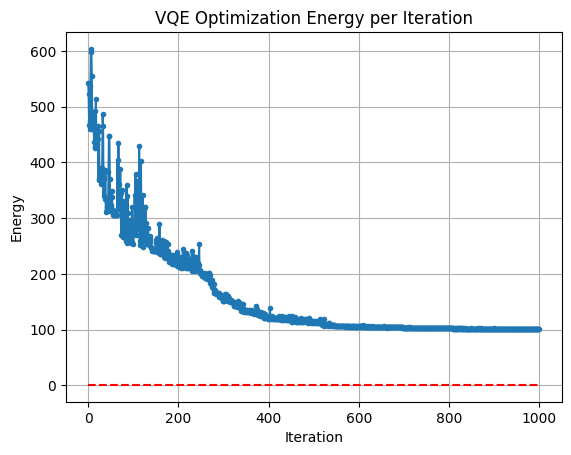

ITERATION 8 - seed = 50
No Ansatz Given, assuming EfficientSU2
NUMBER OF QUBITS 8 8
Ground state energy: 10.547026065081049
Optimal parameters: [ 2.7200765   3.23348772  0.38580581  4.68632384 -1.6777817   2.23204043
 -1.07025086  1.41300703  0.38376001 -2.21965789  4.0075337  -0.29035372
 -1.63242495 -1.31566085 -1.88272415  3.22617954  0.83102434  1.89111523
 -1.92948927  0.9223347  -1.58054951 -1.57712918  0.94369467 -3.21179235
 -0.72739187 -3.05913499 -0.12931736 -1.05626319  1.0551484  -0.2862419
  0.9050211  -3.0831565   0.77670054  2.09823912  1.72726443 -2.71772473
 -1.79294836 -0.32455781 -0.73996487 -0.12337677  3.47843911  2.90659716
 -4.3369391  -0.37301105  2.44128946 -1.45504139 -0.56295057  0.07975453
  1.59695335 -1.40300408  3.14621015 -2.11455776 -1.27272187 -1.56969322
 -1.42017167  1.48682726 -0.53706743  1.50228674 -0.03094895 -1.88431163
  2.25887541  2.47320883 -2.77468413 -1.55264244]


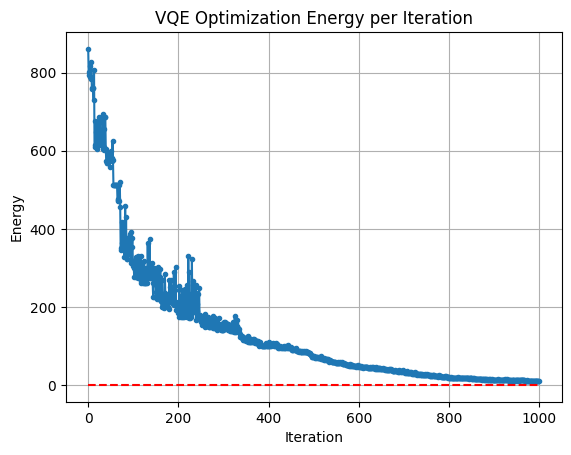

ITERATION 9 - seed = 51
No Ansatz Given, assuming EfficientSU2
NUMBER OF QUBITS 8 8
Ground state energy: 8.993252026481986
Optimal parameters: [ 3.14321067e+00  1.72028640e-01 -1.50907437e+00 -1.63293127e+00
  3.19558470e+00 -1.54793972e+00  1.36383594e+00  2.00698161e+00
 -3.83757440e-01  3.87350995e-01  3.10495010e+00  3.23936560e+00
 -1.63550374e+00  4.27122766e-01 -3.98307210e-01  4.70774598e+00
 -4.30087777e-02  9.99136106e-01  4.72885020e+00  1.14056291e-01
  1.57147230e+00 -1.42748499e-01 -2.02653419e+00 -3.39781186e+00
 -1.99707535e+00 -9.50131091e-02 -6.27655748e-01 -8.29813129e-01
 -5.77444618e-01 -1.12596719e+00  1.20716129e+00 -1.43083432e+00
  2.46161036e-04  1.69452458e+00  1.51709477e+00 -3.13731278e+00
  3.09305946e+00 -1.57811876e-03 -2.09352394e+00 -3.51566806e+00
  1.23953626e+00  2.61194876e+00  4.26876596e+00 -2.00754007e+00
  2.55695235e+00 -1.42417514e-02  1.48715216e+00 -1.36537138e+00
 -3.02739444e+00 -1.68180906e+00 -2.52471976e+00 -8.04490316e-01
 -3.07668562

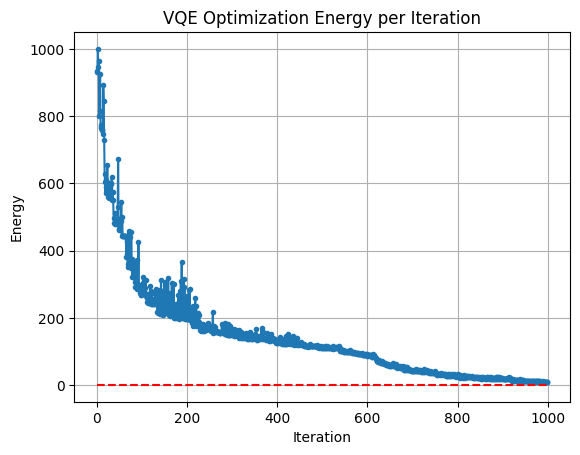

ITERATION 10 - seed = 52
No Ansatz Given, assuming EfficientSU2
NUMBER OF QUBITS 8 8
Ground state energy: 91.58029212133815
Optimal parameters: [-0.01302251 -0.02054845 -0.00792172 -3.14645204  0.47036942  3.92937869
  0.1896797  -3.01816688 -0.12132171  4.09535088  2.65753251  2.05721796
 -1.39875036 -2.18314831  2.40711694 -1.23660503 -0.01636787 -0.88446252
  1.55734608 -1.61487112 -0.04213743  1.77560975 -0.78644639  1.49996338
  0.6492652  -1.69889669  3.12895756 -0.00834433 -0.07025348 -0.54607807
  3.58444297  0.13642661 -0.08485797 -0.82899697 -1.57381867  1.56088584
  1.59321761 -1.17396035 -0.57388932 -3.20458317 -2.44432513  3.00492411
  0.22653888  1.23230749  0.53451192 -1.24149396  1.1293066   3.16880337
  0.05845164 -1.50549815  1.48009064 -0.01420507  0.07526356 -1.66012007
  0.81694497  1.76364786 -0.96062046  1.41130462  4.14499871  0.15274735
 -4.33847247  0.70911888  0.62705841  1.35657854]


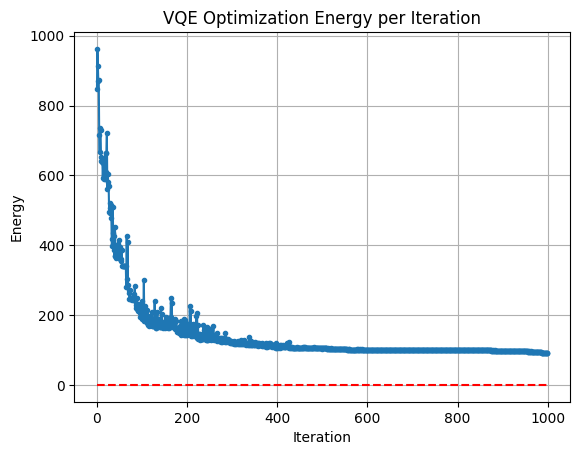

ITERATION 11 - seed = 53
No Ansatz Given, assuming EfficientSU2
NUMBER OF QUBITS 8 8
Ground state energy: 11.632801646815246
Optimal parameters: [-1.5657938   1.30652683 -0.38017774  3.13867468 -1.61280637 -0.02296443
  1.53986794  1.93231383  3.10335988  3.49957659 -0.69864472 -2.03018892
  0.38198597  1.55019178 -1.23496747  1.58101983  1.5612573   1.62809355
 -1.71862263  1.54205812 -0.99889343 -3.79010976 -3.23893328  1.44213091
  2.7473872   2.58733013 -0.37742061  3.13041785  4.10989196 -0.73046148
 -2.96876064  2.87616918  1.40970057  3.12945351  2.63080436 -2.92266701
  3.1296135   1.53171081  0.00733448  1.92807177  1.39709249  0.00595338
 -0.44523264 -2.9402151  -3.11022842  2.70302766 -0.01021     1.6340738
  1.62900548  1.71105111  0.89833148  1.49813999  1.54358278  1.58477168
  1.17010114  1.4218546   3.18537931 -0.91075539 -0.47713624 -1.70275372
 -1.63701618  0.55822718 -0.58230885  2.05241398]


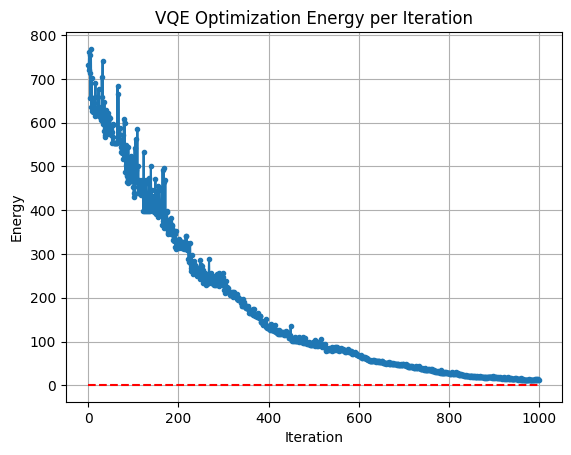

ITERATION 12 - seed = 54
No Ansatz Given, assuming EfficientSU2
NUMBER OF QUBITS 8 8
Ground state energy: 108.89929418641827
Optimal parameters: [-3.18311174 -0.32081939 -1.0369949   1.60632135 -3.14210754  0.05857156
  1.5903545  -1.58566909  2.71139092  4.32251231  0.02786987  2.45848274
 -0.39038114  0.34611015  1.05988395 -0.69640225  1.58019085  1.63580831
 -1.61372297  0.96731362  2.77834694  3.04142244 -3.06349999 -2.21672839
  0.06074349  1.34625498  3.04063697  2.3780424  -2.41991927 -0.96377771
 -3.75902652  0.17399479  1.56855941 -1.62907501 -0.11629206 -2.15115513
 -3.30395564  0.89473588  3.11159164  0.05429624 -0.88463357  2.34483419
  2.77262256 -0.07772312  1.58477741  1.43749827 -2.35528203 -2.20702785
 -1.43822517  0.05792106 -1.55738946  1.47375469  4.32897891 -2.39528514
 -4.69201396  0.90086282  1.39990727 -1.44931945  1.96578169  1.692699
  1.75234415 -2.25273557 -1.47987384  4.19969984]


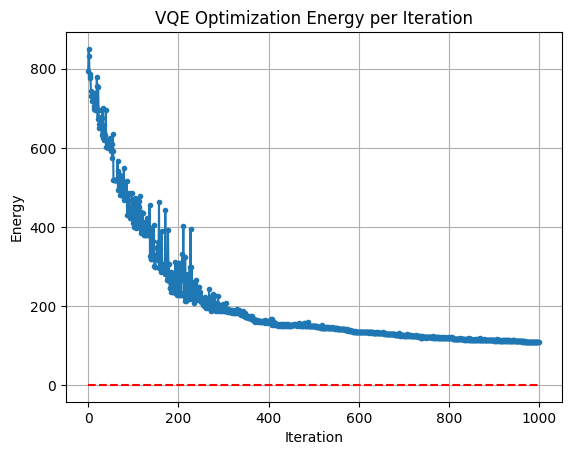

ITERATION 13 - seed = 55
No Ansatz Given, assuming EfficientSU2
NUMBER OF QUBITS 8 8
Ground state energy: 100.26826230017288
Optimal parameters: [ 3.14184881e+00  3.14600448e+00  1.68952817e-02 -1.98421862e+00
  3.63388001e-02  3.14927023e+00  1.03316724e+00  2.66319282e+00
 -3.77972767e-01  1.33885542e+00 -1.87804339e+00  5.33228368e-01
 -3.97564915e+00 -6.30925973e-01 -1.81532211e+00  3.78920680e+00
  3.36494690e-03  1.19694960e-03  3.10925044e+00 -1.14097717e+00
 -8.50758525e-01 -6.34756406e-02 -3.20345534e+00 -3.67443059e+00
 -1.26513811e+00  9.81958884e-01  1.22061374e-01 -2.78312199e+00
 -1.68453890e-01  2.06499442e+00 -1.24389929e+00 -2.02319680e-01
  2.88465502e-04  3.14088311e+00 -9.12731325e-02  1.02185049e+00
 -1.11189750e-01  3.14701870e+00  6.18611138e-01 -1.63661736e+00
  3.27686348e+00  2.54740723e+00  2.52478639e+00 -2.43568227e+00
  1.19670960e+00  4.02844741e+00  3.20321023e+00  2.83769804e+00
 -3.13525322e+00 -3.15082993e+00  1.42386832e-01 -1.07095480e+00
 -1.962653

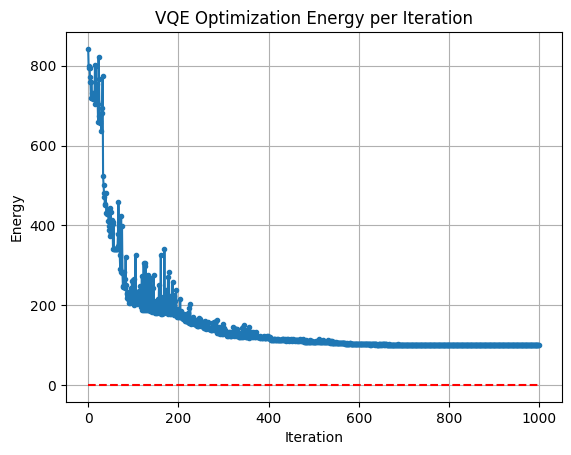

ITERATION 14 - seed = 56
No Ansatz Given, assuming EfficientSU2
NUMBER OF QUBITS 8 8
Ground state energy: 101.37228461744327
Optimal parameters: [ 3.74277144e-02 -1.39792406e+00  3.59364903e+00  2.09590245e+00
  2.03583572e+00 -1.57367707e+00  3.15749188e+00 -6.56601834e-01
  2.92694515e-01 -1.84838394e+00 -2.26635853e+00  2.46639121e+00
  1.51638294e+00 -3.25373595e+00  3.15959120e+00  2.58696919e+00
  8.66647514e-03 -2.22685480e+00 -1.68786303e+00  1.52343288e+00
 -1.52241532e+00 -2.87244511e-01  4.54188340e-01 -9.94099030e-01
  4.69406470e-01  1.94219070e+00 -7.98516831e-02  2.67712811e+00
  3.39779436e+00  1.55704594e+00  1.45519984e+00 -3.18822717e-01
  6.24901756e-02  3.44398408e+00 -2.24193875e+00  1.27153382e+00
  2.92735061e+00 -1.09800535e-01  1.42694799e+00  8.37865014e-03
  2.50274283e+00 -1.14137640e+00 -1.28474204e+00  1.97297943e+00
 -5.87227206e-01 -5.10643122e-01  2.09022240e+00  2.74722547e-03
 -4.33684079e-02 -1.30642627e+00  1.03907909e+00  1.46652129e+00
 -7.238221

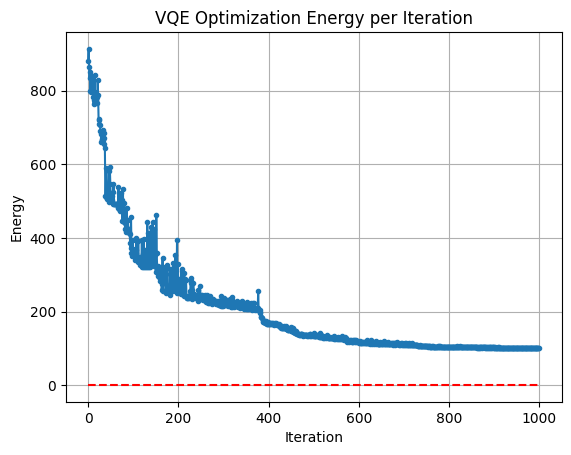

ITERATION 15 - seed = 57
No Ansatz Given, assuming EfficientSU2
NUMBER OF QUBITS 8 8
Ground state energy: 2.116596984504319
Optimal parameters: [ 1.97553093e-03 -1.04266307e-02  3.13465750e+00 -4.26390468e-04
 -3.89857197e-02 -2.75780799e+00 -6.87673076e-01  1.50774971e+00
 -1.33178570e+00 -1.05102177e+00  4.01582281e-01  1.25929333e-02
  3.56771268e+00  4.71513501e+00  1.39612115e-01  1.40378627e+00
 -3.39104054e+00 -1.57163646e+00 -1.47151271e-02  1.50097721e+00
 -5.23437459e-01  1.57427434e+00  1.77502970e+00  9.61554975e-01
  2.74385117e-02  7.84364193e-03 -2.25594125e+00  3.14411059e+00
  3.14214966e+00  1.64362737e+00 -1.68023291e+00  1.65664001e+00
  3.22759015e+00  1.64158788e+00 -1.64899024e+00  1.56431329e+00
  1.57474229e+00 -1.77910505e+00  3.18082370e+00  6.49639654e-01
 -8.27077859e-01 -2.24032484e+00  2.25320431e+00 -2.76625649e+00
  2.76948983e+00 -2.00158157e+00  8.21722331e-01 -2.83779383e+00
 -8.11171222e-02  1.50325926e+00 -6.44437847e-03  1.55584680e+00
 -5.9476472

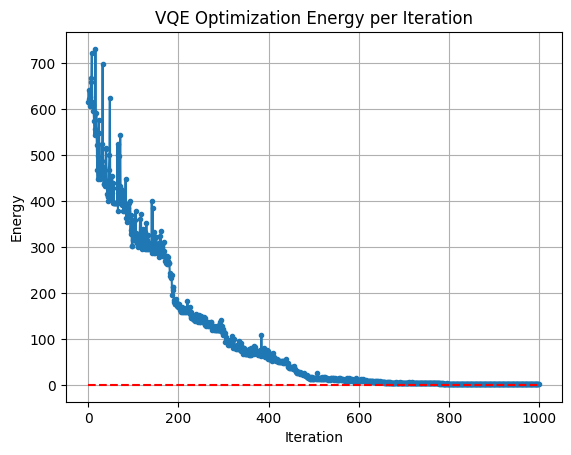

FOUND GLOBAL MINIMUM
ITERATION 16 - seed = 58
No Ansatz Given, assuming EfficientSU2
NUMBER OF QUBITS 8 8
Ground state energy: 2.63561514793511
Optimal parameters: [-1.58201702e+00  1.58747806e+00 -1.55158476e+00 -1.65811077e+00
  2.50674583e+00 -1.57400816e+00 -2.20687685e+00 -1.49028763e+00
  1.23589801e-02  3.14012064e+00 -1.28342513e-03 -4.62723662e-03
  3.68987516e+00 -4.02040082e-02 -1.21098200e+00  1.69229397e+00
  4.71594930e+00  1.57046914e+00 -1.57912378e+00 -1.55913887e+00
  1.57673407e+00 -3.48376685e+00  1.20247912e+00 -3.29180721e+00
 -1.71967734e+00  2.79878172e+00 -1.42235269e+00  9.36213745e-01
 -3.16303819e+00 -1.50449936e+00 -1.39914251e+00 -1.79789100e+00
 -9.05370796e-01 -1.21009509e-02  3.13391148e+00  3.13537389e+00
  3.21311966e+00 -2.54346222e+00  5.77520944e-01  8.56569917e-01
 -2.04440396e+00 -1.13974702e-01  2.84074921e-01  2.36919556e+00
 -1.10669399e+00  2.96582441e+00  1.21402352e+00  2.79966394e+00
  2.69164507e+00 -4.56385112e-01  3.14638573e+00  3.1419

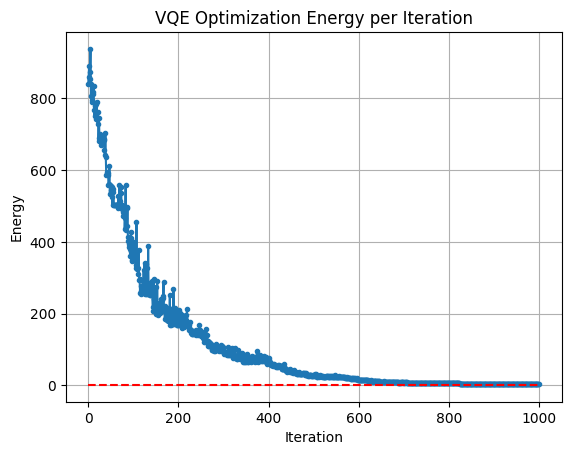

FOUND GLOBAL MINIMUM
ITERATION 17 - seed = 59
No Ansatz Given, assuming EfficientSU2
NUMBER OF QUBITS 8 8
Ground state energy: 10.176197347560565
Optimal parameters: [-2.31251281e-03  3.14532707e+00 -1.49125481e+00  1.44112040e+00
 -1.40022107e-02 -1.57326347e+00 -1.53148529e+00  3.04614349e+00
 -1.77947333e+00  1.66267390e+00  6.61353331e-01  1.68844402e+00
 -1.92129346e+00  1.18317935e+00  9.62774828e-01 -2.33732617e+00
 -1.66520049e+00 -1.54452409e+00 -5.96721626e-01 -1.23111600e-01
 -1.24271711e+00 -2.84411674e+00  2.25620520e+00  1.77560672e+00
 -9.31858760e-04  3.42007434e-02 -2.46387078e+00  1.50549286e+00
  3.09842907e+00  2.75758095e+00  1.56002101e+00  3.19028634e+00
 -1.44389220e+00 -1.54134766e+00  4.72662900e+00 -1.31047723e+00
  2.11144619e-01  3.15000023e+00  2.55474888e+00 -1.54061278e+00
 -2.61478769e+00 -8.04947722e-01 -3.92403051e-01 -3.59018445e+00
 -2.14136522e+00  5.20941578e-02  1.45776967e+00  2.08937358e+00
  1.63272285e+00 -3.24001510e+00  3.74427568e-02 -1.61

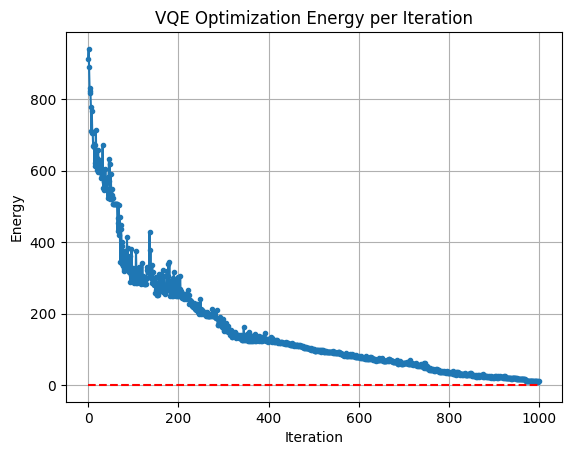

ITERATION 18 - seed = 60
No Ansatz Given, assuming EfficientSU2
NUMBER OF QUBITS 8 8
Ground state energy: 1.8390328162624558
Optimal parameters: [ 1.36407264e-02 -3.14521082e+00 -3.14346392e+00  3.14183561e+00
  3.14470633e+00  1.55509468e+00  2.92437988e+00  4.60148548e+00
 -5.88861975e-01 -1.03050307e+00  2.02978837e+00 -9.87597698e-01
 -1.07404668e+00  2.27092644e+00  1.04762166e+00  5.83288468e-01
  1.59831537e+00 -1.64217646e+00  1.12042012e+00 -1.67726750e+00
 -1.57399574e+00 -1.75816786e+00 -3.75499227e+00 -1.31294320e+00
  3.52976126e+00  3.14289567e+00  3.16174909e+00  3.12211920e+00
  7.83368673e-03  2.55053594e+00 -2.39287734e+00 -3.77632319e+00
 -1.70925531e+00 -1.56085457e+00 -1.58510870e+00  1.58103356e+00
 -1.56160344e+00  1.56738993e+00 -1.86127763e+00  1.11911985e+00
  4.35934234e+00 -1.58654585e+00  3.49629621e+00 -1.88938562e-01
  2.17072753e+00  3.95374764e+00  4.02321091e-02 -7.16437287e-01
 -1.66891962e+00 -3.09381167e+00  3.06597737e+00  4.26670645e-01
  3.228043

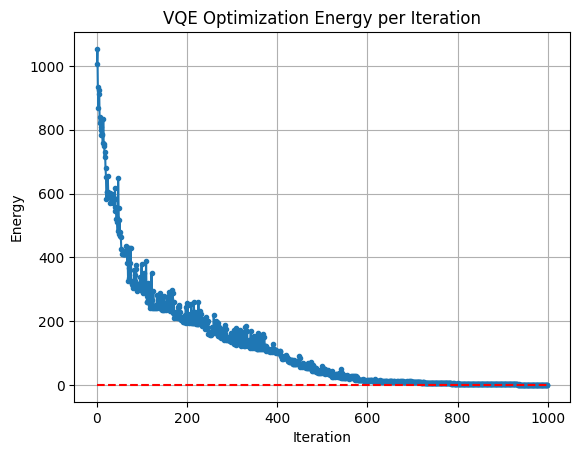

FOUND GLOBAL MINIMUM
ITERATION 19 - seed = 61
No Ansatz Given, assuming EfficientSU2
NUMBER OF QUBITS 8 8
Ground state energy: 107.49466766587449
Optimal parameters: [ 1.78111743e-03  2.01454259e+00  1.26045000e+00  3.22174319e+00
  9.23481268e-03  3.38298251e+00  3.89573866e+00  3.20749931e+00
 -2.68312881e+00  7.03303746e-01  9.86643698e-01  9.88193675e-01
  9.40330846e-01  3.22281551e+00 -5.31178822e-01  7.70000356e-01
 -1.52083969e+00  3.20325949e+00 -1.43948817e+00 -3.09585903e+00
  3.19673970e+00  1.99043360e+00  2.04515833e+00  1.34323962e+00
 -3.13564500e+00  4.15304881e+00  9.43223468e-01  2.17354551e+00
 -1.05611211e+00 -1.79344237e+00  1.35578140e+00  2.96202599e+00
 -1.60623982e+00 -1.49928427e+00 -1.06909828e-01  9.79213566e-02
 -1.48078298e+00 -2.05211216e+00 -2.98518927e-01  7.44320115e-01
 -7.96078469e-01  1.96212340e+00 -1.21195906e+00 -4.82198344e-01
  4.51118843e-01  2.65280063e+00  1.96907232e+00 -3.44230344e-01
  4.44822314e+00 -4.73426904e-02 -2.26931362e+00  1.50

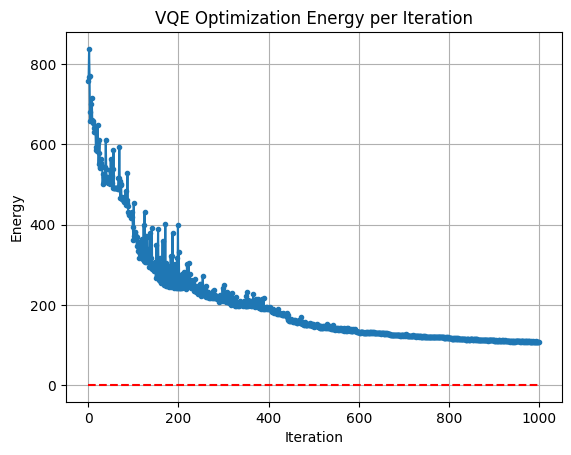

ITERATION 20 - seed = 62
No Ansatz Given, assuming EfficientSU2
NUMBER OF QUBITS 8 8
Ground state energy: 107.53889062546197
Optimal parameters: [-1.43989889e-02  1.89323757e+00  1.76054868e+00  1.12387665e-04
  2.97852592e+00  3.13202665e+00  1.00590748e+00  3.27897973e+00
  3.34952035e+00 -2.85573167e+00  2.54134588e+00 -2.16445212e+00
 -1.60036160e+00  2.19873841e-01 -3.32541374e+00  7.72271395e-02
 -9.01619084e-03 -1.09533231e+00  2.58293725e+00  2.06917202e+00
  3.14057745e+00  1.34117069e-02  1.37180850e+00 -2.76062329e+00
 -1.44536065e+00 -3.74673355e-01  1.57990059e+00  3.24345453e-01
 -2.03727811e+00  6.25610017e-01  1.61958165e+00  1.13038470e+00
  3.17484437e+00 -3.47877323e-01 -5.03706382e-01  3.29605257e+00
  2.99450750e+00  1.57482372e+00 -3.47158094e+00 -2.42687705e+00
  4.12911888e+00 -2.53204665e-01  2.04506369e+00  1.76922782e-02
  3.07494761e+00 -3.13332828e+00 -1.03242057e-01 -1.29927222e+00
  3.13363308e+00 -9.04081935e-01  8.29259609e-01  1.85290854e-01
 -1.018100

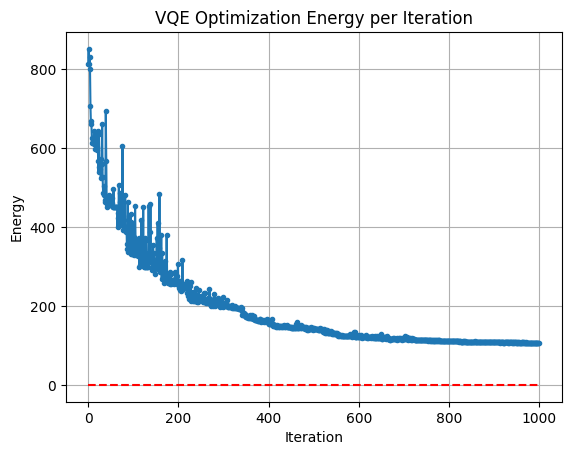

ITERATION 21 - seed = 63
No Ansatz Given, assuming EfficientSU2
NUMBER OF QUBITS 8 8
Ground state energy: 3.9255949543623827
Optimal parameters: [ 2.22445668e+00  3.12650993e+00 -3.16335785e+00  5.44030633e-02
 -3.21897635e+00 -3.16414688e+00 -1.41245021e+00 -2.72729054e+00
  1.05012243e+00  1.77685430e+00  1.03837315e-01  7.49872704e-01
 -2.85850628e+00 -2.07580894e-01 -2.26840686e+00 -1.37766657e+00
  4.82443537e-03  2.31756899e-02  1.58162184e+00  1.55570171e+00
 -1.59891019e+00  1.52401714e+00 -3.56154217e+00  1.35930352e+00
 -9.19385147e-01 -2.36262802e+00  3.14600294e+00  9.86208661e-03
  8.67981653e-03  3.15006920e+00  7.76697729e-01 -8.70114187e-01
  1.92629566e+00  6.22176148e-02  1.55804460e+00 -1.57592287e+00
 -1.52964508e+00  2.10988281e+00  1.10653363e-01  1.28332257e+00
 -7.75384901e-01 -7.99417041e-01 -5.26379007e-01  3.68552349e+00
  1.71442966e+00 -3.05083653e+00 -3.10972164e+00 -1.48898895e+00
 -2.77575842e-01 -2.54020305e-01 -3.11994262e+00 -2.23870107e-03
  3.196860

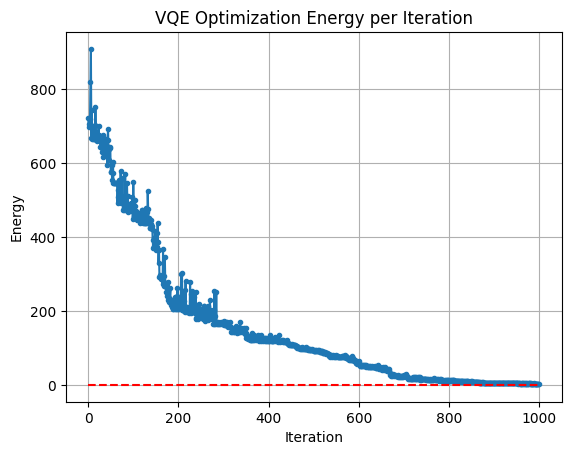

FOUND GLOBAL MINIMUM
ITERATION 22 - seed = 64
No Ansatz Given, assuming EfficientSU2
NUMBER OF QUBITS 8 8
Ground state energy: 52.50413292042708
Optimal parameters: [ 3.13659991e+00  1.38002971e+00 -3.15558855e+00 -1.55411368e+00
  3.14937865e+00 -3.13251864e+00  2.86882710e+00  1.61914790e+00
 -3.21103106e-01 -3.07060838e+00  4.92241665e-01  8.19124735e-01
  2.43490674e+00 -2.67702217e+00  2.18193450e+00  2.97415292e-01
  9.57999797e-02  2.60919352e+00  2.10723216e+00 -2.95960177e-03
  5.52502796e-03  1.56934544e+00  1.82300433e+00 -3.16392187e+00
  4.11058714e+00 -3.37107572e+00  1.52902289e+00 -1.64502794e+00
  3.32380041e+00 -1.56804665e+00  2.66243713e+00 -1.89189149e+00
  1.71552038e+00  7.23636206e-02  2.63434210e+00  1.02266024e-02
 -1.57905212e+00  5.19403492e-03  1.55979646e+00  2.26947768e+00
  9.41465200e-02  4.48260024e+00 -1.59532038e+00  3.14005940e+00
 -3.12414359e+00 -3.13533964e+00  2.15477712e+00 -1.08784246e+00
 -1.27107280e+00 -1.48344553e+00  1.45881575e+00  1.600

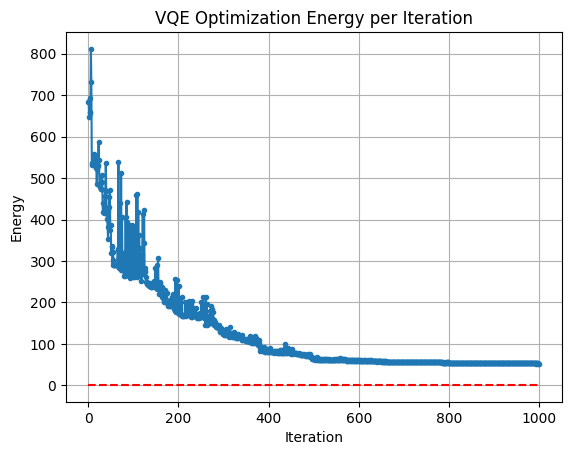

ITERATION 23 - seed = 65
No Ansatz Given, assuming EfficientSU2
NUMBER OF QUBITS 8 8
Ground state energy: 112.75977208505269
Optimal parameters: [-2.34228531  0.80293999 -0.14409051 -0.08209348  3.09736967  1.08743945
 -1.55211523 -3.25774187 -1.67649385 -1.89114481  0.51471712 -1.84339156
  1.96035526  1.2804418   0.15981218  3.84136737  0.901055   -1.07186977
  2.9121284  -1.47971734  0.13504564  2.49902461 -1.75488792  1.47365278
  1.20232798 -0.26908967  1.52014859 -3.08621906 -0.76379286  3.65381166
 -1.93169204  2.74671151 -2.81669091  3.54141389  2.7415674   1.61586019
 -1.6709019  -3.54770244  2.85265982  1.56998304  0.87500929  2.06527438
  0.14382219  1.27398026 -2.09795864 -0.29962802 -1.9509899   0.14721663
  0.86198333 -1.16513626 -1.96186133  2.19182065 -2.82318385  1.56634463
 -1.86184206 -1.74690281  2.8185399  -3.25831824  0.50578364  4.89857795
  1.70078537 -0.44534653  2.13121071  2.49964649]


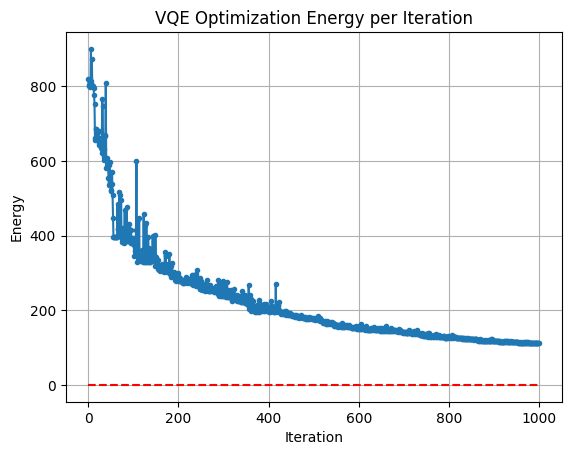

ITERATION 24 - seed = 66
No Ansatz Given, assuming EfficientSU2
NUMBER OF QUBITS 8 8
Ground state energy: 12.925224115844006
Optimal parameters: [ 3.11409326e+00  1.54698927e+00 -6.28798402e-01  1.56566333e+00
 -1.31477922e-02  1.60449281e+00 -2.08529191e+00 -2.62663577e-01
 -7.03795657e-01  3.53920667e+00  3.13868141e+00 -1.26380708e-02
 -1.26690084e+00  1.63388897e+00 -1.54881255e+00 -5.20596963e-01
 -2.12816232e+00 -2.83658012e-02 -2.06036344e-01 -1.33822532e+00
 -9.13816878e-01  1.19561457e+00  1.50270456e+00 -1.98383204e+00
  1.47489727e+00  3.73806521e+00  2.72118877e-01  1.48032918e+00
 -1.47384298e+00  3.06711731e-03  2.40467935e+00  3.28424290e+00
  2.43691358e+00  1.57295682e+00 -5.33507258e-02  1.69180609e+00
  1.16137423e+00  3.15836638e+00  2.37111391e+00  1.07564193e-01
 -1.99044152e+00 -1.95101760e+00  1.74431537e+00  3.02131873e+00
 -4.31846896e-01 -3.17447132e+00  1.45986193e+00 -2.14203575e+00
 -2.07776540e+00 -1.63303381e+00 -3.32911154e+00  2.82048081e+00
 -1.227920

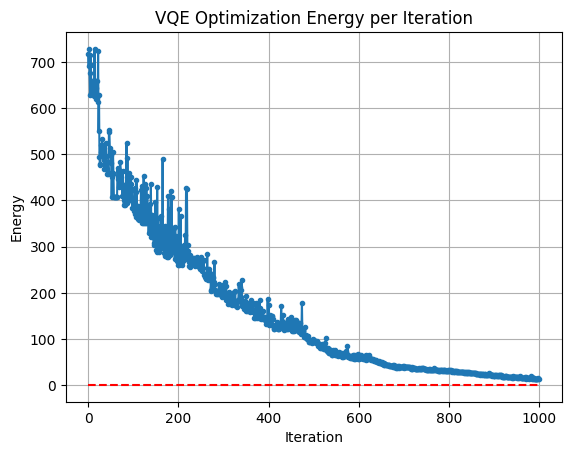

ITERATION 25 - seed = 67
No Ansatz Given, assuming EfficientSU2
NUMBER OF QUBITS 8 8
Ground state energy: 50.44473622355505
Optimal parameters: [-0.00386717 -3.04399364  1.19256812  0.00874979  1.59349502 -0.04769248
 -0.14148766 -1.18199658 -1.27932324  3.46592166 -1.7425007  -3.23958104
  2.82981707  3.46417095  3.44366882  2.34182213  0.00811642 -1.58355154
 -1.7591736  -1.07440179  1.84444734 -0.28525623 -0.25289942  1.2367222
 -1.82710402  0.07623131  2.08655734 -3.1997498  -1.24102942 -0.4075413
 -0.82218574  1.57613743 -3.12933439 -1.52606384 -1.52185317 -0.32965449
  3.16793436  1.35981959  2.91518748 -3.78658039  0.02734369  0.91504089
  0.70532767  1.91637118 -0.01469522 -1.54317176 -2.25112444  0.61076664
 -3.128498   -1.57205678  0.04151153 -1.90012948 -1.54896185 -1.5611879
  1.13122577  1.57372281 -2.09736751 -0.59938482 -1.09075503  1.78647411
 -0.46457397  2.78174049  1.2184834  -2.16335398]


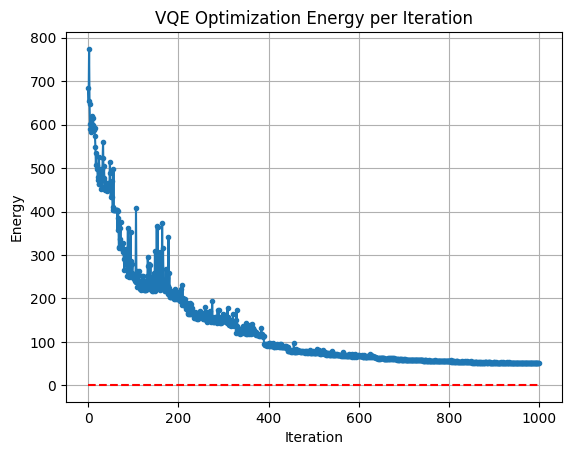

ITERATION 26 - seed = 68
No Ansatz Given, assuming EfficientSU2
NUMBER OF QUBITS 8 8
Ground state energy: 46.727114145405224
Optimal parameters: [ 0.02614173  3.13916004 -0.03572423  1.88155306  2.97311837  1.56617052
 -3.15803939  0.36338099  1.24910327 -2.27861482 -1.79888935  2.24993778
  4.20961522  0.98066779 -0.11838799 -3.44336056 -1.06557272  1.5185008
  1.23989669  3.68914311 -1.948059   -2.04952473 -0.68349739 -1.88245973
 -0.10556024 -3.12815032 -2.85041312 -1.32435767 -0.69335288 -2.08022299
  2.43992366  0.06876789  1.14934918  1.68809274  1.58766254 -1.58079929
  0.12685945 -0.06934412  0.0904033   3.15311547  0.15815872  0.83856145
 -0.13614695  0.09669442  0.53864191 -3.04012813 -1.59745652 -3.17379505
 -1.10720375  2.78071878 -0.03801411  3.49560198 -0.33977292  1.62445641
  0.21764032 -1.9474653   1.43293158  0.21848905  2.14029566  0.82883422
 -1.85132279 -2.34298261 -0.06147323 -0.45261393]


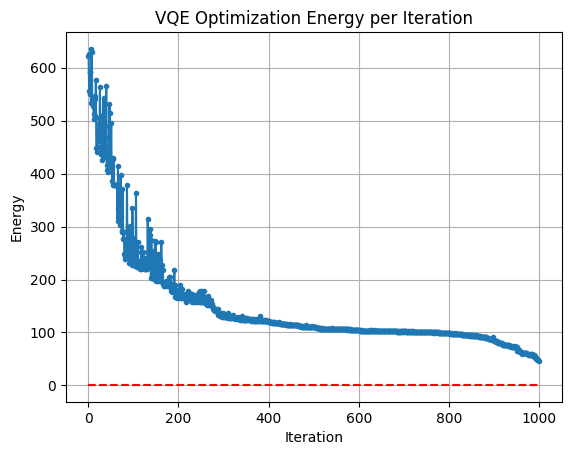

ITERATION 27 - seed = 69
No Ansatz Given, assuming EfficientSU2
NUMBER OF QUBITS 8 8
Ground state energy: 104.34657598952175
Optimal parameters: [-1.73585445e-02  3.73861205e-01  3.09392644e+00  3.13245273e+00
  1.36916986e-02  3.14600407e+00  7.16626079e-01 -1.12399025e+00
 -1.52067696e+00  2.91071683e+00  1.46900993e+00  3.17975574e+00
  4.23638670e+00  2.04539281e+00 -2.74550097e+00  2.96406525e+00
  3.13603532e+00  1.85485363e+00  1.53206879e+00 -3.12033864e+00
 -4.41698252e+00 -2.30261688e-02  3.36287609e+00  1.08539667e+00
  3.75078199e+00 -1.14011878e+00  4.64821500e-02 -1.94727097e+00
 -1.43093460e-01  1.90343077e+00 -1.91809625e-02  1.90831581e+00
  3.10572420e+00 -8.49163411e-01  8.37003509e-02 -9.35600939e-02
  9.17414344e-01  2.19125499e+00  1.25215663e+00 -1.96855897e+00
  7.50916746e-01 -2.38316087e+00  4.40679635e-01  5.56454661e-01
  2.81024751e+00 -2.07410507e-01  2.78166732e+00 -1.12646367e+00
  3.43969282e-03  2.43742699e+00 -9.67183397e-01 -6.04625965e-01
  1.502871

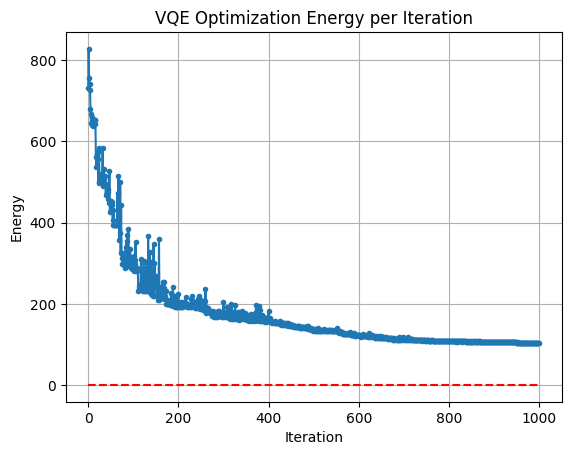

ITERATION 28 - seed = 70
No Ansatz Given, assuming EfficientSU2
NUMBER OF QUBITS 8 8
Ground state energy: 102.1435393514421
Optimal parameters: [ 0.07386501  2.01054261 -0.00795276  3.16954556  0.0154431  -0.01858921
  0.18772649 -2.59799763  2.74790339 -2.22213278 -1.94629381 -1.04521276
 -1.32532166 -2.37709335 -0.1157749  -1.55246935  3.03985794 -1.80422899
 -2.36016768 -3.12774609 -1.5874104  -0.01233746  0.25726978 -2.19294957
 -2.099996    1.82961128 -0.92851613  0.88102206  0.10805925  0.35996095
 -0.36478512 -3.0499873   0.05585155 -0.46829208 -2.6101611   2.81723926
 -1.03567047 -0.95017106  1.59323333 -0.59772563 -1.71398731  1.15634557
 -1.39156132 -0.20731508 -0.83477163  0.74697674 -0.10551281  2.53745165
  3.19212694  0.22509821 -1.57114381 -2.66768228 -1.57459121  0.08495749
  4.55933887 -1.74436994  0.3433881  -2.89622773  0.94925859 -2.32770473
 -1.60581332 -0.22859997  0.99766025 -3.15701277]


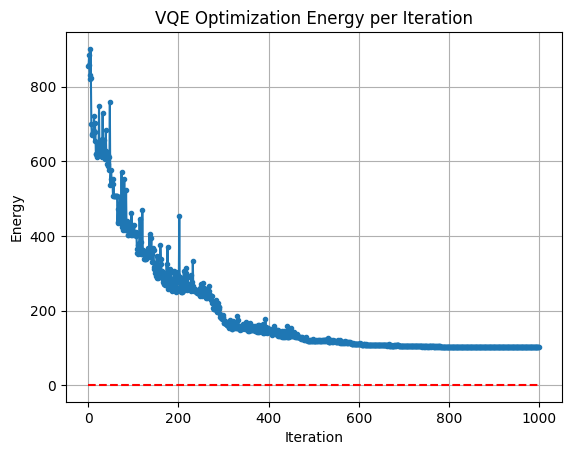

ITERATION 29 - seed = 71
No Ansatz Given, assuming EfficientSU2
NUMBER OF QUBITS 8 8
Ground state energy: 101.23984936322618
Optimal parameters: [-3.11723417  2.42403793  1.72959814  1.37709658 -1.15501663 -2.66999962
  1.98814454 -1.80642654  0.07355769 -2.99569057  3.13006415 -0.04201603
 -0.53648267  0.80741332  3.87404121 -1.56603023 -0.02869996  2.22683376
 -1.51609912 -1.5695087  -1.59485593 -1.45725292  1.5522     -1.19575513
  2.50253789  1.23921572 -0.50541002  2.78065837  4.02552915  0.35492888
  0.07477796  1.78157797 -0.0313616   0.11323666 -3.44050669  2.99039503
 -0.19854862  2.80357337  3.48807118 -2.35510651  4.76541684 -2.21679881
  0.73161618  2.62634709  0.71040742  2.38527044  0.3482018  -2.18860957
 -3.15604823  3.21551861 -0.11328322  3.18127943 -0.11757586  0.96835056
  1.52425385 -1.62632195 -0.04420061  3.51106879 -0.83911002  1.142709
  1.20951435 -3.40913968  0.6901083  -3.01856722]


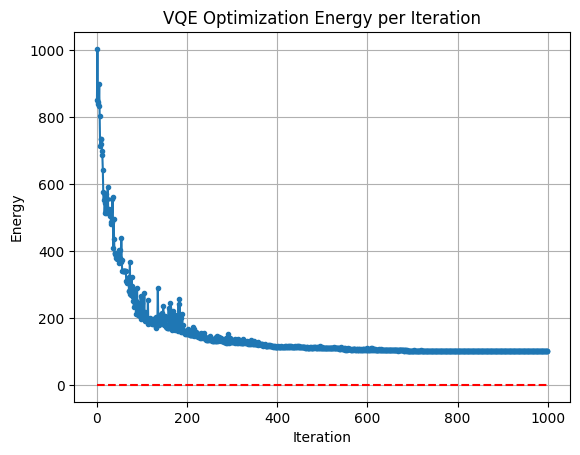

===== SUCCESS RATE FOR GLOBAL MINIMUM 4/30=13.333333333333334%


(4, 30)

In [11]:
from experiment_utils import *

# energy_values = []
# theta_path = []
# vqe_result = run_VQE_simple(H_total_JSP, energy_values, theta_path, min_eigenvalue.real, maxiter=1000, seed=42)
# vqe_final_thetas = vqe_result.optimal_point
run_VQE_stats(H_total_JSP, min_eigenvalue.real, 30, maxiter=1000)

**Perturbed from Local Minimum**

In [1]:
# epsilons = np.linspace(0, 0.2, 3)
# average_distance_from_local_minimum = []
# std_distance_from_local_minimum = []
# average_final_score_function = []
# std_final_score_function = []
# #std as well

# for epsilon in epsilons:
#     distances = []
#     eigenvalues = []

#     for s in range(5): #average
#         #Just for sampling
#         np.random.seed(s)
#         perturbed_thetas = vqe_final_thetas + epsilon * np.random.uniform(-1, 1, len(vqe_final_thetas))

#         energy_values = []
#         theta_path = []
#         result = run_VQE_simple(H_total_JSP, energy_values, theta_path, min_eigenvalue.real, initial_thetas=perturbed_thetas, maxiter=2000, seed=s, verbose=False)
        
#         distances += [np.linalg.norm(result.optimal_point-vqe_final_thetas)]
#         eigenvalues += [result.eigenvalue.real]
    
#     average_distance_from_local_minimum += [np.average(distances)]
#     std_distance_from_local_minimum += [np.std(distances)]
#     average_final_score_function += [np.average(eigenvalues)]
#     std_final_score_function += [np.std(eigenvalues)]

In [2]:
# import matplotlib.pyplot as plt

# plt.figure(figsize=(12, 5))

# # Create the first plot: Average Distance from Local Minimum vs Epsilon
# plt.subplot(1, 2, 1)
# plt.plot(epsilons, average_distance_from_local_minimum, marker='o', linestyle='-', color='b', label='Average Distance')
# plt.fill_between(epsilons, 
#                  [avg - std for avg, std in zip(average_distance_from_local_minimum, std_distance_from_local_minimum)],
#                  [avg + std for avg, std in zip(average_distance_from_local_minimum, std_distance_from_local_minimum)],
#                  color='b', alpha=0.2, label='Std Deviation')
# plt.title('Average Distance of the Final Point from Local Minimum vs Epsilon')
# plt.xlabel('Epsilon')
# plt.ylabel('Average Distance')
# plt.grid()
# plt.legend()

# # Create the second plot: Final Score vs Epsilon
# plt.subplot(1, 2, 2)
# plt.plot(epsilons, average_final_score_function, marker='o', linestyle='-', color='r', label='Average Final Score')
# plt.fill_between(epsilons, 
#                  [avg - std for avg, std in zip(average_final_score_function, std_final_score_function)],
#                  [avg + std for avg, std in zip(average_final_score_function, std_final_score_function)],
#                  color='r', alpha=0.2, label='Std Deviation')
# plt.title('Final Eigenvalue vs Epsilon')
# plt.xlabel('Epsilon')
# plt.ylabel('Final Eigenvalue')
# plt.grid()
# plt.legend()

# # Show the plots
# plt.tight_layout()
# plt.show()


In [3]:
# for i in range(4):
#     visualize_path_2d(theta_path, i, i+1)
# for i in range(4):
#     visualize_path_1d(theta_path, i)

**Running on MUB initial states**

In [13]:
from experiment_utils import *
from vqe import *

energy_values = []
theta_path = []

#run_VQE_MUB(H_total_JSP, min_eigenvalue.real, energy_values, theta_path, state_idx=3, mub_idx=3)
run_VQE_MUB_random(H_total_JSP, min_eigenvalue.real, MAX_ITER=30) #Random

ITERATION 0 === MUB VQE STATE (mub_idx=2, state_idx=2, MUB_mask=(0, 2))
NUMBER OF QUBITS 8 8
Ground state energy: 105.34790840304052
Optimal parameters: [ 3.13418002e+00  2.57715835e+00 -8.31623096e-01  3.37192786e+00
  1.13288981e+00  1.45763283e+00 -5.05993497e-02  1.09076411e-01
  1.92760707e+00  1.67018804e-01  7.35082602e-01 -1.33362576e-02
 -3.69034584e-03  8.27326734e-03  2.52485833e-03  1.81279893e+00
  1.02453084e+00  1.73920059e+00  1.70144793e-01  7.42723557e-01
  2.14172131e+00  1.73024779e+00  1.81499892e+00  1.63991874e+00
  1.64594937e-02  1.33494725e+00  1.59834017e+00  4.97749830e-02
  5.96326294e-03  1.58723134e+00 -7.04875115e-02  1.01088201e+00
  2.05588518e+00  2.83256164e+00  4.78891596e-01 -3.83265733e-01
  1.67726544e+00 -3.43220556e-01  1.59296386e+00  1.29149119e+00
 -3.66215892e-04  7.55719248e-01  1.77254913e+00  1.13969268e+00
  1.67217129e+00 -2.56478483e-01 -2.04975177e-01  6.44443727e-02
 -6.55474313e-01  2.00393543e+00  1.56268638e+00  1.34215183e+00
  

(2, 30)

**Random MUB states VQE**

In [9]:
from experiment_utils import *

#run_VQE_MUB_for_all_mubs_on_one_pair_2q(H_total_JSP, min_eigenvalue.real)
#run_VQE_MUB_random(H_total_JSP, min_eigenvalue.real, MAX_ITER=1) #Random
run_VQE_MUB_on_subset(H_total_JSP, min_eigenvalue.real, MAX_ITER=600, seed=43) #All of the pairs + states

ITERATION 0 === MUB VQE STATE (mub_idx=0, state_idx=0, MUB_mask=(np.int64(0), np.int64(1)))
NUMBER OF QUBITS 8 8
Ground state energy: 100.66569278757163
Optimal parameters: [ 1.67665071e-02 -8.38906301e-02  7.35451529e-01 -1.64619531e-01
  5.79303170e-04  8.33189473e-02 -1.04718747e+00 -7.05907842e-01
  8.76447469e-03 -4.31202598e-03  6.22039277e-02  9.55529905e-02
  4.55083787e-03  6.71540374e-01  2.42048842e-02  1.70695636e+00
  4.79866514e-01  9.28910249e-01  1.08668049e+00  1.13492351e+00
  7.05732741e-01  1.50188473e+00  1.77309788e+00  2.08564143e+00
 -9.81018359e-03 -2.87958775e-03  1.44573701e+00 -2.51492564e-02
  1.04204805e+00 -1.58456561e-01  8.76116468e-01  2.85440163e-01
  8.53347312e-01  1.55302514e+00  1.45041125e+00  2.47731124e+00
  1.68768634e+00  1.46046531e-01  1.24464805e+00  1.05355762e+00
  6.78216395e-03  4.84605273e-01 -2.27242278e-02  1.04991138e-02
 -8.85223056e-02  1.51411804e-02  1.90047311e+00 -2.28491132e-02
  1.97474727e+00  1.91782279e-01  4.86786687e-0

(344, 560)

In [ ]:
from experiment_utils import *

#run_VQE_MUB_for_all_mubs_on_one_pair_2q(H_total_JSP, min_eigenvalue.real)
#run_VQE_MUB_random(H_total_JSP, min_eigenvalue.real, MAX_ITER=1) #Random
run_VQE_MUB_on_subset(H_total_JSP, min_eigenvalue.real, MAX_ITER=600, seed=43) #All of the pairs + states

/home/uni_x/.local/lib/python3.10/site-packages/numpy/_core/getlimits.py:551: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


     ┌───────┐┌───────┐     ┌───────┐┌───────┐»
q_0: ┤ Ry(0) ├┤ Rz(0) ├──■──┤ Ry(0) ├┤ Rz(0) ├»
     ├───────┤├───────┤┌─┴─┐├───────┤├───────┤»
q_1: ┤ Ry(0) ├┤ Rz(0) ├┤ X ├┤ Ry(0) ├┤ Rz(0) ├»
     └───────┘└───────┘└───┘└───────┘└───────┘»
q_2: ─────────────────────────────────────────»
                                              »
q_3: ─────────────────────────────────────────»
                                              »
q_4: ─────────────────────────────────────────»
                                              »
q_5: ─────────────────────────────────────────»
                                              »
q_6: ─────────────────────────────────────────»
                                              »
q_7: ─────────────────────────────────────────»
                                              »
«     ┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

ZeroDivisionError: division by zero

**MUB Random pair + All MUB states**

ITERATION 0 === MUB VQE STATE (mub_idx=0, state_idx=0, MUB_mask=(0, 6))
NUMBER OF QUBITS 8 8
Ground state energy: 100.0172841849336
Optimal parameters: [-8.21177441e-04 -6.35567644e-02 -5.64519678e-01  1.52012583e-01
 -8.34852283e-04  6.38608018e-02 -5.85854600e-02  5.08194208e-02
 -1.14083774e-03  1.79185412e+00  2.61133011e-03  1.57087468e-04
  7.88879639e-02  6.09968173e-01  2.40282966e+00  4.32583534e-01
  9.38826917e-01  5.64742853e-01  9.31659027e-01  2.09967301e+00
 -3.21697664e-03 -8.18570144e-01  2.11547239e+00  4.00964929e-03
  1.34846210e+00 -2.30107820e-01  1.21801314e+00  4.71541536e-01
  1.73225725e+00 -2.16495190e-02  2.27188436e+00  1.52354780e-02
 -1.26176634e-03  1.91972211e+00  7.69303621e-02  1.73734049e-01
  7.53326708e-01 -3.63237065e-01  4.43500949e-01  1.60417442e+00
  1.31584212e+00  2.23957507e+00  8.40360992e-01  1.13893097e-01
 -1.19234259e-04  1.10737062e-01  3.85689216e-01  9.68290672e-01
  1.56522272e+00  5.34668559e-01  1.31111840e+00  5.89970644e-01
 -3

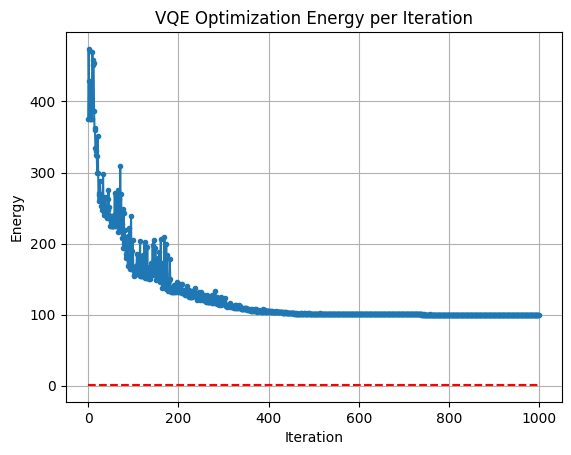

ITERATION 1 === MUB VQE STATE (mub_idx=0, state_idx=1, MUB_mask=(0, 6))
NUMBER OF QUBITS 8 8
Ground state energy: 1.676224281963687
Optimal parameters: [ 9.37640750e-03  9.07558013e-02  3.31388891e-01 -5.28778426e-01
  3.12469671e+00 -1.12362505e-01  1.10557808e+00  1.30195203e-01
  4.22187160e-03 -6.52789089e-03 -1.81831209e-03  2.24659897e-02
 -6.22407379e-02  1.11168037e+00  2.55633987e+00  1.97679662e+00
  1.24021062e+00  1.56933583e+00  1.14992799e+00  2.03107957e+00
  3.64620032e-03 -6.77086811e-04 -1.06831806e-02  2.69576671e-01
  1.26648056e+00 -2.28072473e-02  4.85043408e-01 -9.85962141e-02
  1.00907838e-01  2.67531025e-01  6.15220225e-01  1.68241648e+00
 -9.08950519e-03  2.53645316e-04 -1.35883342e-02  5.62226431e-01
  1.93327872e+00 -5.34061960e-01  1.71799137e+00  1.73731057e+00
  1.12640938e+00  1.65926017e-01  7.10224780e-01 -1.71866625e-01
  3.95401111e-03 -4.82745896e-03  1.90071146e-04  4.76731043e-01
  1.04523317e+00 -7.82075420e-01  2.94750853e+00  1.91544263e+00
  7

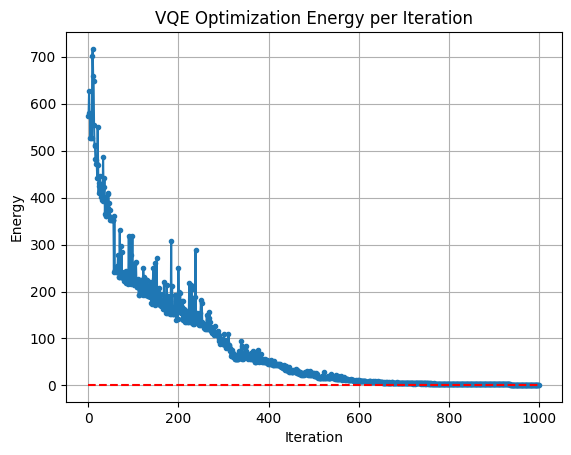

FOUND GLOBAL MINIMUM
ITERATION 2 === MUB VQE STATE (mub_idx=0, state_idx=2, MUB_mask=(0, 6))
NUMBER OF QUBITS 8 8
Ground state energy: 100.05201879403339
Optimal parameters: [ 3.25405541e-02  1.30579276e+00  5.45608433e-01  4.30496894e-04
 -4.18805768e-02  4.98096358e+00  1.39487158e+00 -2.82740378e-01
 -7.12240981e-04 -3.54931165e-03  4.95250974e-01 -4.83211348e-03
 -6.38714601e-02  1.34634116e+00  6.07786916e-01  1.25933537e+00
  1.26514750e+00 -2.52560044e-02  1.15814978e+00  2.36069630e+00
 -8.84185289e-03 -6.64724306e-03  1.56563992e+00 -1.90350264e-01
 -5.15175454e-02  1.44189190e-01  3.73834014e-01 -7.00859548e-01
  2.00356794e+00 -5.22320751e-01  1.33504453e+00  1.95460788e-01
  3.15902102e-03  4.67985425e-02  7.60317860e-01  2.50481279e-01
  1.80620841e+00 -3.90934746e-01  2.17096158e+00  7.45217366e-01
 -1.73422336e-01  1.13644785e+00  7.68617006e-01  5.78212772e-01
 -1.02257207e-02 -4.72999307e-02  1.74186657e+00  4.75821214e-01
  1.12513340e+00  1.58414469e+00 -8.28349917e-

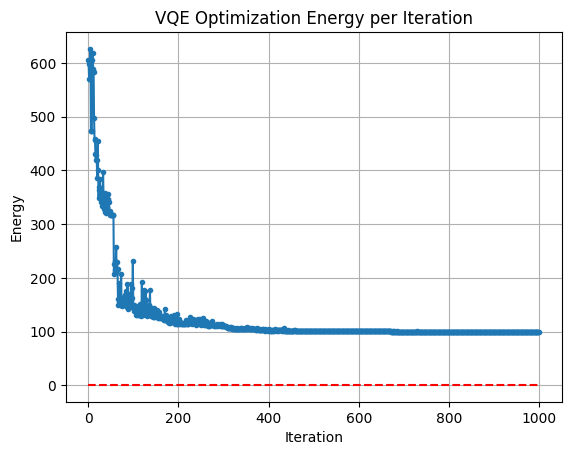

ITERATION 3 === MUB VQE STATE (mub_idx=0, state_idx=3, MUB_mask=(0, 6))
NUMBER OF QUBITS 8 8
Ground state energy: 100.20307135860244
Optimal parameters: [ 1.99965303e+00  1.56767957e+00  8.84201867e-03 -2.78626214e-03
  4.29563705e+00  4.69804980e+00  1.11916539e+00  3.02085953e-01
  2.10763832e-03  5.09485946e-02  6.79866010e-01 -6.68328043e-01
  1.41806626e-01  1.65926117e+00  1.37132189e+00  1.46020466e+00
  1.71361074e+00  2.27425758e-01  1.47051960e+00  2.56743624e+00
  1.36104785e-02  2.00643577e-01  1.90896108e+00 -2.12646603e-01
  4.19040042e-01  1.39809321e-01  4.33835496e-02 -6.15850457e-02
  1.62224018e+00 -1.68358487e-01  1.31749200e+00  5.69519832e-01
 -5.06014448e-03  3.03634182e-01  1.75297754e+00  8.15213965e-01
  2.20085391e+00 -6.93603667e-02  1.19935082e-01 -3.67130188e-01
  9.80413926e-01  1.06516412e+00  2.74025397e-01  3.49735784e-02
 -1.55929564e-02 -2.41685546e-01  6.74903775e-01 -4.60931383e-01
  1.23756335e+00  1.57183564e+00  7.37702858e-01  4.19586376e-01
  

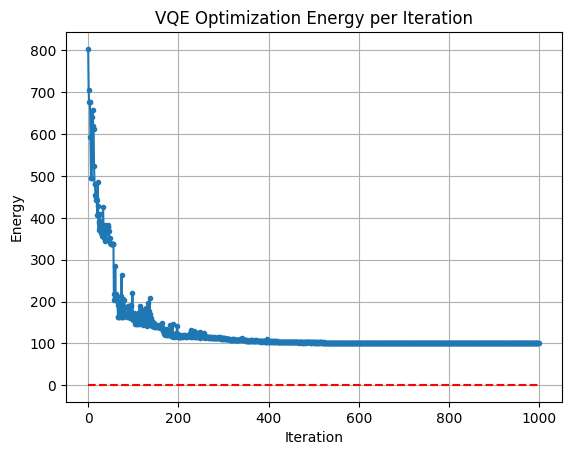

ITERATION 4 === MUB VQE STATE (mub_idx=1, state_idx=0, MUB_mask=(0, 6))
NUMBER OF QUBITS 8 8
Ground state energy: 100.06006844809819
Optimal parameters: [-1.50789243e-01 -1.41435617e+00  3.04808908e+00  2.40446441e-03
  1.57654736e-01  1.41209364e+00 -2.66352998e-01  4.76995802e-02
 -5.93080167e-04 -1.23784270e-03  2.01003080e-01  2.34848633e-02
  8.23663915e-01  1.37803145e+00  1.35311115e+00  9.37183410e-01
  1.34161621e+00  7.35647805e-01  1.73999352e+00  2.28142211e+00
 -1.55461114e-02  2.16152465e-03  1.08230774e+00 -3.65449223e-01
  3.91486928e-01  1.03545817e-01  5.35304736e-01  1.89178301e-01
  1.94490127e+00 -2.11988874e-01  1.50043886e+00  2.45858542e-01
 -2.24730775e-03 -8.89424130e-04  1.81927966e-01 -3.00490513e-01
  2.57765797e+00 -5.19251655e-01  1.64495762e+00  8.66681045e-01
  4.11314767e-01  7.27880847e-01  6.04769793e-01  5.71843907e-01
 -1.29916467e-02  1.39930933e-03  2.08068536e+00  6.73768263e-01
  8.66437196e-01  1.49517056e+00 -4.55184422e-01  7.24530686e-01
 -

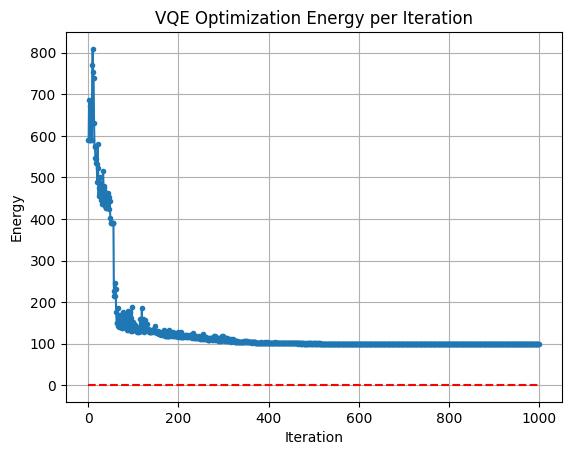

ITERATION 5 === MUB VQE STATE (mub_idx=1, state_idx=1, MUB_mask=(0, 6))
NUMBER OF QUBITS 8 8
Ground state energy: 100.13688733444563
Optimal parameters: [-3.66861570e-03 -3.03863152e+00 -6.60564548e-01 -3.22477124e-01
  5.44832699e-03  3.03526596e+00 -1.07694101e+00  1.33152601e+00
 -1.67751122e-03 -4.36954158e-03  1.34860838e+00  7.19627148e-01
  8.08889602e-02  1.86719043e+00  1.50909571e+00  5.80494111e-01
  2.20977261e+00  3.79537788e-01  2.13310199e+00  2.54408245e+00
  3.38453613e-03  1.33610201e-01  9.65650695e-01 -4.00550316e-01
  5.09638141e-01  3.48333258e-01  5.46656876e-01  3.93820342e-01
  1.84061985e+00  1.31282628e-01  1.17857615e+00  5.63707760e-01
 -1.00254290e-05  2.87616714e-01  1.32920122e+00  1.48112576e+00
  1.70712312e+00 -1.10624329e-02 -1.03846056e+00 -8.96591237e-02
 -1.16669888e-01  8.08424812e-01  1.00660192e+00  3.07314997e-02
  4.62362956e-03  3.87691126e-02  5.58318090e-01 -6.68906727e-01
  1.06765700e+00  1.60666373e+00  8.02826667e-01  3.48354530e-01
  

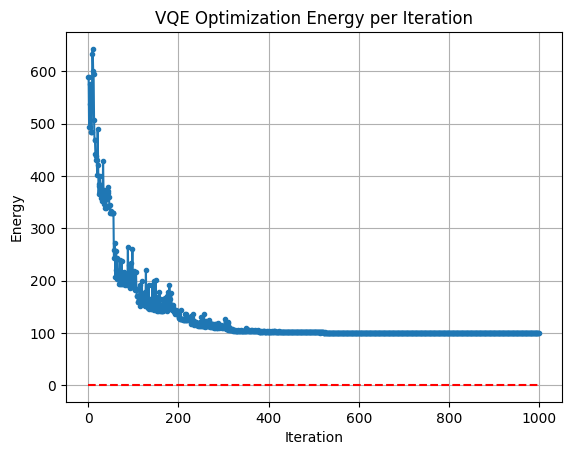

ITERATION 6 === MUB VQE STATE (mub_idx=1, state_idx=2, MUB_mask=(0, 6))
NUMBER OF QUBITS 8 8
Ground state energy: 100.1933230239324
Optimal parameters: [ 3.14067771e+00 -4.09980415e-01  7.67058234e-01  1.78979324e-02
  3.13816442e+00  2.73266975e+00  1.05216952e+00  1.70734271e-02
  2.02134246e-03 -1.88214235e-02  1.83622017e-01 -6.72165052e-02
  4.76113923e-02  1.10897523e+00  1.28455120e+00  1.03149374e+00
  1.30952676e+00  1.42444964e+00  1.37974512e+00  1.90813513e+00
 -6.96253340e-03 -7.86896580e-03  1.75206611e+00 -2.27425156e-01
  9.38786129e-01  1.26611367e+00  5.35092495e-01  6.62060360e-01
  2.01325326e+00  1.86406473e-01  1.38789418e+00  5.66921580e-01
  2.91456834e-05  2.65470852e-02  1.93915312e-01  6.40338439e-01
  1.03321519e+00  1.61226951e-01  1.34079760e+00  2.53931319e-01
 -1.31310430e-01  1.41493827e+00  7.08000605e-01  1.33025006e+00
 -2.66717762e-04 -1.64593850e-02  1.42588154e+00  5.15014125e-01
  1.92685572e+00  5.62718709e-01  1.82743346e+00  1.73986333e+00
  1

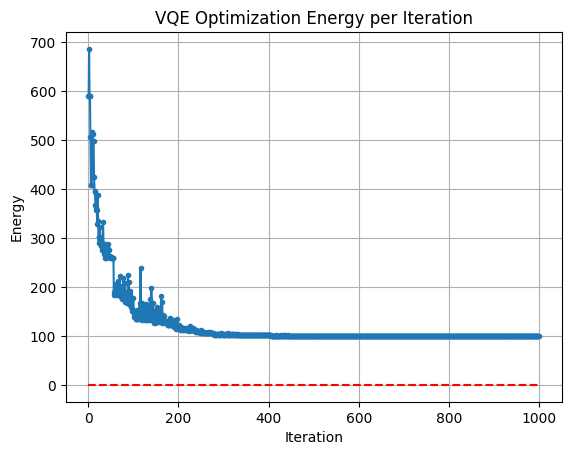

ITERATION 7 === MUB VQE STATE (mub_idx=1, state_idx=3, MUB_mask=(0, 6))
NUMBER OF QUBITS 8 8
Ground state energy: 100.08510195078463
Optimal parameters: [ 3.48751240e+00 -1.65291951e+00  1.56634510e-02  6.64201292e-03
  3.49704938e+00  1.48445559e+00  1.25134217e+00  8.03512332e-01
 -2.13871588e-03  9.50275731e-03  2.23731908e-01  1.00006737e-03
  2.87754289e-01  9.88671389e-01  1.19334750e+00  1.28163216e+00
  1.49244922e+00  1.32835197e+00  1.28889622e+00  1.58059960e+00
 -1.77966438e-03  4.85187046e-03  1.19646469e+00  8.82679758e-02
  7.50845085e-01  1.34155413e+00  4.59836340e-01  7.63339161e-01
  1.88192614e+00 -1.09811601e+00  1.51111884e+00  5.89161936e-01
  1.00169780e-03 -7.28888682e-03 -3.77874275e-01 -2.40541942e-01
  1.37595239e+00  2.46463704e-02  1.80538741e+00  9.78858872e-01
 -6.99064792e-02  1.43965041e+00  6.93223167e-01  1.56097517e+00
 -3.71132709e-03 -3.51471159e-03  1.74397412e+00  6.96027578e-01
  1.80421578e+00  7.92388190e-01  1.01437319e+00  2.04660322e+00
  

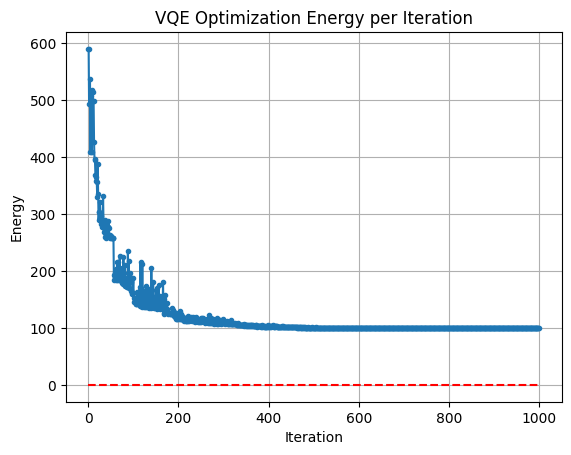

ITERATION 8 === MUB VQE STATE (mub_idx=2, state_idx=0, MUB_mask=(0, 6))
NUMBER OF QUBITS 8 8
Ground state energy: 100.11807421379817
Optimal parameters: [-7.90616880e-04 -3.58461670e-03 -9.49291418e-01  1.75268250e+00
 -6.78835320e-03 -7.56856412e-03 -6.46061407e-01  2.36462260e-01
 -4.14239993e-03  1.17759110e-03  5.06285143e-01  1.28482147e-01
  1.17001788e+00  1.27860339e+00  6.11717221e-01  6.66490449e-01
  1.41609269e+00  9.91225439e-01  9.21251890e-01  2.30157768e+00
  8.00723919e-03  1.11930421e-03  1.53602496e+00  4.11191519e-02
  9.97342168e-01  2.56816377e-01  2.80091450e-01  4.30328165e-01
  1.65778483e+00  4.81442868e-01  1.00324066e+00  5.99936837e-01
 -1.09392254e-03 -8.96943603e-03  2.77901100e-01  3.60630051e-01
  1.59135611e+00 -5.34982362e-01  1.32568036e+00  1.01594505e+00
  1.84195184e-01  9.87200171e-01  1.16484689e+00 -7.37775190e-02
 -4.06457102e-03  2.21785472e-03  2.15783760e+00  2.58794939e-01
  8.72931215e-01  1.17276460e+00  1.01277090e+00  2.27019840e+00
 -

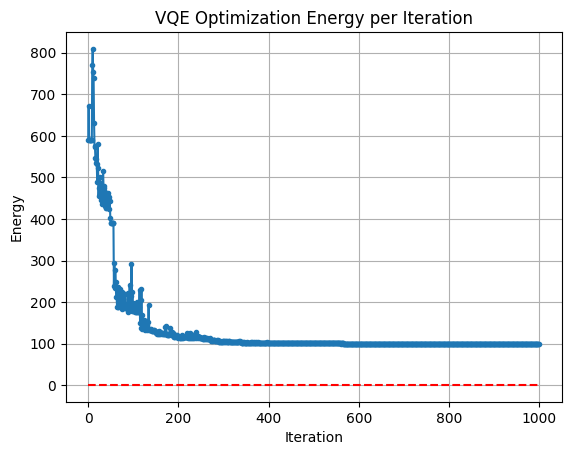

ITERATION 9 === MUB VQE STATE (mub_idx=2, state_idx=1, MUB_mask=(0, 6))
NUMBER OF QUBITS 8 8
Ground state energy: 100.28668322250529
Optimal parameters: [-8.62255194e-04 -2.15763651e-03 -1.86866823e+00  8.29226532e-01
  1.48125970e-04  4.97147283e-03  3.74236610e-01 -3.32606449e-01
 -6.23716553e-04 -8.72041535e-04  1.14494044e+00  1.01400451e-01
 -4.95464841e-01  1.11117825e+00  2.10034034e+00  1.18382945e+00
  3.76050385e-01  1.48777373e+00  4.37066570e-01  2.62912818e+00
  4.78994865e-03 -1.53361615e-02  1.92541938e+00  1.29959288e-01
  2.81866548e-02  2.34464750e-02  3.79519166e-01  1.21099658e-01
  2.77274714e+00  1.16794815e+00  1.31284561e+00  2.31526074e-01
 -1.56274534e-03 -4.86603520e-02  1.04730882e+00  4.04600237e-01
  2.22613258e+00 -4.94511923e-01  1.24286559e+00  1.34045053e-01
 -4.62362970e-02  6.98100478e-01  1.85996401e+00  2.88043215e-01
  1.73185077e-03  4.50408440e-02  1.02545665e+00  1.09097195e-01
  1.29029850e+00  1.61411684e+00  1.02836127e-01  1.88665985e+00
  

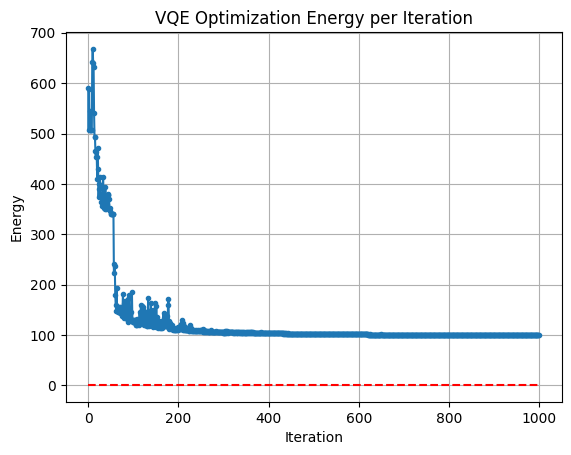

ITERATION 10 === MUB VQE STATE (mub_idx=2, state_idx=2, MUB_mask=(0, 6))
NUMBER OF QUBITS 8 8
Ground state energy: 1.6548365040505981
Optimal parameters: [ 3.02215867e+00  1.38484733e+00 -9.58482634e-01 -2.14958311e-02
  1.23704607e-01  1.37464718e+00  5.36546643e-01 -1.22154922e-01
 -2.82019598e-04 -1.66224828e-03  1.21347922e-03 -1.29024764e-02
 -5.60211142e-02  1.73638876e+00  1.11663004e+00  1.17859609e+00
  6.84378322e-04  1.69656756e+00  4.55580779e-01  1.94454514e+00
 -9.31876345e-02  9.85703667e-04  1.43623374e+00  1.24329076e-03
  4.87363649e-02  6.63504359e-01  8.67477665e-02  1.17401185e+00
 -3.11551888e-03  7.21798539e-01  1.08860413e+00  5.00353260e-01
 -1.33121174e-03 -2.75893383e-03  5.84797351e-01  5.91962326e-01
  1.56277803e+00 -1.11549123e-01  1.95364161e+00  1.01143089e+00
 -5.61872413e-01  5.67266706e-01  7.60572330e-02  6.70537646e-01
  9.89603746e-02  1.04373669e-02  1.44271092e+00  6.94007892e-02
  1.56811350e+00  1.57121004e+00 -4.70713397e-02  7.54660063e-01
 

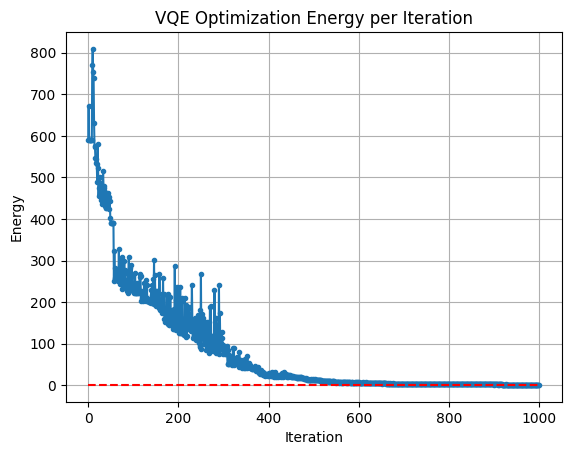

FOUND GLOBAL MINIMUM
ITERATION 11 === MUB VQE STATE (mub_idx=2, state_idx=3, MUB_mask=(0, 6))
NUMBER OF QUBITS 8 8
Ground state energy: 100.02267570222199
Optimal parameters: [ 7.88869853e-05 -6.78845661e-03 -2.07418845e+00  6.69635884e-01
 -1.37173306e-03  5.07412641e-03  2.53249370e-01  1.82157759e+00
  2.45379110e-04 -2.44158490e-03  1.40365881e+00  1.05895765e+00
 -1.05067556e-02  1.30072187e+00  1.04084108e+00  2.14125432e+00
  1.59719740e+00  2.67720200e-01  1.08191535e+00  2.69390876e+00
  6.27551215e-04  3.52544687e-01  1.90820158e+00 -1.30049901e-01
  2.27261088e-01 -3.00484932e-01  7.70628318e-05 -5.52275296e-02
  1.86640418e+00 -1.27052907e-01  1.34372782e+00  4.30485387e-01
  1.03825498e-03  6.84425084e-01  1.65570283e+00  6.63972197e-01
  1.54091411e+00  1.40671196e-03  1.30462651e+00  8.93122913e-02
  2.16898192e-01  1.43710124e+00  7.54674873e-01 -1.17947161e-03
  1.36774505e-03 -6.39899726e-01  9.96036000e-01  1.18848514e-01
  3.94265819e-01  1.57202835e+00  6.31400820e

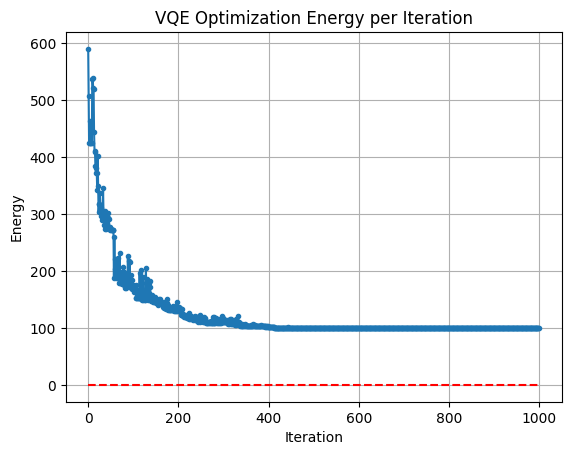

ITERATION 12 === MUB VQE STATE (mub_idx=3, state_idx=0, MUB_mask=(0, 6))
NUMBER OF QUBITS 8 8
Ground state energy: 100.22569493010009
Optimal parameters: [ 1.15909327e-02  4.27220704e-01  7.78556940e-01  3.03610655e+00
  3.15320590e-01  4.30718910e-01 -1.76503923e+00 -1.90778455e+00
  1.59460231e-03 -1.61574310e-03 -1.99560037e-02  4.21860805e-03
  1.84228121e-01  1.87612189e+00  1.25404522e+00  4.38357419e-01
  1.29277172e+00  2.20035834e+00  1.29239212e+00  2.03261620e+00
  9.45765308e-03 -3.92374487e-03  9.55759111e-01  4.27025192e-03
  5.07602135e-01  3.50644999e-01  1.41242853e+00 -2.20731860e-01
  1.78248868e+00 -8.34725507e-01  9.56964676e-01  3.49612193e-01
  4.63690120e-03  8.70252425e-03 -1.24867479e-02  3.08607287e-02
  1.41163554e+00  2.79747756e-01  1.96348001e+00  8.29381825e-01
  6.06237862e-01  6.96833824e-01  4.43996973e-01  6.57604794e-01
  5.04227175e-03 -1.34522728e-02  2.26838890e+00 -3.92682993e-02
  1.18981460e+00  1.21144560e+00 -7.32780920e-01  6.63518452e-01
 

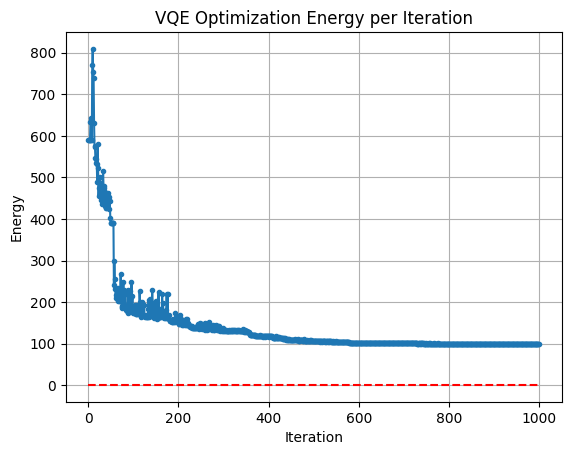

ITERATION 13 === MUB VQE STATE (mub_idx=3, state_idx=1, MUB_mask=(0, 6))
NUMBER OF QUBITS 8 8
Ground state energy: 100.14694878353413
Optimal parameters: [-7.85519494e-04 -8.25792224e-03  1.34703443e+00  1.53192082e+00
 -1.84555440e-06 -2.58341386e-03 -1.44860588e-01 -1.93125056e+00
  1.33824792e-03  3.18640399e-03  1.37986040e+00  2.67594418e-01
  7.96221598e-01  1.23115678e+00  7.53425917e-01  1.53257604e+00
  1.51261153e+00  1.08367791e+00  1.00438444e+00  2.48562209e+00
 -5.87253924e-03  3.92235320e-03  1.95964830e+00 -5.25687494e-02
  3.32797178e-01 -2.00738281e-01  4.13288914e-01  4.04055969e-01
  2.13738471e+00  1.03855684e-01  1.19900638e+00  5.99789807e-01
 -4.59652726e-04  7.37880228e-02  8.08825373e-01  1.30298440e+00
  1.51644523e+00 -6.13927192e-02 -8.67386210e-02  3.05304626e-01
  3.83573008e-01  9.64403502e-01  8.68297890e-01  4.09480079e-03
 -2.50248919e-03 -5.34171880e-02  1.31978750e+00  5.61367020e-01
  1.11141150e+00  1.04304439e+00  2.31695645e-01  9.50629249e-01
 

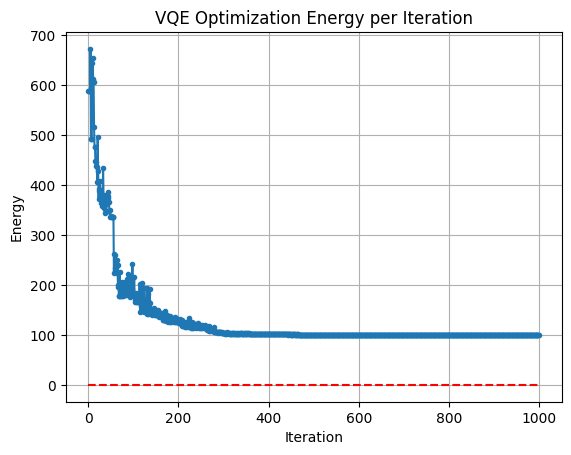

ITERATION 14 === MUB VQE STATE (mub_idx=3, state_idx=2, MUB_mask=(0, 6))
NUMBER OF QUBITS 8 8
Ground state energy: 100.0293339611179
Optimal parameters: [ 3.62076006e-02  1.10096929e+00 -5.84134130e-01 -3.13700505e+00
  6.18283821e-02  1.10510150e+00  6.36250460e-01  1.94217804e+00
  1.53941329e-04  1.69887925e-03 -2.43952683e-02 -4.04791880e-03
 -1.02490795e-02  1.51799672e+00  1.87880883e+00  9.69258129e-01
  9.58020231e-01  2.02752136e+00  1.12500519e+00  2.14809309e+00
 -4.95179005e-03 -3.16871348e-03  1.30414440e+00 -3.55219412e-02
  8.00295375e-02  4.97972041e-01  7.69896623e-01 -3.70587696e-01
  1.40758700e+00 -3.93129173e-01  2.00254385e+00  3.12802780e-01
 -1.02909783e-04  2.62679813e-02  1.51195397e-02 -3.93299109e-02
  9.11107432e-01 -3.53337496e-01  2.51139511e+00  5.98263879e-01
  5.00119006e-01  9.31436341e-01  8.92485192e-01  7.13856728e-01
 -3.47290804e-03 -2.73087391e-02  2.09944180e+00 -5.79480311e-02
  8.38991607e-01  1.49678325e+00 -6.13875047e-01  5.51901616e-01
  

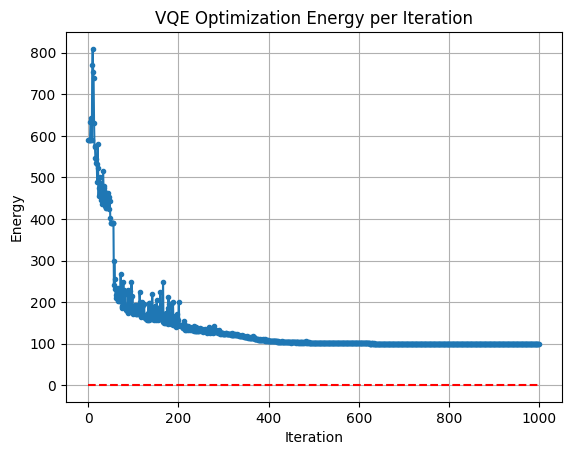

ITERATION 15 === MUB VQE STATE (mub_idx=3, state_idx=3, MUB_mask=(0, 6))
NUMBER OF QUBITS 8 8
Ground state energy: 100.19286886781
Optimal parameters: [-2.77779740e-03  7.94998306e-01 -1.25375536e+00  1.88983596e-03
 -5.19100758e-03 -7.97337114e-01  6.21675560e-01  1.01820273e+00
  2.84126956e-03 -1.21580731e-02  9.96543239e-01  5.89983350e-01
  1.45155660e-01  1.49277004e+00  8.76522265e-01  9.09930278e-01
  1.39255834e+00  7.71639363e-01  1.35835613e+00  2.32128505e+00
  8.26596684e-04  1.02047939e-02  1.82749934e+00 -1.55575497e-01
  9.78760738e-01  5.97538684e-03  5.78136002e-01  5.04679107e-01
  2.44383584e+00  2.00933978e-01  1.49911403e+00  6.87399152e-01
  3.17415467e-03  1.18421234e-02  1.51459342e+00  9.94720665e-01
  1.62016216e+00 -1.01360998e-01  1.09315671e+00  1.26243958e+00
 -1.12819874e-02  1.48526331e+00  1.36499710e+00  4.51088185e-02
  1.24317851e-02 -6.03085161e-03  1.37617126e+00  2.71789517e-01
  1.20183502e+00  1.35870355e+00  1.01397171e+00  2.90924358e+00
  2.

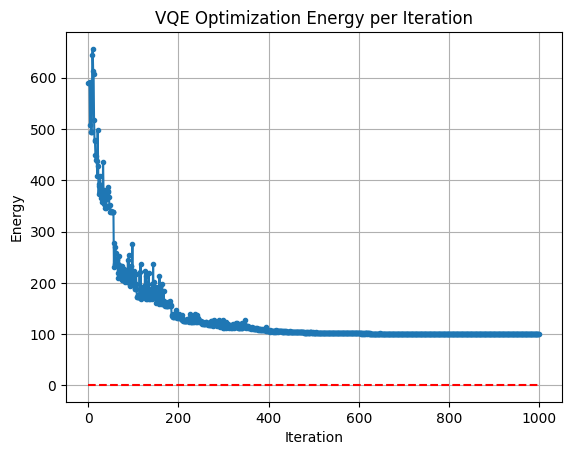

ITERATION 16 === MUB VQE STATE (mub_idx=4, state_idx=0, MUB_mask=(0, 6))
NUMBER OF QUBITS 8 8
Ground state energy: 100.08895192470449
Optimal parameters: [ 3.14107421e+00 -6.52105830e-01  1.85042560e+00 -1.02145739e-03
  3.13939742e+00  2.48870094e+00  1.02836029e+00  4.27502518e-01
 -1.88157749e-03 -1.60543429e-02  3.90312225e-01  1.48544285e-02
 -1.83235683e-01  1.56875703e+00  4.69256533e-02  1.68341059e+00
  1.47203574e+00  2.13069798e+00  4.91615298e-02  2.68781963e+00
  5.30575521e-03  9.41324962e-02  1.91736146e+00 -3.49022843e-01
  3.32875474e-01  1.41685419e-01  3.77080443e-01 -3.80187008e-02
  1.58346194e+00  8.79263887e-02  1.46741393e+00  2.84930327e-01
 -3.93272193e-04  1.05679095e-01  1.72896084e+00  3.78036955e-01
  1.71704584e+00 -1.12622046e-01  1.20851985e+00  4.53516474e-01
  1.22449269e-01  1.80603142e+00  7.86584681e-01  1.75812813e-01
 -1.87573044e-03 -6.30382264e-02  7.60450786e-01 -3.38477000e-01
  1.35286194e+00  1.56984406e+00  1.41323506e-01  8.40687327e-01
 

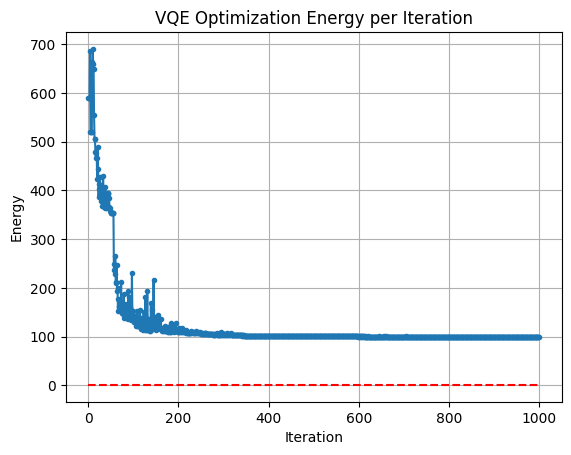

ITERATION 17 === MUB VQE STATE (mub_idx=4, state_idx=1, MUB_mask=(0, 6))
NUMBER OF QUBITS 8 8
Ground state energy: 100.2034681209699
Optimal parameters: [-0.09215199  1.25154508 -0.08600024  3.1445771  -0.08495438  1.25983063
 -0.45197816  0.66009882 -0.00552372  0.0051368   1.57145176 -0.56577548
  0.09062483  1.04505025  1.05772031  0.46328874  0.73184891  1.37509871
  0.37745351  1.88262584 -0.14950098  0.01499284  1.43645922 -1.34239939
  0.18023126 -0.55876002  0.09950485  0.11429784  1.92321406  0.33450454
  2.00829922  1.00750035 -0.01599326  0.14323545  1.4126211   1.51313673
  1.97376811 -0.26090564  0.36011039 -0.4422381  -0.06809611  0.10637236
  0.36274175  0.01026878 -0.15580402 -0.08907549  1.45277638  0.77771309
  1.50522584  1.34265295  0.76083939  2.23394169 -1.08755799 -0.29084823
 -0.16500929 -0.08608789]


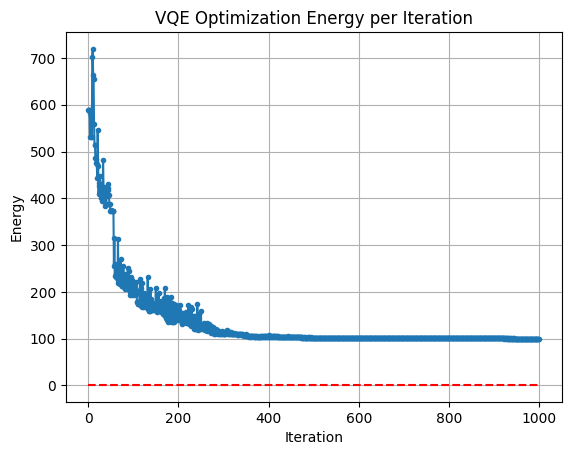

ITERATION 18 === MUB VQE STATE (mub_idx=4, state_idx=2, MUB_mask=(0, 6))
NUMBER OF QUBITS 8 8
Ground state energy: 100.01356701202728
Optimal parameters: [ 2.14570160e+00 -1.57048558e+00  8.94425996e-03  1.68427795e-03
  2.14640034e+00  1.57059115e+00  2.14371645e-01 -7.11858038e-02
 -5.75926394e-04 -1.46248556e-03  4.53979456e-01  2.38083762e-03
 -6.14492679e-02  1.50190092e+00  9.27737927e-01  1.14202553e+00
  1.70246437e+00  2.52835076e-01  7.63368771e-01  2.24538958e+00
 -4.42880382e-04 -1.55013254e-03  1.50310005e+00  2.12050091e-01
  6.07971250e-01 -1.97010576e-01  6.58305782e-01  8.03199522e-02
  1.96254321e+00 -1.02876107e-01  1.49284507e+00  3.67750019e-01
 -7.86661469e-04  7.33176029e-04  1.38101833e+00 -2.05823075e-01
  1.68952419e+00  3.42566629e-02  2.26341356e-01  9.76030984e-01
 -3.35147305e-02  1.12696759e+00  5.17429070e-01  4.57261990e-01
  1.39331553e-03 -3.09617484e-03  1.39644798e+00 -2.08822853e-01
  9.91701054e-01  1.29634113e+00  5.99880696e-01  1.45236547e+00
 

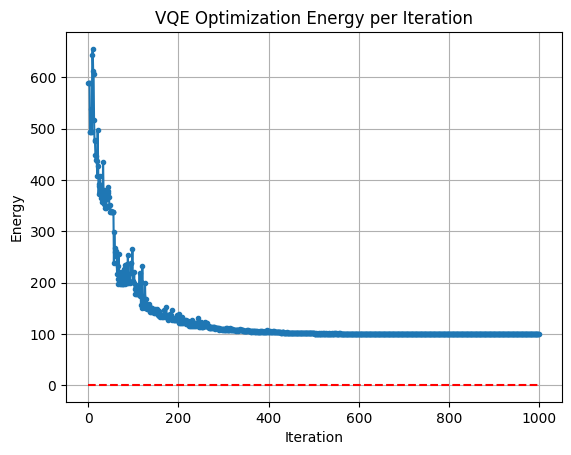

ITERATION 19 === MUB VQE STATE (mub_idx=4, state_idx=3, MUB_mask=(0, 6))
NUMBER OF QUBITS 8 8
Ground state energy: 100.00286256030785
Optimal parameters: [ 1.20940397e+00 -1.56991372e+00 -1.83185091e-05 -1.67169132e-03
  1.21103746e+00  1.56799400e+00  1.39495380e-01  1.45721411e-01
 -8.42914908e-04 -2.55702567e-04  6.84634220e-01 -1.55672228e-02
  1.93587714e-01  1.46523422e+00  1.13159502e+00  8.56834605e-01
  5.15994693e-01  2.44937539e+00  1.68745330e+00  2.17126483e+00
 -1.94490450e-03 -9.41181612e-04  1.53421239e+00  3.32399909e-02
  3.43174249e-01  3.40918784e-01  4.80876226e-01  7.67511124e-01
  1.56409143e+00 -2.04811375e-01  1.43276842e+00  7.55453229e-01
  1.39624754e-03 -2.65167984e-03  1.41965855e-01  9.92986092e-02
  1.58008179e+00 -3.29557115e-01  1.25928614e+00  1.53134690e+00
 -5.45991219e-01  1.40395005e+00  1.72535863e+00  2.64043638e-01
 -3.03082108e-03  9.43474252e-04  1.73818784e+00  7.52318558e-01
  7.78165396e-01  1.55266732e+00  8.64762663e-01  2.27531972e+00
 

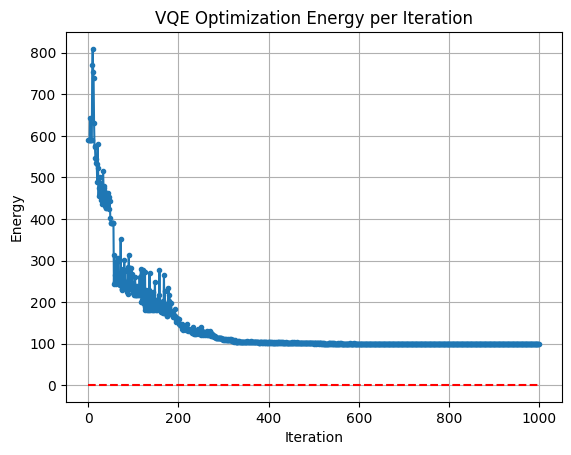

===== SUCCESS RATE FOR GLOBAL MINIMUM 2/20=10.0%


(2, 20)

In [10]:
import random

#Random Pair
d = random.randint(1, H_total_JSP.num_qubits - 1)  # Get two unique numbers between 1 and H.num_qubits
c = random.randint(0, d - 1)

run_VQE_MUB_for_all_mubs_on_one_pair_2q(H_total_JSP, min_eigenvalue.real, MAX_ITER=30, MUB_mask=(c,d))

**MUB Random MUB state + All Pairs**

ITERATION 0 === MUB VQE STATE (mub_idx=0, state_idx=0, MUB_mask=(np.int64(0), np.int64(1)))
NUMBER OF QUBITS 8 8
Ground state energy: 100.74407769804881
Optimal parameters: [ 4.91491885e-03 -2.78634676e-04 -2.72904954e-02  1.04165609e+00
 -8.01909996e-04  1.60724441e-02 -1.01412972e+00  5.92663615e-01
 -7.83047196e-02  3.17990304e-01 -2.90425556e-03 -2.16469153e-03
 -3.71890231e-01  1.29972505e+00  1.01587220e+00  1.19189588e+00
  1.55109802e+00  5.09633476e-01  1.02343235e+00  2.09165694e+00
  3.51065143e-01 -3.38919814e-01  1.99057874e+00  2.81877853e-03
  1.11588281e+00  1.19113041e+00  1.30840370e+00  7.35571911e-01
  1.32660694e+00  4.53813472e-01  1.64534819e+00  5.78132313e-01
  5.88035072e-01  1.53551966e+00  7.12995360e-02  1.86215082e-01
  8.95873007e-01  4.53012574e-02 -4.63383958e-01  1.76141020e+00
  9.63703554e-01  8.38489891e-01  5.06707361e-01  6.97426688e-01
  7.90466597e-01 -5.17026074e-01  1.03436369e+00  6.76315055e-02
  1.56402254e+00  5.06226807e-01  5.81513469e-0

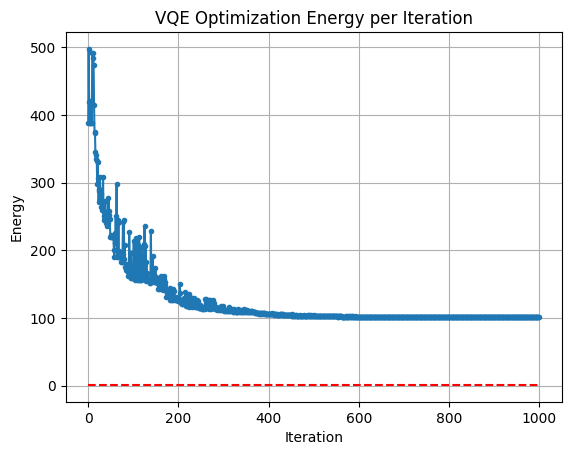

ITERATION 1 === MUB VQE STATE (mub_idx=0, state_idx=0, MUB_mask=(np.int64(0), np.int64(2)))
NUMBER OF QUBITS 8 8
Ground state energy: 100.01791856765344
Optimal parameters: [ 5.21235544e-04  1.96371278e-02  7.75657632e-01 -5.62011985e-01
  4.80884044e-04 -1.89996320e-02 -1.08939422e+00 -3.18093128e-01
 -4.04745754e-04  1.14957625e+00 -5.00516133e-03  8.64809947e-04
  7.51645153e-02  1.31995345e+00  1.63830352e+00  1.29836703e+00
  1.16486255e+00  1.04991495e+00  1.92220707e+00  1.04114726e+00
  2.45122027e-03  1.13971490e-01  1.26700043e+00 -3.30716221e-03
  1.50503201e+00  6.05807994e-01  7.02702741e-01  2.21448000e-01
  1.67435253e+00  7.04823628e-01  1.61794653e+00  6.93930394e-01
 -4.62683189e-04  1.47085709e+00  1.59444751e+00  1.17403145e+00
  1.64250852e+00 -7.84302577e-02  1.17091163e+00  1.22710125e+00
  7.16511454e-01  1.59892601e+00  9.80165556e-01  6.46136518e-01
  8.02709853e-04  1.33793600e-01  5.84477470e-01 -2.29355888e-01
  1.55703778e+00  1.46305870e-01 -3.01817293e-0

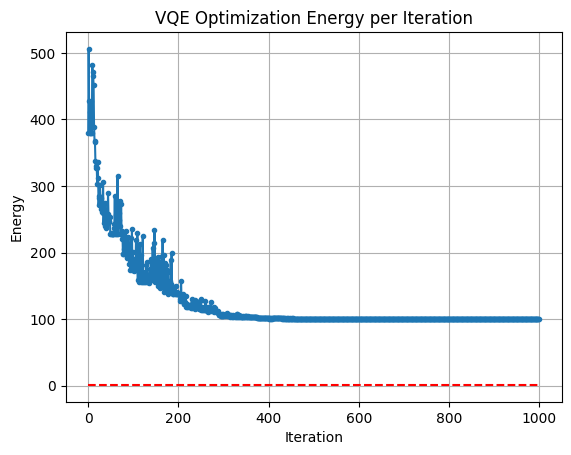

ITERATION 2 === MUB VQE STATE (mub_idx=0, state_idx=0, MUB_mask=(np.int64(0), np.int64(3)))
NUMBER OF QUBITS 8 8
Ground state energy: 1.1458959794257126
Optimal parameters: [ 6.19032213e-03 -7.39238972e-02  2.36033617e-01 -4.14070906e-01
 -2.93692446e-03  6.34104367e-02 -9.54427427e-01 -8.60092865e-01
 -1.66884531e-03 -2.41186726e-03  8.78786087e-03  3.59030502e-02
 -9.34478715e-02  1.97495956e+00  3.30243473e-01  1.66860009e+00
  1.49326411e+00  6.96526470e-01  2.17807304e+00  1.80935078e+00
  1.55598995e+00 -3.59446811e-03  1.64106330e+00  5.08334363e-02
  1.42511305e+00  7.40159129e-01  3.34886451e-03  1.23944792e+00
  3.13129665e+00  4.68500326e-01 -4.45438725e-01  1.15052818e+00
  1.16730024e+00  1.16656039e+00 -9.03454967e-01  9.10857723e-01
 -1.74937926e-01  1.70466441e-02  1.25515171e+00  1.88980958e+00
 -1.51441624e-01  1.69774923e-01  4.28097993e-01 -7.89162472e-02
  1.58380190e+00 -7.67319743e-03  1.56324456e+00  8.35531483e-02
  1.56760146e+00  1.72149521e+00 -7.22506287e-0

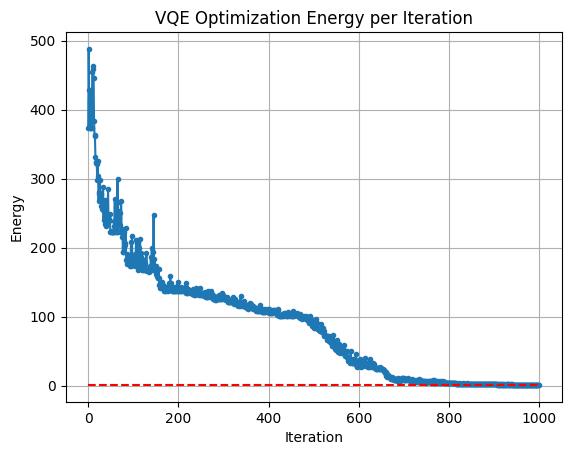

FOUND GLOBAL MINIMUM
ITERATION 3 === MUB VQE STATE (mub_idx=0, state_idx=0, MUB_mask=(np.int64(0), np.int64(4)))
NUMBER OF QUBITS 8 8
Ground state energy: 11.115169956468119
Optimal parameters: [ 0.02679612  0.26203548  1.19044151  3.05653955 -0.0038795   0.26183922
  0.85978903  1.0099548   0.02188982  2.89234177 -0.07933617  0.32035903
 -0.53797287  1.29259043  0.41279699  1.37364956  0.62818162  0.41078999
  0.68627517  2.61865547  1.53635032 -0.53161006  1.53479322  1.8789484
  0.03460527 -0.20016443  0.02974106 -0.17325052  2.95617059 -0.11998387
  1.25648786 -0.13576414  1.54408485  1.54662867  1.43353325  1.43829054
  1.39633662 -0.23730739 -0.58890388  0.72362001  1.49106258  0.79438152
  1.34483013  0.7148932   1.34713919 -0.01467423  1.02457776  0.07851442
  2.56320553  1.52819901  0.41066239  0.2518775  -0.833891    0.74928153
  0.35655669 -0.34399087]


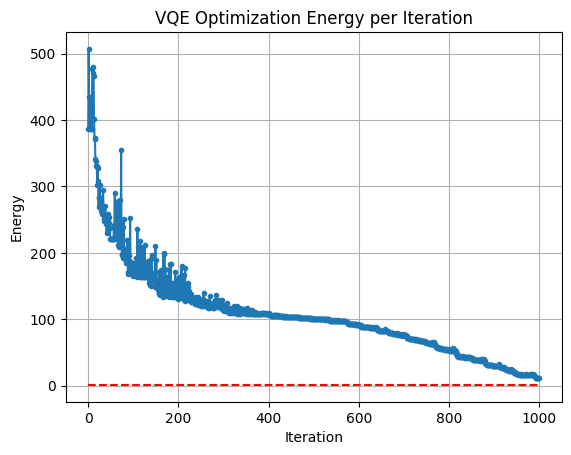

ITERATION 4 === MUB VQE STATE (mub_idx=0, state_idx=0, MUB_mask=(np.int64(0), np.int64(5)))
NUMBER OF QUBITS 8 8
Ground state energy: 100.21294218623684
Optimal parameters: [ 2.04259085e-03 -3.12655353e-03  2.06496600e+00  9.56339696e-01
  3.60221820e-03  9.00529141e-03  4.12478411e-01 -4.94943289e-01
  5.10499840e-03  1.60905837e+00  4.37707194e-03 -1.52323277e-01
 -3.89412481e-01  1.35192973e+00  2.00893452e+00  2.19703861e+00
  9.77644799e-01 -1.73736314e-01 -2.81469991e-01  2.83269877e+00
  2.39163573e-03 -8.52900468e-01  1.95560643e+00  5.44531763e-02
  2.53937795e-01 -1.23488045e-01  3.66120494e-02  9.17034892e-01
  2.05118534e+00 -3.83276744e-01  1.43831303e+00  1.67883401e-01
  2.86477970e-03  2.15420478e+00  1.87016603e+00  3.94267167e-01
  1.77620017e+00 -1.24988868e-01  6.56724256e-01 -7.23708099e-01
 -7.98695970e-03  3.38228400e-01  5.86838966e-01  1.38385821e-01
  3.00095846e-03  8.21505878e-02  1.55323529e+00  1.01873801e+00
  1.55235180e+00  1.58210651e+00  2.19814756e-0

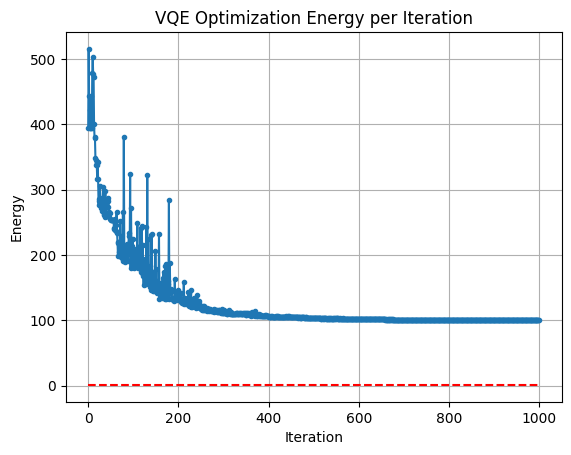

ITERATION 5 === MUB VQE STATE (mub_idx=0, state_idx=0, MUB_mask=(np.int64(0), np.int64(6)))
NUMBER OF QUBITS 8 8
Ground state energy: 100.0172841849336
Optimal parameters: [-8.21177441e-04 -6.35567644e-02 -5.64519678e-01  1.52012583e-01
 -8.34852283e-04  6.38608018e-02 -5.85854600e-02  5.08194208e-02
 -1.14083774e-03  1.79185412e+00  2.61133011e-03  1.57087468e-04
  7.88879639e-02  6.09968173e-01  2.40282966e+00  4.32583534e-01
  9.38826917e-01  5.64742853e-01  9.31659027e-01  2.09967301e+00
 -3.21697664e-03 -8.18570144e-01  2.11547239e+00  4.00964929e-03
  1.34846210e+00 -2.30107820e-01  1.21801314e+00  4.71541536e-01
  1.73225725e+00 -2.16495190e-02  2.27188436e+00  1.52354780e-02
 -1.26176634e-03  1.91972211e+00  7.69303621e-02  1.73734049e-01
  7.53326708e-01 -3.63237065e-01  4.43500949e-01  1.60417442e+00
  1.31584212e+00  2.23957507e+00  8.40360992e-01  1.13893097e-01
 -1.19234259e-04  1.10737062e-01  3.85689216e-01  9.68290672e-01
  1.56522272e+00  5.34668559e-01  1.31111840e+00

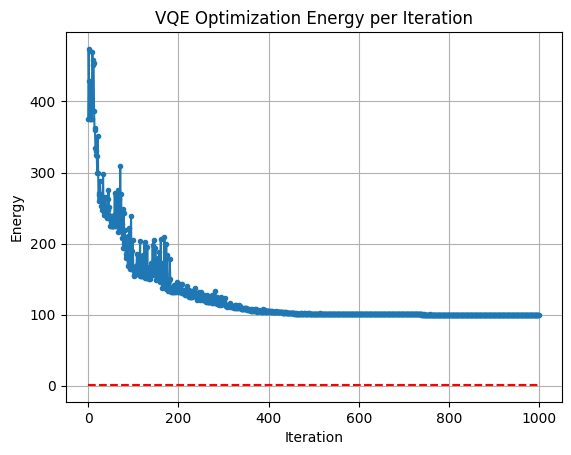

ITERATION 6 === MUB VQE STATE (mub_idx=0, state_idx=0, MUB_mask=(np.int64(0), np.int64(7)))
NUMBER OF QUBITS 8 8
Ground state energy: 100.03341524006355
Optimal parameters: [-2.34244280e-03 -1.08698281e-04  1.74760467e+00  6.31112446e-01
  3.83705961e-03  7.80964017e-05 -1.91966568e-01  1.71737314e-01
 -1.75554520e-03 -1.19558039e-02 -1.79446125e-01  1.03456036e-02
  1.42629810e+00  1.56132523e+00  1.69990845e+00  8.54161169e-01
  1.63869481e+00  1.69807886e+00  3.51419956e-01  2.24304491e+00
 -2.89082031e-03 -3.69257878e-02  1.24346809e+00  1.42720044e+00
  2.78970270e-01  8.17527856e-03  6.94318422e-01  1.05128253e+00
  2.86890937e-01  3.05452205e-01  1.67701562e+00 -5.08647136e-02
 -2.11471154e-04  4.92997845e-02  5.84584337e-01  1.50096411e+00
  1.45714661e+00 -1.94700299e-02  1.73143529e+00  2.04638893e-01
 -8.69276047e-01  1.85049614e+00  7.23384856e-01  8.93648493e-01
 -6.84664796e-04 -3.64566651e-02  1.78858742e+00  7.64673728e-01
 -3.30146510e-01  1.40291782e+00 -9.95455995e-0

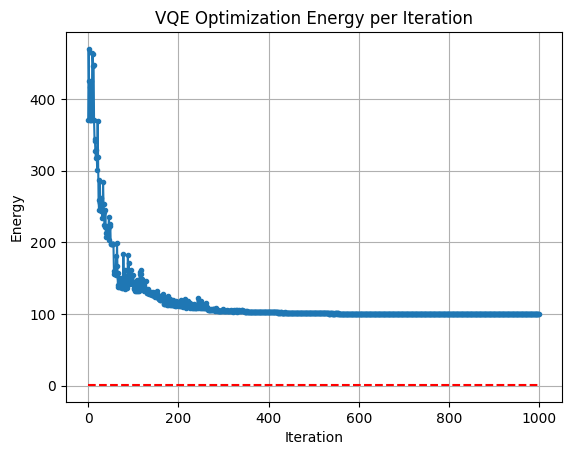

ITERATION 7 === MUB VQE STATE (mub_idx=0, state_idx=0, MUB_mask=(np.int64(1), np.int64(2)))
NUMBER OF QUBITS 8 8
Ground state energy: 100.21678220089116
Optimal parameters: [ 2.48826838e-03 -2.41930106e-01  8.74824892e-01 -2.32774183e-01
 -3.88692048e-04  2.51611322e-01 -8.94666905e-02 -3.38552076e-01
  2.87543329e-02  1.58818042e+00  2.84507211e-03  9.70574933e-03
 -4.97944290e-02  1.33481845e+00  7.95221800e-01  6.77187280e-01
  1.92969884e+00  4.12992683e-01  1.52223298e+00  8.87956984e-01
  2.37678176e-01 -2.50158509e-01  1.37542363e+00  3.64850636e-03
  1.03277552e+00  3.02740939e-01 -1.53579301e-01  2.37674876e-01
  1.97530567e+00  8.48874695e-01  1.61447415e+00  1.41205701e+00
  6.02849913e-03  1.35995686e+00 -2.12364442e-01  8.63990462e-01
  1.50172871e+00  2.05332411e-02  1.66363431e+00  1.15764972e+00
  7.22119445e-05  8.11899528e-01  8.09128497e-01  5.45127906e-01
  2.33238410e-01 -1.15708297e-01  7.44205296e-01 -4.99238672e-01
  1.56967422e+00  8.35891189e-01 -7.21122452e-0

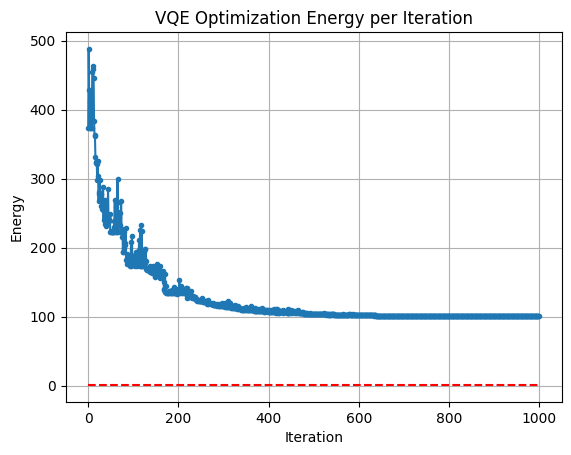

ITERATION 8 === MUB VQE STATE (mub_idx=0, state_idx=0, MUB_mask=(np.int64(1), np.int64(3)))
NUMBER OF QUBITS 8 8
Ground state energy: 100.09502282405184
Optimal parameters: [ 4.27197725e-03 -3.99527568e-01 -4.14187473e-01 -6.08204045e-02
 -5.82575982e-04  3.90599695e-01 -1.79083028e-02  4.21715522e-01
  5.99726917e-04  1.56951664e+00 -2.87333852e-03 -3.29777372e-03
 -1.60951732e-01  1.26389774e+00  9.76291583e-01  7.51663014e-01
  1.51021724e+00  7.46944116e-01  2.10303665e+00  1.58414345e+00
  5.92799872e-02  5.90242091e-01  1.43911005e+00  5.68137653e-02
  9.94823744e-01  9.29507076e-01  1.14811228e+00  6.17144895e-01
  2.04203034e+00  2.11563970e-01  1.79769349e+00  1.18287864e+00
  1.78249742e-02  1.47925310e+00  1.45834423e+00  1.59742200e+00
  1.35979236e+00 -1.18363153e-01  8.84931430e-01  1.07317377e+00
  2.38338607e-01  1.92560473e+00  8.39180692e-01  2.44371645e-01
  5.39875120e-02 -1.00246484e-02  1.91987883e-02 -9.79502683e-02
  1.52134138e+00  9.57068391e-01  4.38906502e-0

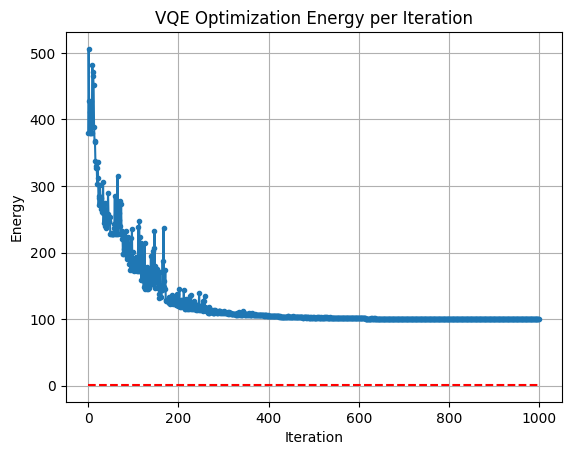

ITERATION 9 === MUB VQE STATE (mub_idx=0, state_idx=0, MUB_mask=(np.int64(1), np.int64(4)))
NUMBER OF QUBITS 8 8
Ground state energy: 5.473430477870546
Optimal parameters: [ 0.00723707 -0.26232549  0.95140381 -0.01322401 -0.07163152  0.26614484
  0.05175209  0.22141793  0.07926142  1.09163769  1.4080554  -1.38565344
  0.07587627  1.34459594  0.78563916  1.79757881  0.16184743 -0.59846057
  1.40004735  2.65493813  1.52486581  1.6024333   1.15828699 -1.45418649
  0.1452074  -0.23750924  0.02527463 -0.00507625  1.30510222 -0.28186287
  2.10615108  0.44266803  1.5995608   1.64092523  0.21717497  1.5195312
  1.55051174  0.02693059  1.19646509  1.59966791  1.09045772  0.23249524
  1.76966806  0.02007724  0.13357259  0.09819919  1.27203997  1.1794059
  1.42813985  1.53891939  1.24128726  0.44184606 -0.55268995  1.88283539
  0.5022196   0.60508197]


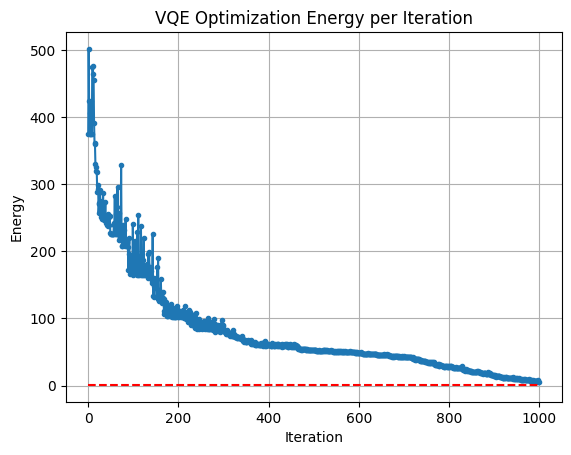

ITERATION 10 === MUB VQE STATE (mub_idx=0, state_idx=0, MUB_mask=(np.int64(1), np.int64(5)))
NUMBER OF QUBITS 8 8
Ground state energy: 1.5053028588415225
Optimal parameters: [ 1.96200716e-03 -6.33457172e-01  2.93249033e-01  1.58931076e-02
 -1.58782353e-02  6.28535503e-01  3.87781883e-01 -4.81157027e-01
 -2.68803970e-03  6.57081996e-01  1.46622942e+00 -1.05644083e-01
  1.46608088e+00  2.12130158e+00  1.36916813e+00  1.92024327e+00
  1.47039538e+00 -5.89026007e-01  1.51998810e+00  2.36260370e+00
  1.57949616e+00  7.47052565e-01  1.23696587e+00  9.81460869e-01
  1.51360070e+00  1.23217355e-01 -3.19607160e-03 -2.47694667e-01
  1.50320224e+00  6.07629609e-02  1.39951625e+00  6.23038308e-02
  1.55001870e+00  1.56486687e+00  1.19174841e+00  2.59556817e+00
  7.62044962e-02 -7.42886191e-01  7.69625025e-01  2.38256789e+00
  1.50605675e+00  1.76836902e+00  4.39861325e-02  5.82434577e-01
  7.57484655e-01 -5.06551469e-03  9.87469011e-01  1.23036631e+00
  1.55397072e+00  1.58261067e+00  2.69359023e+

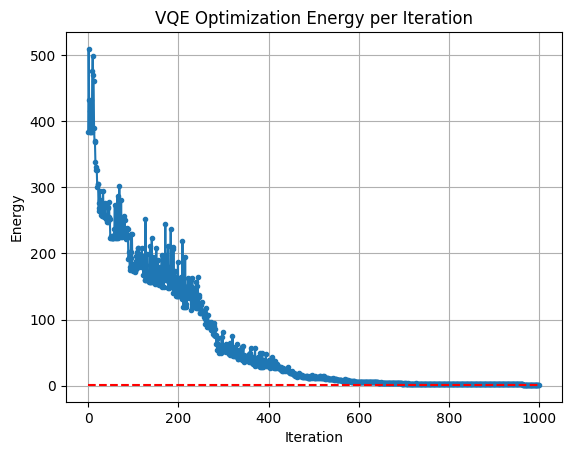

FOUND GLOBAL MINIMUM
ITERATION 11 === MUB VQE STATE (mub_idx=0, state_idx=0, MUB_mask=(np.int64(1), np.int64(6)))
NUMBER OF QUBITS 8 8
Ground state energy: 100.05360868229222
Optimal parameters: [ 1.12124707e-03 -1.14024311e-01 -8.05257921e-03 -3.94103727e-01
  1.47473140e-03  1.12580456e-01  1.06292046e+00 -2.12622058e-01
  2.61121250e-03 -1.00646184e-03  1.54662145e+00  1.39709365e-03
 -8.02268497e-01  1.74913543e+00  6.24213144e-01  1.53556481e+00
  1.17041522e+00  6.53608338e-01  1.17716274e+00  2.45314741e+00
  2.33121041e-03  2.08859706e-03  7.64924087e-01  2.47974767e-01
  2.66347470e-01 -3.54929044e-02  3.31916865e-01  4.84527354e-01
  1.87627685e+00  1.73654268e-01  1.33249427e+00  7.25668086e-02
 -5.25060824e-04  2.58602167e-04  1.51747185e+00  1.38460623e-01
  1.56148014e+00  3.02222215e-01  6.45767555e-01 -5.88567734e-01
  1.36743495e-01  8.11551962e-01  1.03783159e+00  5.69025845e-01
 -2.17320306e-03  7.71882234e-04  9.44121207e-01  2.65420851e-03
 -5.80376116e-02  1.48002

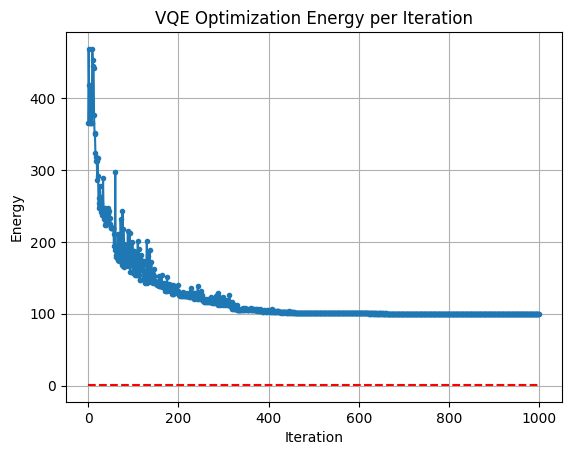

ITERATION 12 === MUB VQE STATE (mub_idx=0, state_idx=0, MUB_mask=(np.int64(1), np.int64(7)))
NUMBER OF QUBITS 8 8
Ground state energy: 100.03473278582031
Optimal parameters: [-1.30409364e-03 -2.14664483e-02  9.24355919e-02 -1.82466820e-01
 -1.98740712e-03  2.26948689e-02 -9.70904897e-02 -3.77417734e-01
 -2.32199033e-04  1.67058439e-03 -1.95645349e-01  1.07808488e-02
  1.08779731e-01  1.64646098e+00  1.40531333e+00 -1.95626602e-01
  1.96689562e+00  9.32352397e-01  1.21746492e+00  2.44789331e+00
  1.09182327e-02  3.61201144e-03  1.07340676e+00  2.61639680e-01
  1.64185689e+00  1.96750539e-01  1.23864160e+00  3.08992215e-01
  1.01009007e+00  9.91616569e-01  1.65101459e+00 -1.06804495e-01
 -7.24486838e-04 -5.74050126e-03  1.22603352e+00  9.36195395e-01
  1.45828339e+00 -2.48213881e-02  3.75193623e-01  4.58779888e-01
  4.32795804e-01  2.16484484e+00  1.30916578e+00 -6.00004720e-02
  3.43301037e-03  3.10918025e-03  1.59626661e+00 -5.28493686e-01
  1.49161797e+00  7.70755589e-01  8.87179041e-

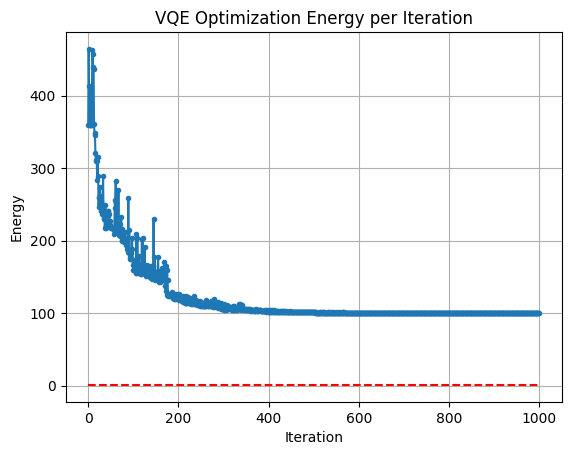

ITERATION 13 === MUB VQE STATE (mub_idx=0, state_idx=0, MUB_mask=(np.int64(2), np.int64(3)))
NUMBER OF QUBITS 8 8
Ground state energy: 4.620569774598731
Optimal parameters: [ 1.84992370e-02 -1.65846715e-01 -6.81391109e-01 -3.78421572e-01
  3.64425171e-02  1.25461418e-01 -8.61415876e-01  2.46100570e-01
  5.96704495e-02  1.69867227e+00  1.55493182e+00  1.40179308e+00
  1.69818476e-02  1.55307199e+00  5.23506224e-01  1.38392383e+00
  1.96207089e+00  2.78061983e+00  9.01842669e-01  1.78343782e+00
 -5.48384348e-02  3.92579652e-01  1.55754128e+00 -1.87076315e-01
 -4.38504691e-02 -2.22075767e-01  2.02919661e-01  1.81842449e-01
  3.56321209e-01 -1.51642571e+00  1.94527705e+00  1.34449261e+00
 -8.02193991e-02  3.18178083e+00  1.61526107e+00  1.48631366e+00
  6.47853382e-02  3.70533741e-02  1.01996903e+00  1.55620667e+00
  2.42486989e-03  1.16395423e+00  7.82959984e-01  2.87562604e-02
  1.09631664e-01  1.78103318e+00  4.26314910e-02  1.52753487e+00
  2.69221038e-01  1.57279637e+00  1.86161516e+0

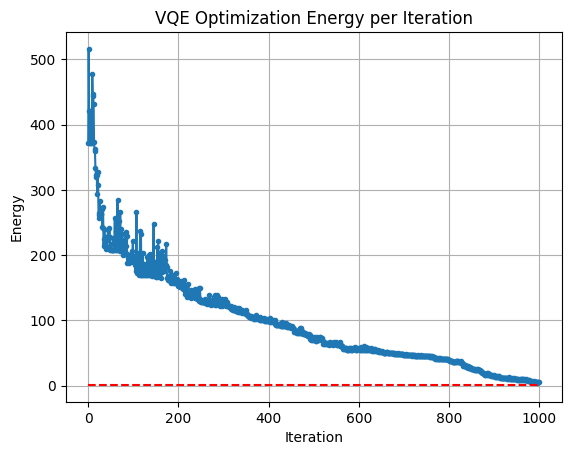

ITERATION 14 === MUB VQE STATE (mub_idx=0, state_idx=0, MUB_mask=(np.int64(2), np.int64(4)))
NUMBER OF QUBITS 8 8
Ground state energy: 1.4087673589185046
Optimal parameters: [ 7.05967527e-03  6.50814899e-02 -1.34663878e-01  4.06891487e-01
 -9.86803014e-03 -6.36031759e-02 -6.16117628e-01 -6.30466698e-01
 -2.02004637e-03  1.46398049e+00  1.57103113e+00  9.58991978e-02
 -1.03661867e+00  1.21927765e+00  1.36969149e+00  2.32208251e+00
  1.21129856e+00  2.17709713e+00 -3.18860052e-01  2.48787031e+00
  1.25800132e+00  5.37151300e-01  1.57915364e+00  6.13998629e-01
  6.98054230e-01 -2.33200539e-01  6.35643089e-02  2.71505364e-01
  1.46047905e+00  2.68118272e-01  2.04812829e-01  3.75339612e-01
  1.72585123e+00  1.57348923e+00  9.84386367e-02  1.53838800e+00
  5.50880940e-02 -4.59674074e-01  3.28008529e-01  1.33725174e+00
  1.52098423e+00  1.82009988e+00  3.16020988e-02  4.22440463e-01
  8.70751243e-01 -2.35493061e-01  9.73140737e-01  1.58221329e+00
  1.56310422e+00  1.55945623e+00  5.90141360e-

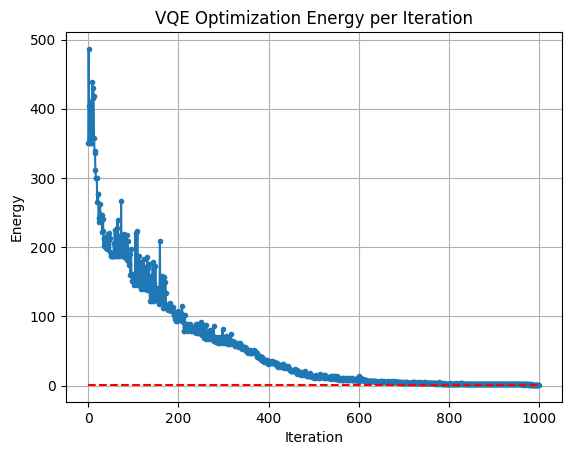

FOUND GLOBAL MINIMUM
ITERATION 15 === MUB VQE STATE (mub_idx=0, state_idx=0, MUB_mask=(np.int64(2), np.int64(5)))
NUMBER OF QUBITS 8 8
Ground state energy: 1.0695268977668386
Optimal parameters: [-1.49132349e-04  3.10364940e-01  8.03674463e-01 -3.85883038e-03
  3.60993580e-03 -3.06576142e-01  7.47251746e-02 -1.58465495e-01
 -2.13874929e-03  8.78214511e-01  1.31169643e+00  1.22403502e+00
  1.56650039e+00  1.27805617e+00  2.21510453e+00  1.25566242e+00
  1.62280576e+00  4.25617117e-01  1.55094339e+00  2.06654205e+00
  1.47524347e+00 -2.34275394e-01  1.56309810e+00  1.56873470e+00
  9.37491274e-02  1.94244635e-02 -2.20655862e-01  1.68703879e+00
  1.50626035e+00 -1.55453120e-02  1.57211284e+00  1.37635948e-02
  1.37335172e+00  1.49174125e+00  1.96112401e-01  1.93299639e-01
  2.95820131e-01 -3.55874539e-01  1.12213431e+00  1.16821799e+00
  1.62088792e+00  1.30562415e+00  8.69422073e-01  4.93577676e-01
  1.43889800e+00 -4.26798987e-02  1.39208490e+00  1.56275322e+00
  1.56706042e+00  5.89876

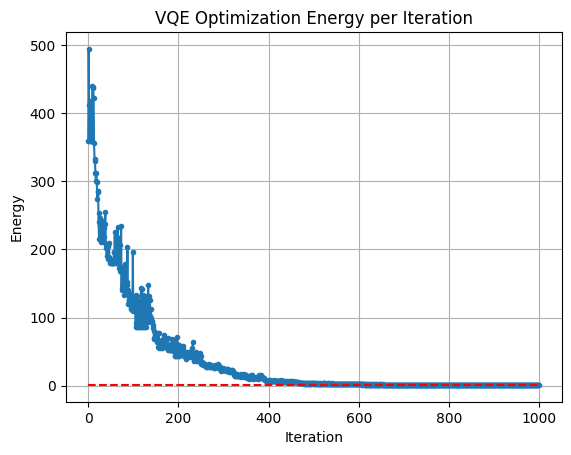

FOUND GLOBAL MINIMUM
ITERATION 16 === MUB VQE STATE (mub_idx=0, state_idx=0, MUB_mask=(np.int64(2), np.int64(6)))
NUMBER OF QUBITS 8 8
Ground state energy: 100.13396900738552
Optimal parameters: [-2.61421491e-03  2.06528183e-03 -4.51933026e-01  1.16507344e+00
  3.97611311e-04 -2.77909425e-03 -5.13297455e-01  8.67060764e-02
  2.27209772e-03  1.62432374e-04  9.63529007e-01  5.35558386e-02
 -9.50319312e-02  1.21745580e+00  1.94486361e+00  1.48411506e+00
 -3.73174956e-02 -2.14247290e-01  4.49692841e-01  2.18759542e+00
  1.96428322e-03  6.47785165e-03  1.27264095e+00 -1.75807332e-01
  5.04077399e-02 -1.00894381e-01  2.69255687e-01  1.26692970e+00
  1.72649195e+00  1.58601470e+00  1.29813873e+00  4.35372159e-01
 -3.11414560e-03  1.35185314e-02  8.51305308e-01  2.14571214e+00
  1.67913079e+00 -3.29621630e-01  1.87148771e+00 -1.06980475e-01
  2.23836022e-01  2.67220273e+00  5.24387855e-01  4.76077501e-01
  7.64519873e-03 -2.15395378e-02  1.26832511e+00  5.99601659e-04
  1.03782657e+00  1.59580

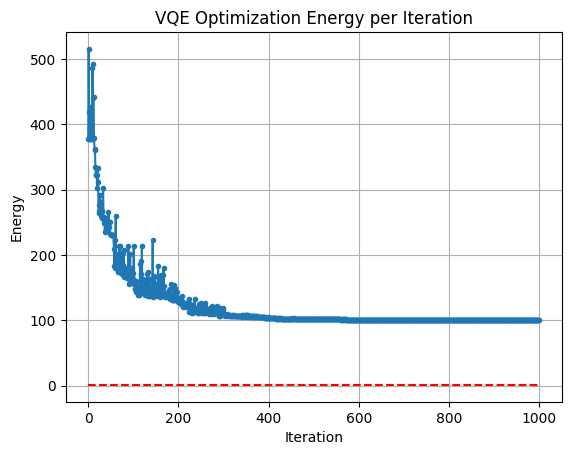

ITERATION 17 === MUB VQE STATE (mub_idx=0, state_idx=0, MUB_mask=(np.int64(2), np.int64(7)))
NUMBER OF QUBITS 8 8
Ground state energy: 1.0223343651009857
Optimal parameters: [-7.27548452e-04 -8.91029431e-03 -2.67912473e-01  2.00339511e+00
  1.03526725e-03  1.38744886e-03 -1.46866216e+00  4.33898791e-02
  4.49782106e-03  3.79859536e-04  1.55529319e-03 -9.43181056e-03
  4.24627584e-01  2.95265693e-01  1.79161732e+00  1.33829981e+00
  3.56359658e-01 -6.51214305e-02 -3.29847855e-01  2.77699493e+00
  1.92850892e+00  9.03937565e-05  1.56313011e+00  1.57261500e+00
  4.01966510e-01  1.07075368e+00  1.11244660e-01  1.45094844e+00
 -3.16374278e-03  1.50846280e-03  1.29873588e+00  4.02371160e-01
 -6.60196014e-02 -6.35438212e-02  1.57226758e+00  1.56981338e+00
  1.56917475e+00  9.35796339e-01  1.88990768e+00  1.13647506e+00
  8.66026480e-01  8.59978871e-01  9.24029218e-01 -3.72401988e-01
  1.21378631e+00  1.98658054e-02  1.56587266e+00  6.65249513e-03
  5.83781338e-03  1.60017727e+00 -2.57110134e-

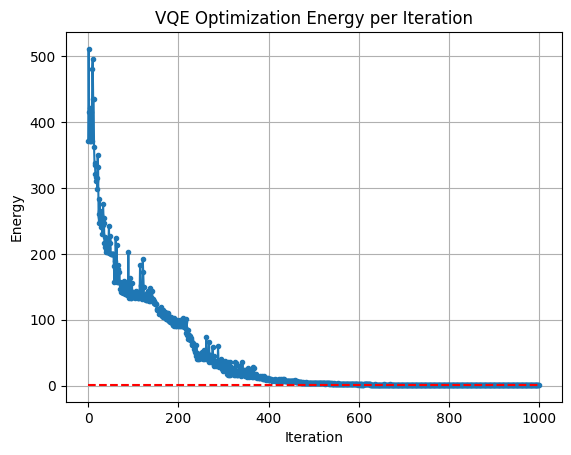

FOUND GLOBAL MINIMUM
ITERATION 18 === MUB VQE STATE (mub_idx=0, state_idx=0, MUB_mask=(np.int64(3), np.int64(4)))
NUMBER OF QUBITS 8 8
Ground state energy: 1.2699231730161682
Optimal parameters: [-1.54421749e-03  8.56214521e-03  1.32957143e+00 -8.18695728e-01
  1.65330188e-03 -1.57242470e-02 -1.74028711e-01  1.16894584e+00
 -6.78979443e-02  4.97168222e-01  1.53061513e+00  4.59203429e-02
 -7.98752770e-01  1.61735998e+00  1.47339727e+00  1.56539369e+00
  1.51192263e+00  2.05550243e+00 -2.57624129e-02  2.37840536e+00
 -8.65689483e-02  1.18913171e+00  1.43440712e+00 -2.99711678e-01
  9.42159000e-01  4.95769965e-02  5.07973397e-01  5.05326764e-01
  1.07025814e+00  1.21211906e-01  5.05080704e-03  6.01626030e-01
  6.03081393e-02  2.22958365e+00 -4.01325237e-02  1.32821385e+00
 -2.08904258e-02  3.53683600e-02  1.83161905e+00  1.06927786e+00
  5.40927737e-01  1.69515405e+00 -1.08811405e-02  5.12935370e-01
  7.39837302e-02  5.27491979e-01  1.61404480e+00  1.50208432e+00
  1.53363418e+00  1.56296

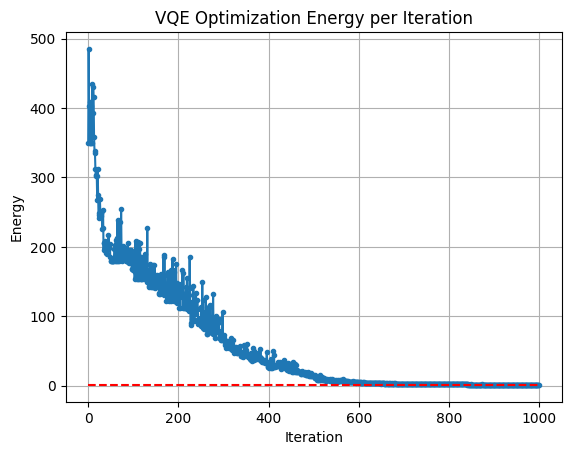

FOUND GLOBAL MINIMUM
ITERATION 19 === MUB VQE STATE (mub_idx=0, state_idx=0, MUB_mask=(np.int64(3), np.int64(5)))
NUMBER OF QUBITS 8 8
Ground state energy: 1.855336118427537
Optimal parameters: [ 1.20058836e-03  8.69225148e-03  1.25216640e+00  1.58969765e+00
 -7.01949116e-03  6.68575772e-03 -4.10724043e-01 -1.53044205e+00
  1.87823072e-03  7.87015949e-01  1.75193106e+00  1.53585856e+00
  1.60840117e+00  1.55289697e+00  1.02960341e+00  3.07613156e-01
  1.64922488e+00 -6.38391286e-02  1.11639490e+00  1.93742087e+00
 -1.35977983e-02 -3.64442947e-02  1.60248892e+00  1.59478366e+00
 -2.35740666e-02  4.27422124e-01  1.79262471e-01  1.86165396e+00
  1.58086575e+00  1.08545190e-01  1.59544476e+00 -1.01817078e-01
  1.72737001e-01  2.33116234e+00 -1.45226928e-01 -4.15793846e-01
 -2.67079175e-04  5.71399092e-02  2.35100447e+00  1.81195257e+00
  1.57656709e+00  1.76000052e+00  1.47157017e+00  8.67344399e-02
  5.44455025e-02  4.16892840e-01  1.55304459e+00  1.45211575e+00
  1.55053161e+00  3.799346

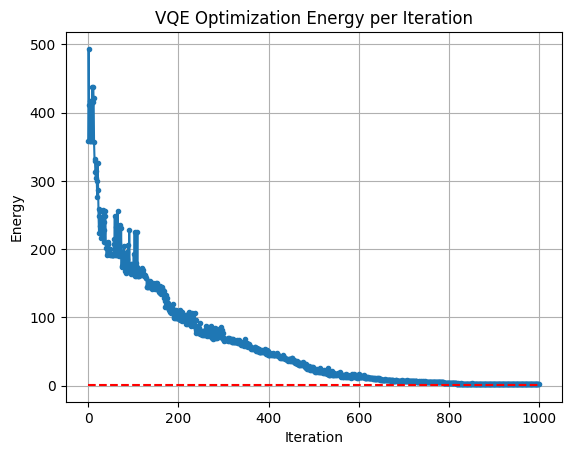

FOUND GLOBAL MINIMUM
ITERATION 20 === MUB VQE STATE (mub_idx=0, state_idx=0, MUB_mask=(np.int64(3), np.int64(6)))
NUMBER OF QUBITS 8 8
Ground state energy: 100.38236885921758
Optimal parameters: [ 1.64306357e-03  5.01564982e-01  3.18889148e-01 -7.80234268e-03
  5.55814247e-04 -4.93683356e-01  2.91682346e-01  7.96500081e-01
 -1.99245732e-03  4.04815105e-01  1.85131614e-01  7.77492585e-02
  4.27332948e-01  1.42870609e+00  4.27595164e-01  9.54750110e-01
  1.24140243e+00  5.45276599e-01  8.79501363e-01  1.46877509e+00
  2.76241252e-03 -3.30097558e-01  1.87840539e+00 -3.90074796e-02
  7.44926527e-01  2.39675314e-01  9.04921884e-02 -5.22568043e-01
  1.52076710e+00  7.22269148e-02  1.14840460e+00  1.39494493e+00
 -3.43420218e-03  6.09519533e-01  1.03908723e+00  2.93408547e-01
  1.81515283e+00 -2.87064759e-01  2.87951761e-01  1.50470594e+00
  3.83708034e-01  1.44258638e+00  7.66825563e-01  8.47794268e-02
  9.04104362e-03  2.41176693e-01  1.65346215e+00  7.33539457e-01
  1.48652454e+00  1.18535

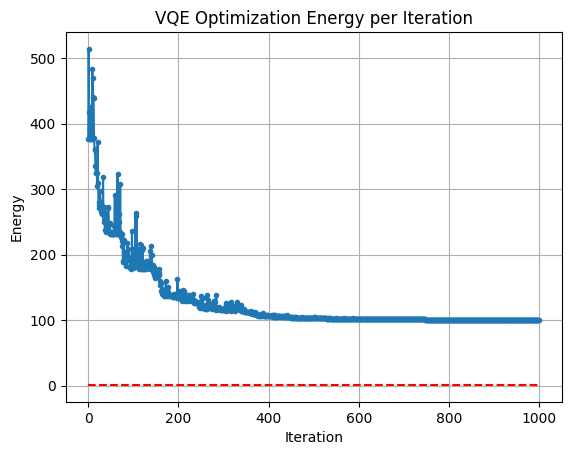

ITERATION 21 === MUB VQE STATE (mub_idx=0, state_idx=0, MUB_mask=(np.int64(3), np.int64(7)))
NUMBER OF QUBITS 8 8
Ground state energy: 100.15428594750557
Optimal parameters: [-1.21449401e-03 -7.51072371e-03 -5.13341052e-01  1.17053080e+00
 -9.21467443e-06  4.97029021e-03  7.44765056e-01  2.12746236e-01
 -7.03843546e-04  4.56615069e-01  8.97776787e-03  8.01408707e-04
 -1.32735162e-01  1.33310446e+00  1.53174900e+00  1.72523509e+00
  1.96833958e+00  4.62461020e-01  6.17147826e-01  1.56411854e+00
 -5.38471732e-03  3.47369568e-01  1.11805442e+00  1.53912678e+00
 -1.08677764e-01  9.92830203e-01  2.11117096e-01  1.42022319e+00
  9.25329888e-01 -1.39840255e-02  1.09672908e+00  8.47069462e-01
 -1.11366693e-03  2.60191670e-01  8.10578914e-02  1.56462046e+00
  1.56079929e+00 -2.12831330e-01  1.25019776e+00  1.42712546e+00
  8.90841779e-01  1.21347318e+00  4.77128083e-01  9.20684136e-01
 -3.78777200e-03  4.68674673e-01  1.89688452e+00  1.19387678e+00
  2.37543566e-02  1.67769761e+00  4.84655939e-

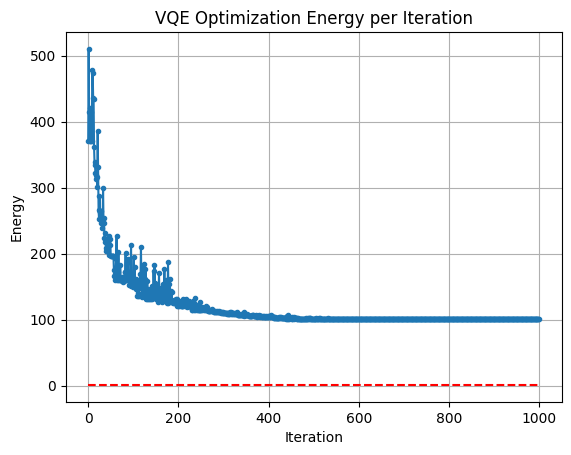

ITERATION 22 === MUB VQE STATE (mub_idx=0, state_idx=0, MUB_mask=(np.int64(4), np.int64(5)))
NUMBER OF QUBITS 8 8
Ground state energy: 100.54976676793449
Optimal parameters: [ 4.48761768e-04  3.27037376e-01  9.20462328e-01  5.44364814e-03
 -4.63166706e-03 -3.24328058e-01 -6.13325919e-01 -3.84796883e-01
  4.44455291e-03  1.57323690e+00  3.53580702e-03 -6.15419912e-03
 -1.10088219e+00  1.70946754e+00  2.00878683e+00 -3.40577540e-01
  1.42494367e+00  1.50136433e+00 -5.31786491e-01  1.84106258e+00
  9.21072882e-03  8.68788542e-01  1.27253961e+00  4.54187586e-02
  1.25614731e+00  3.64014417e-01  8.63844171e-02  1.29278302e+00
  2.15957545e+00  2.61610031e-02  1.76745323e+00  6.07097034e-01
  1.11645686e-02  1.98001007e+00  5.50563684e-01  1.14442803e+00
  1.33395041e+00 -1.92817621e-01  2.30727166e+00  4.64973142e-01
  1.63918026e+00  1.76268278e+00  1.63147421e+00  9.98139282e-01
  1.11477063e-02  5.93217514e-01  4.64922370e-01  9.07119427e-02
  1.51234246e+00  1.07404396e+00  1.40177516e+

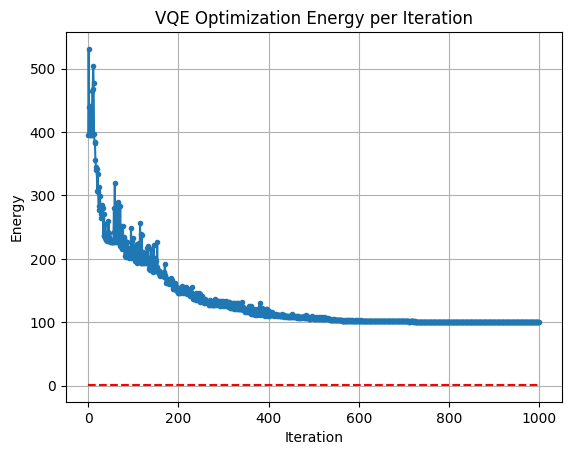

ITERATION 23 === MUB VQE STATE (mub_idx=0, state_idx=0, MUB_mask=(np.int64(4), np.int64(6)))
NUMBER OF QUBITS 8 8
Ground state energy: 1.9083935177353548
Optimal parameters: [-1.01179735e-02 -2.34943154e+00  7.91703738e-01  1.24294031e-01
 -3.83766348e-03 -7.89512624e-01  5.24184898e-01  3.82951063e-02
  5.89730924e-03  2.01563857e-03 -5.94460379e-03  5.05709900e-02
  3.05868970e-01  1.21695417e+00  9.17074695e-01  2.42957891e+00
  1.28732689e+00  1.40565144e+00  7.92917431e-01  1.00881927e+00
  9.52933957e-03 -1.41973969e-02  3.01890214e+00 -2.11408692e-02
  1.06184956e-01  3.11580287e-01  2.51277333e-01 -5.31922071e-01
  1.38424559e+00 -6.45311333e-01  7.84925952e-01  1.72826358e+00
 -9.84166640e-02  3.13965838e+00 -6.85544243e-03  2.17362969e-01
  1.60560488e+00 -1.97303218e-01  1.55704096e+00  6.23611472e-01
  1.00258971e+00  3.79526728e-01  1.14233736e-01  4.45627033e-01
 -1.97723233e-02  4.08662859e-02 -1.34131109e-01 -2.22806554e-01
  1.69350822e+00  1.28005204e+00  9.04430865e-

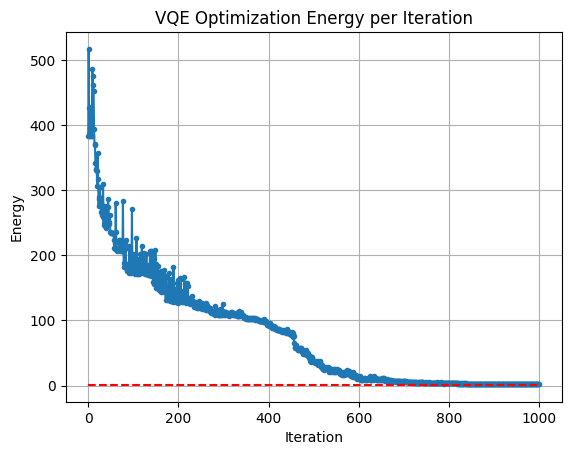

FOUND GLOBAL MINIMUM
ITERATION 24 === MUB VQE STATE (mub_idx=0, state_idx=0, MUB_mask=(np.int64(4), np.int64(7)))
NUMBER OF QUBITS 8 8
Ground state energy: 100.01081535942937
Optimal parameters: [-1.11497897e-03 -1.50037012e-03  1.48398112e+00  7.91699661e-01
 -1.63663081e-03  6.78227517e-04  9.94023915e-01 -6.76332861e-01
 -6.70119470e-04 -4.46636089e-04 -1.19943956e-02  3.13586603e-02
  2.69180283e-02  1.66847089e+00  1.14839642e+00  1.49857086e+00
  7.81232642e-01  1.44388928e+00  6.26811112e-01  1.99903288e+00
  2.09726239e-02 -4.44305744e-03  1.61964689e+00  1.15678974e+00
  6.84618575e-03  6.36106400e-01  3.25436832e-01  1.27176602e+00
  3.06548395e-02  6.95283206e-03  1.13014678e+00  3.49291786e-01
 -1.96413284e-03  3.83900824e-04  1.42273390e+00  1.53548183e+00
  6.31007183e-01 -8.13242051e-02  1.57970884e+00  1.25182496e+00
 -1.24158507e-01  1.93520924e+00  1.45779423e+00  8.25463306e-01
  2.08526466e-02 -4.93636227e-03  1.74300865e+00  3.46324813e-02
  5.55560627e-01  1.53504

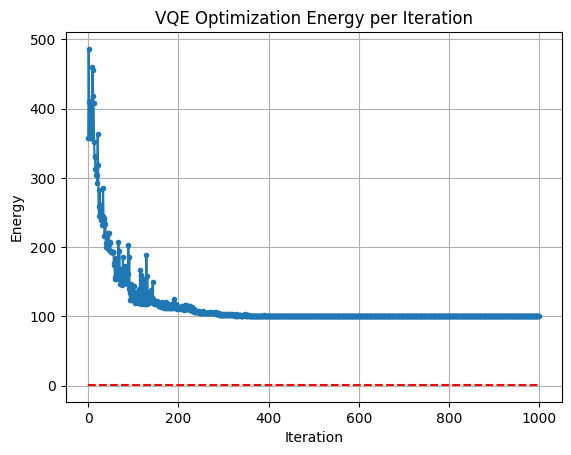

ITERATION 25 === MUB VQE STATE (mub_idx=0, state_idx=0, MUB_mask=(np.int64(5), np.int64(6)))
NUMBER OF QUBITS 8 8
Ground state energy: 1.4264301958467351
Optimal parameters: [ 3.99941881e-03  6.11268368e-03  1.52694629e+00  8.50645893e-01
 -1.24898691e-03 -6.22350300e-04  1.25382613e+00 -1.07969498e+00
  1.24634516e-02 -1.54730903e-03  1.70228264e-03  2.44333635e-01
  9.58543240e-02 -7.07850887e-02  9.82808466e-01  1.59223318e+00
  1.55417885e+00  1.28883196e+00  3.14132977e-02  2.02476830e+00
  1.64374464e+00  4.32556912e-03  1.54116951e+00  1.57534731e+00
  1.96042496e-01  1.08447524e+00  6.02517253e-01  1.15042585e+00
 -6.80323297e-03  5.26055223e-02  1.57178242e+00 -1.45833503e-01
  1.57281734e-01  1.51451046e-01  1.57245016e+00  1.57529775e+00
  1.34890344e+00  4.79449747e-01  1.34925958e+00  1.21261658e+00
 -1.62699966e-01  1.59792115e+00  1.48704147e+00  1.88259159e-01
  1.50047555e+00 -7.24135492e-03  1.57165173e+00  3.70088633e-02
 -7.27988185e-02  1.52687915e+00  6.01458303e-

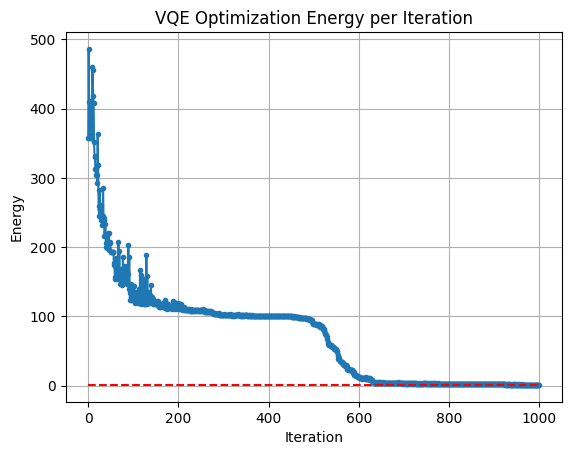

FOUND GLOBAL MINIMUM
ITERATION 26 === MUB VQE STATE (mub_idx=0, state_idx=0, MUB_mask=(np.int64(5), np.int64(7)))
NUMBER OF QUBITS 8 8
Ground state energy: 100.93098699267146
Optimal parameters: [-5.41251853e-03 -4.47762190e-01  1.93102782e+00  2.52976023e-02
  1.98992215e-03  4.62366116e-01 -3.14040239e-01  1.11099454e+00
  1.64650098e-03  3.41271384e-02 -2.20836069e-02  5.51647196e-03
 -7.78786060e-01  9.88808366e-01  9.60335208e-01  1.68585656e+00
  5.66686005e-01  8.95326381e-01  2.03725646e+00  1.43246985e+00
 -1.28804797e-03  1.81268111e-01  1.98783264e+00 -5.26010630e-02
  4.51128651e-03  2.32821276e-01  6.97800656e-01  4.07570700e-01
  1.29899550e+00 -4.22779582e-01  2.36586822e+00  1.94805510e+00
 -1.67232958e-02  1.13826025e+00  5.15818946e-01  2.20395357e-01
  2.11957747e+00 -7.30501417e-01  2.77075222e+00  1.42111235e-01
  3.62405254e-01  1.49484319e+00  3.20782922e-01 -1.46811649e-01
 -1.45523871e-02  8.98397413e-01  8.16065587e-01 -5.40524918e-03
  1.56858408e+00  9.33329

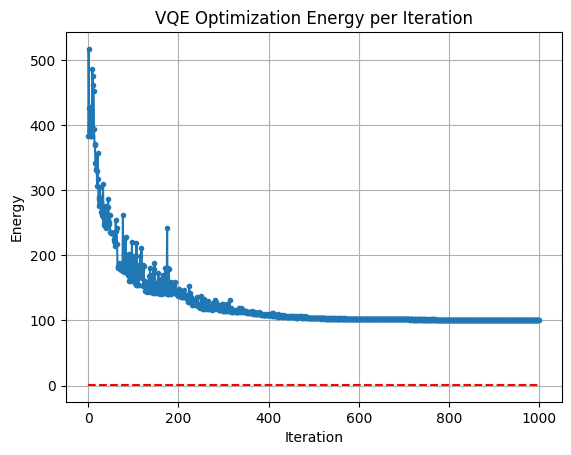

ITERATION 27 === MUB VQE STATE (mub_idx=0, state_idx=0, MUB_mask=(np.int64(6), np.int64(7)))
NUMBER OF QUBITS 8 8
Ground state energy: 100.60695388438462
Optimal parameters: [-4.19979128e-04 -1.05924394e-01  1.47920719e+00  6.45644233e-01
  2.76718797e-03  9.72082865e-02  2.18013465e-01 -3.06670018e-01
 -4.93001325e-03  1.49876156e+00  8.86288752e-03  6.11843190e-01
 -5.86108686e-01  1.07034104e+00  1.91904066e+00  1.19148349e+00
 -1.15956555e-01  1.83399380e+00  9.40241502e-01  2.43601676e+00
 -4.37658843e-03 -1.07751617e-01  1.64979744e+00  2.83129218e-01
  8.43616397e-01 -5.19667115e-01  3.58545984e-02  3.36843694e-02
  2.11552418e+00 -6.00357948e-01  1.59301734e+00  6.00870788e-01
 -9.71392636e-03  1.30353220e+00  3.64769660e-01  1.06694089e+00
  1.06783069e+00 -2.13965969e-02  7.68701287e-01  2.04008981e+00
  8.20311904e-01  1.55498188e+00  1.08563893e+00  3.57321821e-01
  9.63071031e-03  8.92520307e-01  8.40127729e-01  1.07721313e-01
  1.45802182e+00  1.69488559e+00  2.11095877e+

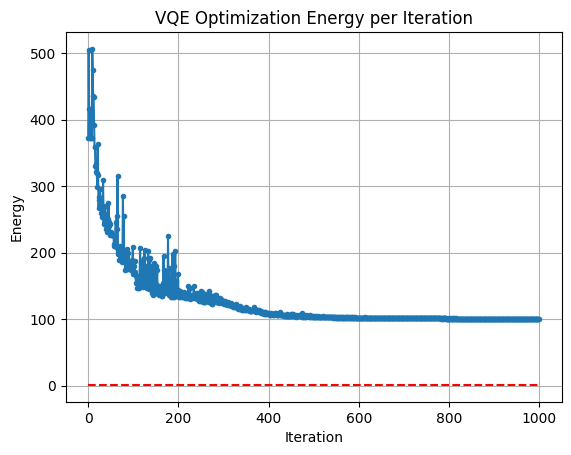

===== SUCCESS RATE FOR GLOBAL MINIMUM 9/28=32.142857142857146%


(9, 28)

In [11]:
import random

#Random Pair
mub_idx = random.randint(0, 4)
state_idx = random.randint(0, 3)

run_VQE_MUB_for_all_choose_2q(H_total_JSP, min_eigenvalue.real, MAX_ITER=30, mub_and_state_idx_list=[(mub_idx, state_idx)])

In [1]:
# from experiment_utils import *
# from qiskit_aer import Aer

# #Test that this is the MUB state:
# ansatz, thetas = get_mub_ansatz_and_thetas(8, state_idx=1, mub_idx=4, MUB_mask=None)

# qc = ansatz.assign_parameters(thetas)
# print(qc)
#print(parameter_dict_to_list(thetas, ansatz))
##

# # Simulate the circuit
# # backend = Aer.get_backend('statevector_simulator')
# # job = backend.run(qc)
# # result = job.result()
# # statevector = result.get_statevector()

In [2]:
# def vector_to_spherical_angles(v):
#     # Ensure the input is a numpy array and normalized
#     v = np.asarray(v)
#     assert np.isclose(np.linalg.norm(v), 1), f"The vector {v} must be normalized."
    
#     n = len(v)
#     angles = np.zeros(n - 1)

#     # Calculate the angles
#     for i in range(0, n - 1):
#         # Calculate the angle theta_i
#         # Use the norm of the remaining dimensions
#         norm_remaining = np.linalg.norm(v[i+1:])
#         angles[i] = np.arctan2(norm_remaining, v[i])
    
#     return angles

# def spherical_angles_to_vector(angles):
#     # Ensure the input is a numpy array
#     angles = np.asarray(angles)
#     n = len(angles) + 1  # Number of dimensions
    
#     # Initialize the unit vector
#     v = np.zeros(n)
    
#     # Calculate the first coordinate
#     v[0] = np.cos(angles[0])
    
#     # Calculate the remaining coordinates
#     for i in range(1, n):
#         # Compute the product of sines for the previous angles
#         if i < n - 1:
#             sin_product = np.prod(np.sin(angles[:i]))  # Product of sines for angles up to i-1
#             v[i] = sin_product * np.cos(angles[i])
#         else:
#             # For the last coordinate, we use the product of sines for all previous angles
#             v[i] = np.prod(np.sin(angles[:i]))  # This is sin(theta_1) * sin(theta_2) * ... * sin(theta_{n-2})

#     return v

# test_v = np.array([1/np.sqrt(5),1/np.sqrt(2),1/np.sqrt(10/3)])
# print(vector_to_spherical_angles(test_v))
# print(np.isclose(spherical_angles_to_vector(vector_to_spherical_angles(test_v)), test_v))

# def get_directions(v, step_size):
#     # Ensure the input is a numpy array
#     v = np.asarray(v)
#     directions = []
    
#     # Iterate over each element in the vector
#     for i in range(len(v)):
#         # Create a copy of the original vector
#         v_plus = v.copy()
#         v_minus = v.copy()
        
#         # Modify the i-th element
#         v_plus[i] += step_size
#         v_minus[i] -= step_size
        
#         # Append the new vectors to the directions list
#         directions.append(v_plus)
#         directions.append(v_minus)
    
#     return directions

# def optimizer(H, initial_guess, step_size=0.01):
#     best_vector_angles = vector_to_spherical_angles(initial_guess)
#     print(best_vector_angles)
#     best_value = get_eigenvalue_sparse(initial_guess, H)
#     print(best_value)
    
#     for iterations in range(500):
#         #Pick best direction
#         for nearby_step in get_directions(best_vector_angles, step_size):
#             new_value = get_eigenvalue_sparse(spherical_angles_to_vector(nearby_step), H)
#             print("direction")
#             if(best_value > new_value):
#                 best_value = new_value
#                 best_vector_angles = nearby_step
#         print(best_vector_angles)
    
#     return best_value, spherical_angles_to_vector(best_vector_angles)

In [3]:
# from scipy.sparse import diags

# H_diag_sparse = diags(H_diag.reshape(-1,))
# initial = np.zeros(shape=(H_diag.shape[0],))
# initial[0] = 1

# optimizer(H_diag, initial)

In [4]:
# **Quantum Exhaustive Binary Search - QEBS**
# from hamiltonians import get_expectation_value
# from qiskit.quantum_info import Statevector

# state_string = "+" * task.num_qubits

# for i in range(task.num_qubits):
#     #If 0
#     state_string_if_0 = state_string[:i] + "0" + state_string[i+1:]
#     state_if_0 = initialize_state_from_string(state_string_if_0)
#     #If 1
#     state_string_if_1 = state_string[:i] + "1" + state_string[i+1:]
#     state_if_1 = initialize_state_from_string(state_string_if_1)
#     print(get_expectation_value(state_if_0, H_total_JSP), get_expectation_value(state_if_1, H_total_JSP))
#     if get_expectation_value(state_if_0, H_total_JSP) >= get_expectation_value(state_if_1, H_total_JSP):
#         state_string = state_string_if_1
#     else:
#         state_string = state_string_if_0

# final_state = initialize_state_from_string(state_string)

# print("Naive solution", state_string)

In [ ]:
# **Simulated Annealing binary search**
# def simulated_annealing_binary_search(hamiltonian, n, max_iterations, debug=True):
#     # Initialize an empty prefix and a dictionary to track prefixes and their values
#     prefixes = {"":1}
#     best_solution = None
#     best_solution_value = 1e9

#     average_value = get_expectation_value(initialize_state_from_string("+" * n), hamiltonian)

#     for _ in range(max_iterations):
#         if len(prefixes) == 0:
#             break

#         # Sample a prefix with probability proportional to exp(-value(prefix))
#         total_value = sum(np.exp(-value / average_value) for value in prefixes.values())
#         probabilities = [np.exp(-value / average_value) / total_value for value in prefixes.values()]
        
#         # Sample a prefix based on the calculated probabilities
#         sampled_prefix = np.random.choice(list(prefixes.keys()), p=probabilities)
#         print(f"Sampled {sampled_prefix}") if debug else None
#         del prefixes[sampled_prefix]

#         # Check the value of adding a '0' to the sampled prefix
#         prefix_with_zero = sampled_prefix + "0" + "+" * (n-len(sampled_prefix)-1)
#         if len(sampled_prefix) + 1 < n:
#             prefixes[sampled_prefix + "0"] = get_expectation_value(initialize_state_from_string(prefix_with_zero), hamiltonian)
#         elif get_expectation_value(initialize_state_from_string(prefix_with_zero), hamiltonian) < best_solution_value:
#             best_solution_value = get_expectation_value(initialize_state_from_string(prefix_with_zero), hamiltonian)
#             best_solution = sampled_prefix + "0"
#             print(f"Landed on final state {best_solution}") if debug else None

#         # Check the value of adding a '1' to the sampled prefix
#         prefix_with_one = sampled_prefix + "1" + "+" * (n-len(sampled_prefix)-1)
#         if len(sampled_prefix) + 1 < n:
#             prefixes[sampled_prefix + "1"] = get_expectation_value(initialize_state_from_string(prefix_with_one), hamiltonian)
#         elif get_expectation_value(initialize_state_from_string(prefix_with_one), hamiltonian) < best_solution_value:
#             best_solution_value = get_expectation_value(initialize_state_from_string(prefix_with_one), hamiltonian)
#             best_solution = sampled_prefix + "1"
#             print(f"Landed on final state {best_solution}") if debug else None

#         print(prefixes) if debug else None
#         #print("normalized", [(k, prefixes[k] / average_value) for k in prefixes.keys()])

#     # Return the most valuable prefix or any other relevant information
#     if best_solution == None or (len(prefixes) > 0 and best_solution_value > min(prefixes.values())):
#         proposed_solution = min(prefixes, key=prefixes.get)
#     else:
#         proposed_solution = best_solution
    

#     if len(proposed_solution) < n:
#         for _ in range(n - len(proposed_solution)):
#             values, keys = np.array(list(prefixes.values())), np.array(list(prefixes.keys()))
#             sampled_prefix = keys[np.argmin(values)]

#             print(f"Greedy Sampled {sampled_prefix}") if debug else None
#             del prefixes[sampled_prefix]

#             # Check the value of adding a '0' to the sampled prefix
#             prefix_with_zero = sampled_prefix + "0" + "+" * (n-len(sampled_prefix)-1)
#             prefix_with_zero_value = get_expectation_value(initialize_state_from_string(prefix_with_zero), hamiltonian)
#             if len(sampled_prefix) + 1 < n:
#                 prefixes[sampled_prefix + "0"] = prefix_with_zero_value
            
#             # Check the value of adding a '1' to the sampled prefix
#             prefix_with_one = sampled_prefix + "1" + "+" * (n-len(sampled_prefix)-1)
#             prefix_with_one_value = get_expectation_value(initialize_state_from_string(prefix_with_one), hamiltonian)
#             if len(sampled_prefix) + 1 < n:
#                 prefixes[sampled_prefix + "1"] = prefix_with_one_value

#             if len(sampled_prefix) + 1 == n:
#                 if prefix_with_zero_value < prefix_with_one_value:
#                     return sampled_prefix + "0"
#                 else:
#                     return sampled_prefix + "1"

#             print("Greedy", prefixes) if debug else None
#             #print("Greedy normalized", [(k, prefixes[k] / average_value) for k in prefixes.keys()])
#     else:
#         return proposed_solution

# print("Found Solution", simulated_annealing_binary_search(H_total_JSP, task.num_qubits, 4))

In [ ]:
#**Benchmark - Probability of success vs number of iterations**
# N_MAX = 20
# iter_nums = list(range(2, 6))
# probabilities = []

# for iter_num in iter_nums:
#     success = 0
#     for N in range(N_MAX):
#         if simulated_annealing_binary_search(H_total_JSP, task.num_qubits, iter_num, debug=False) == binary_solution:
#             success += 1
#     probabilities += [success / N_MAX]

# print(probabilities)
# plt.plot(iter_nums, probabilities, marker='.')
# plt.xlabel("Number of Iterations")
# plt.ylabel("Probability of finding the optimal solution")

# plt.show()